<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirFrance/AirFrance_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AFFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 19:36:23,426 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 19:36:23,427 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AFFREUR
2019-08-26 19:39:14,173 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 19:45:38,954 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 19:48:58,056 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 19:52:28,129 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 19:55:45,188 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 19:59:16,645 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-26 20:02:53,182 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-26 20:06:30,210 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-26 20:17:18,708 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AFFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AFFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AFFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.13678  0.13703  0.13467  0.13678  4.181126
2018-01-02 09:00:00  0.13678  0.13758  0.13593  0.13623  2.800677
2018-01-02 10:00:00  0.13623  0.13683  0.13588  0.13623  1.366022
2018-01-02 11:00:00  0.13622  0.13678  0.13592  0.13657  1.118289
2018-01-02 12:00:00  0.13663  0.13828  0.13653  0.13807  1.172593
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.09397  0.09556  0.09357  0.09545  3.073051
2018-12-31 09:00:00  0.09541  0.09544  0.09478  0.09538  1.742141
2018-12-31 10:00:00  0.09537  0.09568  0.09527  0.09549  1.091274
2018-12-31 11:00:00  0.09549  0.09568  0.09507  0.09520  1.623163
2018-12-31 12:00:00  0.09515  0.09538  0.09451  0.09458  2.271411

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.090152     0.090657     0.089647     0.090147     3.254480
std       0.016902     0.016953     0.016817     0.016877     2.802975
min       0.066750     0.067200     0.066390     0.066740     0.001590
25%       0.079013     0.079502     0.078370     0.079075     1.348653
50%       0.087610     0.088160     0.087050     0.087585     2.278456
75%       0.096632     0.097255     0.096025     0.096650     4.285325
max       0.144070     0.145030     0.143270     0.144030    21.519575

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.14227  0.14293  0.14197  0.14203  1.332328    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.142417  0.140851 -0.144970  0.142517  0.142577  0.142725    0.143030    0.143500  0.144789  0.142875  0.142257  0.142978  0.142665  0.142875  0.142343  0.142438                0.144039                 0.142875                0.141711                0.144621                 0.142875                0.141129                0.145204                 0.142875                0.140546                0.145786                 0.142875                0.139964  0.142577  0.142299  0.142513                0.143741                 0.142577                0.141413                0.144324                 0.142577                0.140831                0.144906                 0.142577                0.140249                0.145488                 0.142577   
2018-01-09 14:00:00  0.14208  0.14238  0.14117  0.14122  2.531590    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.142357  0.140889 -0.144850  0.141994  0.142276  0.142569    0.142625    0.143100  0.144564  0.142656  0.141620  0.142723  0.142297  0.142656  0.141625  0.142464                0.144247                 0.142656                0.141066                0.145042                 0.142656                0.140271                0.145837                 0.142656                0.139476                0.146632                 0.142656                0.138680  0.142276  0.141536  0.142528                0.143866                 0.142276                0.140685                0.144661                 0.142276                0.139890                0.145456                 0.142276                0.139095                0.146251                 0.142276   
2018-01-09 15:00:00  0.14123  0.14259  0.14027  0.14217 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.089002     0.089503     0.088498     0.088994     3.286360    16.006284     2.018851   185.537253      30.423698    11.377917      0.034111        0.023788        0.002244          0.004039     6.600539     2.535009    26.957361     2.018851      2.008528    26.957361     0.089013     0.089191    -0.004208     0.088993     0.089070     0.089092     0.089063     0.089067     0.089188     0.089069     0.088994     0.089069     0.089044     0.089069     0.089011     0.089225                0.090590                 0.089069                0.087549                0.091350                 0.089069                0.086789                0.092110                 0.089069                0.086029                0.092870                 0.089069                0.085269     0.089070     0.089011     0.089201                0.090590                 0.089070                0.087550                0.091350                 0.089070                0.086790                0.092110   
std       0.015219     0.015267     0.015128     0.015183     2.824026     8.586021     1.413453   101.854206       0.853958     2.619209      0.181556        0.152423        0.047330          0.063443     3.351472     1.102365    14.551473     1.413453      1.403830    14.551473     0.015308     0.015553     0.090539     0.015191     0.015289     0.015350     0.015284     0.015277     0.015554     0.015302     0.015187     0.015307     0.015257     0.015302     0.015208     0.015544                0.015522                 0.015302                0.015153                0.015659                 0.015302                0.015107                0.015812                 0.015302                0.015079                0.015982                 0.015302                0.015070     0.015289     0.015204     0.015508                0.015505                 0.015289                0.015145                0.015640                 0.015289                0.015100                0.015791   
min       0.066750     0.067200     0.0663

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  1.000000  1.000000  1.000000  0.998144  0.061843    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  1.000000  0.994101  0.000000  1.000000  1.000000  1.000000    1.000000    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.999571                0.977774                 1.000000                1.000000                0.950881                 1.000000                1.000000                0.923542                 1.000000                1.000000                0.897788                 1.000000                1.000000  1.000000  1.000000  0.999798                0.984149                 1.000000                1.000000                0.957520                 1.000000                1.000000                0.929579                 1.000000                1.000000                0.902690                 1.000000   
2018-01-09 14:00:00  0.997484  0.992737  0.989415  0.987406  0.117576    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.999204  0.994614  0.000431  0.993095  0.995998  0.997922    0.994663    0.994747  0.997123  0.997116  0.991557  0.996643  0.995137  0.997116  0.990485  0.999925                0.980422                 0.997116                0.991546                0.956080                 0.997116                0.989208                0.931115                 0.997116                0.987169                0.907583                 0.997116                0.985345  0.995998  0.989872  1.000000                0.985761                 0.995998                0.990426                0.961753                 0.995998                0.988271                0.936253                 0.995998                0.986333                0.911639                 0.995998   
2018-01-09 15:00:00  0.986229  0.995510  

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         7 hours 12 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_tnaytk
H2O cluster total nodes:    1
H2O cluster free memory:    8.37 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.753074  0.589511              0.306149  0.450944  0.203351
1  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.747411  0.703983              0.334628  0.483260  0.233540
2  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.741262  0.594378              0.324960  0.453032  0.205238
3  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.736812  0.797753              0.293649  0.487733  0.237883
4  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.732929  0.614977              0.306108  0.457672  0.209464
5  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.731715  0.652179              0.319337  0.464346  0.215617
6  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.719741  0.640336              0.381189  0.474619  0.225264
7  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.717880  0.627038              0.345065  0.468333  0.219336
8  DeepLearning_grid_1_AutoML_20190826_202507_mod...  0.691828  2.896753              0.346400  0.586517  0.344003
9              DeepLearning_1_AutoML_20190826_202507  0.674595  0.653034              0.344256  0.476414  0.226971

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006079
1                          SUB             0.516484           0.516484    0.003140
2           CDLCLOSINGMARUBOZU             0.506904           0.506904    0.003082
3                          DIV             0.504325           0.504325    0.003066
4                       TRANGE             0.480308           0.480308    0.002920
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_14_1_2             0.126490           0.126490    0.000769
1033   BBANDS_lowerband_24_7_2             0.126202           0.126202    0.000767
1034    BBANDS_lowerband_8_1_4             0.126083           0.126083    0.000766
1035   BBANDS_lowerband_20_5_2             0.125310           0.125310    0.000762
1036                   MA_24_7             0.124255           0.124255    0.000755

[1037 rows x 4 columns]

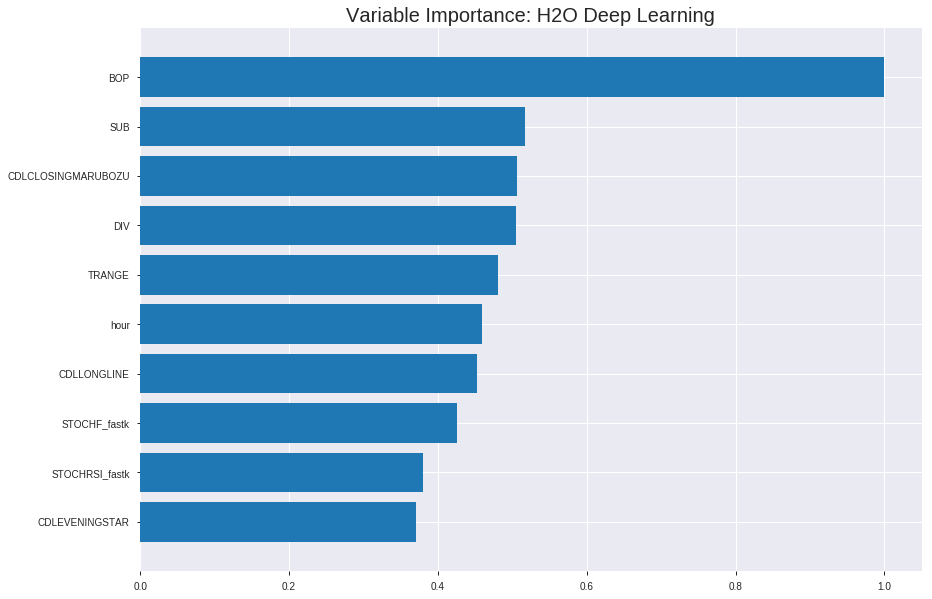

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_202507_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19978334371748266
RMSE: 0.44697130077610425
LogLoss: 0.5840624754683468
Mean Per-Class Error: 0.28836731468310417
AUC: 0.7790222355319308
pr_auc: 0.7251869938161953
Gini: 0.5580444710638617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43083419407629675: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      426  429   0.5018   (429.0/855.0)
1      68   635   0.0967   (68.0/703.0)
Total  494  1064  0.319    (497.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430834     0.718732  251
max f2                       0.310169     0.833536  306
max f0point5                 0.535753     0.671327  196
max accuracy                 0.525485     0.707317  202
max precision                0.992247     1         0
max recall                   0.0752401    1         382
max specificity              0.992247     1         0
max absolute_mcc             0.470609     0.430294  232
max min_per_class_accuracy   0.547811     0.702703  190
max mean_per_class_accuracy  0.511677     0.711633  210

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.962927           2.0777     2.0777             0.9375           0.974173  0.9375                      0.974173            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.95046            2.21622    2.14696            1                0.956638  0.96875                     0.965405            0.0227596       0.0440967                  121.622   114.696
    3        0.0301669                   0.937376           2.06847    2.12191            0.933333         0.9425    0.957447                    0.958095            0.0199147       0.0640114                  106.847   112.191
    4        0.0404365                   0.92574            1.66216    2.00515            0.75             0.932251  0.904762                    0.951532            0.0170697       0.0810811                  66.2162   100.515
    5        0.0500642                   0.914448           1.92072    1.98891            0.866667         0.920212  0.897436                    0.945509            0.0184922       0.0995733                  92.0721   98.8912
    6        0.100128                    0.872189           1.76161    1.87526            0.794872         0.892144  0.846154                    0.918826            0.0881935       0.187767                   76.1608   87.526
    7        0.150193                    0.827815           1.64796    1.79949            0.74359          0.850315  0.811966                    0.895989            0.0825036       0.27027                    64.7956   79.9492
    8        0.200257                    0.781151           1.42065    1.70478            0.641026         0.80461   0.769231                    0.873144            0.0711238       0.341394                   42.0651   70.4782
    9        0.300385                    0.704005           1.26438    1.55798            0.570513         0.740639  0.702991                    0.828976            0.1266          0.467994                   26.438    55.7981
    10       0.399872                    0.611258           1.32973    1.50119            0.6              0.66127   0.677368                    0.787251            0.13229         0.600284                   32.973    50.1193
    11       0.5                         0.530262           1.26438    1.45377            0.570513         0.568243  0.655969                    0.743393            0.1266          0.726885                   26.438    45.377
    12       0.600128                    0.474477           1.05128    1.38662            0.474359         0.500681  0.625668                    0.702898            0.105263        0.832148                   5.12821   38.6617
    13       0.699615                    0.419317           0.772101   1.29923            0.348387         0.447369  0.586239                    0.666561            0.0768137       0.908962                   -22.7899  29.9231
    14       0.799743                    0.343996           0.497228   1.19882            0.224359         0.386233  0.540931                    0.631464            0.0497866       0.958748                   -50.2772  19.882
    15       0.899872                    0.205442           0.32675    1.10179            0.147436         0.28006   0.497147                    0.592364            0.0327169       0.991465                   -67.325   10.1785
    16       1                           6.6432e-05         0.0852391  1                  0.0384615        0.121434  0.45122                     0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19900152384398065
RMSE: 0.44609586844531596
LogLoss: 0.5911896005400683
Mean Per-Class Error: 0.2857315233785822
AUC: 0.7636400201106084
pr_auc: 0.714170374152513
Gini: 0.5272800402212168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39064301965723225: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  96   0.4267   (96.0/225.0)
1      32   189  0.1448   (32.0/221.0)
Total  161  285  0.287    (128.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390643     0.747036  254
max f2                       0.181496     0.844622  333
max f0point5                 0.507595     0.7102    188
max accuracy                 0.461259     0.713004  224
max precision                0.955829     1         0
max recall                   0.0109492    1         397
max specificity              0.955829     1         0
max absolute_mcc             0.390643     0.446108  254
max min_per_class_accuracy   0.48882      0.687783  198
max mean_per_class_accuracy  0.390643     0.714268  254

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 46.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.895191           1.61448   1.61448            0.8              0.917742   0.8                         0.917742            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.874365           1.51357   1.56963            0.75             0.885177   0.777778                    0.903268            0.0135747       0.0316742                  51.3575   56.9633
    3        0.0313901                   0.857881           1.61448   1.58565            0.8              0.868037   0.785714                    0.890686            0.0180995       0.0497738                  61.448    58.565
    4        0.0403587                   0.829093           1.00905   1.45752            0.5              0.851602   0.722222                    0.882001            0.00904977      0.0588235                  0.904977  45.7516
    5        0.0515695                   0.820349           1.21086   1.4039             0.6              0.822639   0.695652                    0.869096            0.0135747       0.0723982                  21.086    40.3895
    6        0.100897                    0.774675           1.65117   1.52479            0.818182         0.791581   0.755556                    0.8312              0.081448        0.153846                   65.1172   52.4786
    7        0.150224                    0.725719           1.83464   1.62653            0.909091         0.753669   0.80597                     0.805742            0.0904977       0.244344                   83.4636   62.6528
    8        0.201794                    0.682468           1.49164   1.59206            0.73913          0.704855   0.788889                    0.779959            0.0769231       0.321267                   49.1639   59.2056
    9        0.300448                    0.605934           1.42184   1.53617            0.704545         0.643208   0.761194                    0.735056            0.140271        0.461538                   42.1843   53.6165
    10       0.401345                    0.539937           1.25571   1.46566            0.622222         0.566404   0.726257                    0.692657            0.126697        0.588235                   25.5706   46.5659
    11       0.5                         0.485636           1.00905   1.37557            0.5              0.513332   0.681614                    0.657275            0.0995475       0.687783                   0.904977  37.5566
    12       0.600897                    0.426253           1.16601   1.34038            0.577778         0.461271   0.664179                    0.624364            0.117647        0.80543                    16.6013   34.038
    13       0.699552                    0.329271           0.825586  1.26778            0.409091         0.377168   0.628205                    0.589503            0.081448        0.886878                   -17.4414  26.778
    14       0.800448                    0.214472           0.493313  1.17016            0.244444         0.27714    0.579832                    0.550129            0.0497738       0.936652                   -50.6687  17.0159
    15       0.899103                    0.111411           0.412793  1.08706            0.204545         0.162526   0.538653                    0.507599            0.040724        0.977376                   -58.7207  8.70561
    16       1                           0.00213985         0.224233  1                  0.111111         0.0536139  0.495516                    0.4


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:26:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:26:41  1 min 31.967 sec  471 obs/sec       0.604621  1             942        0.643343         6.28732             -0.671471      0.591425        0.337689           1.31588          0.54878                          0.598786           3.4774                -0.434295        0.665068          0.602795             1.61448            0.408072
    2019-08-26 20:26:56  1 min 46.756 sec  432 obs/sec       4.30039   7             6700       0.468101         0.632838            0.115102       0.726803        0.672081           2.0777           0.362644                         0.462345           0.626805              0.14488          0.749613          0.712926             2.0181             0.336323
    2019-08-26 20:27:10  2 min  0.521 sec  444 obs/sec       7.98331   13            12438      0.466597         0.630533            0.12078        0.728345        0.67874            2.0777           0.392811                         0.464264           0.631409              0.137768         0.724485          0.682802             2.0181             0.336323
    2019-08-26 20:27:24  2 min 14.320 sec  451 obs/sec       11.7381   19            18288      0.452989         0.604326            0.171315       0.762007        0.718              2.0777           0.350449                         0.469676           0.674791              0.117546         0.737888          0.712335             2.0181             0.363229
    2019-08-26 20:27:37  2 min 27.869 sec  456 obs/sec       15.4313   25            24042      0.446971         0.584062            0.193187       0.779022        0.725187           2.0777           0.318999                         0.446096           0.59119               0.20393          0.76364           0.71417              1.61448            0.286996
    2019-08-26 20:27:51  2 min 41.186 sec  460 obs/sec       19.1406   31            29821      0.4431           0.579394            0.207103       0.794782        0.751272           2.0777           0.315789                         0.472994           0.689967              0.105036         0.772318          0.733774             1.21086            0.298206
    2019-08-26 20:28:06  2 min 56.305 sec  465 obs/sec       23.4531   38            36540      0.45473          0.618566            0.164935       0.75656         0.691446           2.21622          0.320282                         0.49017            0.779675              0.0388575        0.747049          0.707409             1.61448            0.340807
    2019-08-26 20:28:07  2 min 57.651 sec  465 obs/sec       23.4531   38            36540      0.446971         0.584062            0.193187       0.779022        0.725187           2.0777           0.318999                         0.446096           0.59119               0.20393          0.76364           0.71417              1.61448            0.286996

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.00607934083348489
SUB                       0.5164836645126343     0.5164836645126343   0.0031398802314995685
CDLCLOSINGMARUBOZU        0.5069036483764648     0.5069036483764648   0.0030816400482175095
DIV                       0.5043252110481262     0.5043252110481262   0.003065964848880759
TRANGE                    0.4803084433078766     0.4803084433078766   0.0029199587320691365
---                       ---                    ---                  ---
BBANDS_middleband_14_1_2  0.1264897882938385     0.1264897882938385   0.0007689745349935915
BBANDS_lowerband_24_7_2   0.12620238959789276    0.12620238959789276  0.0007672273403658383
BBANDS_lowerband_8_1_4    0.12608274817466736    0.12608274817466736  0.0007664999993762478
BBANDS_lowerband_20_5_2   0.12530997395515442    0.12530997395515442  0.0007618020415084984
MA_24_7                   0.12425501644611359    0.12425501644611359  0.000755388595246195


See the whole table with table.as_data_frame()


('accuracy', 0.6905829596412556)

('F1', 0.7125506072874495)

('auc', 0.7530744336569579)

('logloss', 0.5895108669855098)

('mean_per_class_error', 0.3033576051779936)

('rmse', 0.45094433933161104)

('mse', 0.20335079717522317)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


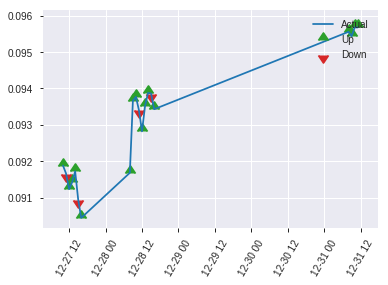


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20335079717522317
RMSE: 0.45094433933161104
LogLoss: 0.5895108669855098
Mean Per-Class Error: 0.3033576051779936
AUC: 0.7530744336569579
pr_auc: 0.7144441241707874
Gini: 0.5061488673139158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45079448656628857: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   56   0.4667   (56.0/120.0)
1      15   88   0.1456   (15.0/103.0)
Total  79   144  0.3184   (71.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450794     0.712551  143
max f2                       0.152518     0.826645  210
max f0point5                 0.556195     0.67033   87
max accuracy                 0.556195     0.690583  87
max precision                0.902395     1         0
max recall                   0.152518     1         210
max specificity              0.902395     1         0
max absolute_mcc             0.46232      0.40464   138
max min_per_class_accuracy   0.524165     0.675     108
max mean_per_class_accuracy  0.46232      0.696642  138

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.87114            2.16505   2.16505            1                0.885675  1                           0.885675            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.863455           2.16505   2.16505            1                0.867023  1                           0.878214            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.84969            2.16505   2.16505            1                0.855232  1                           0.871648            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.830178           2.16505   2.16505            1                0.844299  1                           0.865571            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.813414           2.16505   2.16505            1                0.820194  1                           0.854227            0.0291262       0.116505                   116.505   116.505
    6        0.103139                    0.738739           1.37776   1.78852            0.636364         0.767125  0.826087                    0.812569            0.0679612       0.184466                   37.7758   78.8518
    7        0.152466                    0.717869           1.7714    1.78298            0.818182         0.731149  0.823529                    0.786228            0.0873786       0.271845                   77.1403   78.2981
    8        0.201794                    0.680332           1.18094   1.63581            0.545455         0.698336  0.755556                    0.764743            0.0582524       0.330097                   18.0936   63.5814
    9        0.300448                    0.609031           1.27935   1.51877            0.590909         0.638915  0.701493                    0.723426            0.126214        0.456311                   27.9347   51.8765
    10       0.399103                    0.553889           1.37776   1.48391            0.636364         0.580245  0.685393                    0.688033            0.135922        0.592233                   37.7758   48.391
    11       0.502242                    0.521534           0.941325  1.37249            0.434783         0.538329  0.633929                    0.65729             0.0970874       0.68932                    -5.86745  37.2486
    12       0.600897                    0.471795           1.18094   1.34104            0.545455         0.489336  0.619403                    0.629716            0.116505        0.805825                   18.0936   34.1038
    13       0.699552                    0.418635           0.688879  1.24907            0.318182         0.444936  0.576923                    0.603657            0.0679612       0.873786                   -31.1121  24.9066
    14       0.798206                    0.343187           0.590468  1.16767            0.272727         0.383252  0.539326                    0.576416            0.0582524       0.932039                   -40.9532  16.7667
    15       0.896861                    0.216682           0.393645  1.08252            0.181818         0.275587  0.5                         0.543325            0.038835        0.970874                   -60.6355  8.25243
    16       1                           0.0104378          0.282398  1                  0.130435         0.134311  0.461883                    0.501139          

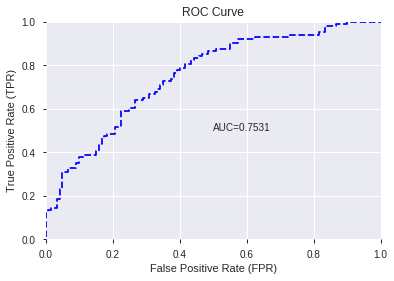

This function is available for GLM models only


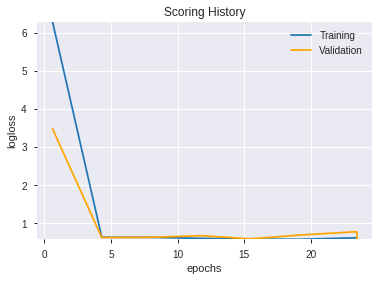

--2019-08-26 20:56:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_202507_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_202507_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_205631_model_7  0.744013  0.639381              0.365939  0.465257  0.216464
1  DeepLearning_grid_1_AutoML_20190826_205631_model_3  0.742961  0.702029              0.350647  0.467407  0.218469
2  DeepLearning_grid_1_AutoML_20190826_205631_model_1  0.742799  0.892734              0.290817  0.492407  0.242464
3  DeepLearning_grid_1_AutoML_20190826_205631_model_9  0.741100  0.616995              0.319377  0.461287  0.212786
4  DeepLearning_grid_1_AutoML_20190826_205631_model_8  0.731958  0.603867              0.351335  0.457874  0.209648
5  DeepLearning_grid_1_AutoML_20190826_205631_model_5  0.730825  0.612114              0.342273  0.458564  0.210281
6  DeepLearning_grid_1_AutoML_20190826_205631_model_6  0.721926  0.663649              0.322168  0.469544  0.220472
7  DeepLearning_grid_1_AutoML_20190826_205631_model_2  0.721440  0.733021              0.352023  0.480646  0.231020
8               DeepLearning_1_AutoML_20190826_205631  0.720065  0.655643              0.361772  0.473210  0.223928
9  DeepLearning_grid_1_AutoML_20190826_205631_model_4  0.718204  0.933191              0.395793  0.516241  0.266505

variable  relative_importance  scaled_importance  percentage
0                  DIV             1.000000           1.000000    0.022082
1                  SUB             0.989362           0.989362    0.021847
2   CDLCLOSINGMARUBOZU             0.986447           0.986447    0.021783
3                  BOP             0.986257           0.986257    0.021778
4            CDLHARAMI             0.956026           0.956026    0.021111
5              CDLDOJI             0.946674           0.946674    0.020904
6    CDLSTALLEDPATTERN             0.943347           0.943347    0.020831
7                 hour             0.936263           0.936263    0.020675
8   CDLMORNINGDOJISTAR             0.931328           0.931328    0.020566
9       CDLEVENINGSTAR             0.927730           0.927730    0.020486
10            WILLR_12             0.925238           0.925238    0.020431
11              ULTOSC             0.924512           0.924512    0.020415
12               CCI_8             0.923378           0.923378    0.020390
13           CDLHAMMER             0.923117           0.923117    0.020384
14           CORREL_30             0.920348           0.920348    0.020323
15          aroonup_30             0.916477           0.916477    0.020238
16              SAREXT             0.915472           0.915472    0.020215
17           dayofweek             0.915284           0.915284    0.020211
18       days_in_month             0.909795           0.909795    0.020090
19              TRANGE             0.907691           0.907691    0.020044
20   CDLINVERTEDHAMMER             0.907587           0.907587    0.020041
21      STOCHRSI_fastd             0.902841           0.902841    0.019936
22              Volume             0.902274           0.902274    0.019924
23              MFI_12             0.901611           0.901611    0.019909
24         HT_DCPERIOD             0.899865           0.899865    0.019871
25      CDLSPINNINGTOP             0.899365           0.899365    0.019860
26           aroonup_8             0.899070           0.899070    0.019853
27  CDLEVENINGDOJISTAR             0.898488           0.898488    0.019840
28   CDL3WHITESOLDIERS             0.896583           0.896583    0.019798
29              MFI_14             0.895332           0.895332    0.019771
30             BETA_24             0.893986           0.893986    0.019741
31      CDL3BLACKCROWS             0.893250           0.893250    0.019725
32                 day             0.890084           0.890084    0.019655
33             WILLR_8             0.889216           0.889216    0.019636
34               MFI_8             0.888596           0.888596    0.019622
35        aroondown_30             0.886580           0.886580    0.019577
36         STOCH_slowd             0.886127           0.886127    0.019567
37             quarter             0.885499           0.885499    0.019554
38      STOCHRSI_fastk             0.878943           0.878943    0.019409
39          AROONOSC_8             0.877554           0.877554    0.019378
40        STOCHF_fastd             0.875386           0.875386    0.019330
41        HT_TRENDMODE             0.874655           0.874655    0.019314
42      CDLMORNINGSTAR             0.872250           0.872250    0.019261
43         STOCH_slowk             0.872041           0.872041    0.019256
44         aroondown_8             0.868873           0.868873    0.019186
45         CDLLONGLINE             0.865003           0.865003    0.019101
46        STOCHF_fastk             0.860169           0.860169    0.018994
47        weekday_name             0.855275           0.855275    0.018886
48             weekday             0.848354           0.848354    0.018733
49     CDLUNIQUE3RIVER             0.836290           0.836290    0.018467

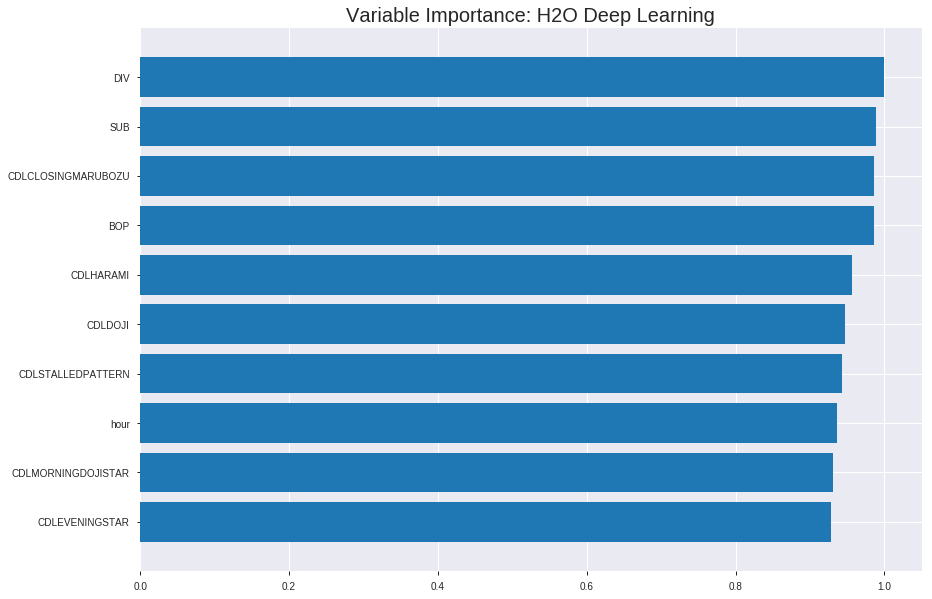

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_205631_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19624154594907536
RMSE: 0.4429915867700823
LogLoss: 0.5990682474253891
Mean Per-Class Error: 0.26527580211790736
AUC: 0.8139543976109073
pr_auc: 0.7800559859386348
Gini: 0.6279087952218145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20133394500071675: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      563  292  0.3415   (292.0/855.0)
1      134  569  0.1906   (134.0/703.0)
Total  697  861  0.2734   (426.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201334     0.727621  283
max f2                       0.0300309    0.832318  375
max f0point5                 0.40733      0.723851  191
max accuracy                 0.269407     0.733633  251
max precision                0.999281     1         0
max recall                   0.00350859   1         395
max specificity              0.999281     1         0
max absolute_mcc             0.205664     0.469331  281
max min_per_class_accuracy   0.269407     0.732575  251
max mean_per_class_accuracy  0.205664     0.734724  281

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 31.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.964014           2.21622   2.21622            1                0.987134    1                           0.987134            0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.935743           2.21622   2.21622            1                0.947161    1                           0.967147            0.0227596       0.0455192                  121.622   121.622
    3        0.0301669                   0.912201           2.06847   2.16906            0.933333         0.924304    0.978723                    0.953474            0.0199147       0.0654339                  106.847   116.906
    4        0.0404365                   0.89128            2.0777    2.14586            0.9375           0.899875    0.968254                    0.939862            0.0213371       0.086771                   107.77    114.586
    5        0.0500642                   0.870998           1.92072   2.10256            0.866667         0.883231    0.948718                    0.928971            0.0184922       0.105263                   92.0721   110.256
    6        0.100128                    0.750214           1.87526   1.98891            0.846154         0.812285    0.897436                    0.870628            0.0938834       0.199147                   87.526    98.8912
    7        0.150193                    0.66376            1.93209   1.96997            0.871795         0.705035    0.888889                    0.815431            0.0967283       0.295875                   93.2086   96.997
    8        0.200257                    0.582775           1.79002   1.92498            0.807692         0.620844    0.86859                     0.766784            0.0896159       0.385491                   79.0021   92.4983
    9        0.300385                    0.444283           1.40644   1.75214            0.634615         0.507724    0.790598                    0.680431            0.140825        0.526316                   40.6445   75.2137
    10       0.399872                    0.33291            1.20105   1.61503            0.541935         0.386355    0.728732                    0.607266            0.119488        0.645804                   20.1046   61.5028
    11       0.5                         0.2439             1.03708   1.49929            0.467949         0.29008     0.676508                    0.543747            0.103841        0.749644                   3.70755   49.9289
    12       0.600128                    0.167835           0.923423  1.40321            0.416667         0.202288    0.633155                    0.486777            0.0924609       0.842105                   -7.65766  40.3209
    13       0.699615                    0.0904974          0.614821  1.2911             0.277419         0.127586    0.582569                    0.435699            0.0611664       0.903272                   -38.5179  29.1098
    14       0.799743                    0.0401043          0.511435  1.19348            0.230769         0.0627041   0.538523                    0.389               0.0512091       0.954481                   -48.8565  19.3484
    15       0.899872                    0.0112208          0.32675   1.09704            0.147436         0.0238766   0.495007                    0.348373            0.0327169       0.987198                   -67.325   9.70428
    16       1                           5.67154e-07        0.127859  1                  0.0576923        0.00436248  0.45122   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.284396229561278
RMSE: 0.5332881299647293
LogLoss: 0.9080726049011854
Mean Per-Class Error: 0.3040723981900453
AUC: 0.7479939668174963
pr_auc: 0.7031802281541122
Gini: 0.4959879336349926
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.055873863565014795: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      111  114  0.5067   (114.0/225.0)
1      26   195  0.1176   (26.0/221.0)
Total  137  309  0.3139   (140.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0558739    0.735849  294
max f2                       0.00188067   0.842912  386
max f0point5                 0.156838     0.690282  212
max accuracy                 0.112518     0.695067  243
max precision                0.993146     1         0
max recall                   4.84353e-06  1         399
max specificity              0.993146     1         0
max absolute_mcc             0.0558739    0.407168  294
max min_per_class_accuracy   0.15458      0.688889  215
max mean_per_class_accuracy  0.0979998    0.695928  254

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 24.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.974202           2.0181    2.0181             1                0.986976    1                           0.986976            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.90503            1.51357   1.79387            0.75             0.955477    0.888889                    0.972976            0.0135747       0.0361991                  51.3575   79.3866
    3        0.0313901                   0.869566           1.21086   1.58565            0.6              0.887827    0.785714                    0.942566            0.0135747       0.0497738                  21.086    58.565
    4        0.0403587                   0.796355           0.504525  1.3454             0.25             0.836784    0.666667                    0.919059            0.00452489      0.0542986                  -49.5475  34.54
    5        0.0515695                   0.737759           2.0181    1.49164            1                0.752461    0.73913                     0.882842            0.0226244       0.0769231                  101.81    49.1639
    6        0.100897                    0.651591           1.55944   1.52479            0.772727         0.70314     0.755556                    0.794987            0.0769231       0.153846                   55.9441   52.4786
    7        0.150224                    0.530562           1.55944   1.53617            0.772727         0.59827     0.761194                    0.730394            0.0769231       0.230769                   55.9441   53.6165
    8        0.201794                    0.462842           1.49164   1.52479            0.73913          0.496675    0.755556                    0.670665            0.0769231       0.307692                   49.1639   52.4786
    9        0.300448                    0.32135            1.46771   1.50604            0.727273         0.383523    0.746269                    0.57638             0.144796        0.452489                   46.7709   50.6044
    10       0.401345                    0.235531           1.03147   1.38674            0.511111         0.275827    0.687151                    0.500822            0.104072        0.556561                   3.14731   38.6739
    11       0.5                         0.153418           1.37598   1.38462            0.681818         0.188337    0.686099                    0.439166            0.135747        0.692308                   37.5977   38.4615
    12       0.600897                    0.0961597          0.986626  1.31779            0.488889         0.122149    0.652985                    0.385935            0.0995475       0.791855                   -1.33736  31.7789
    13       0.699552                    0.0521697          0.917318  1.26131            0.454545         0.0710396   0.625                       0.341527            0.0904977       0.882353                   -8.2682   26.1312
    14       0.800448                    0.0252624          0.583007  1.17581            0.288889         0.0386745   0.582633                    0.303352            0.0588235       0.941176                   -41.6993  17.5812
    15       0.899103                    0.00510526         0.366927  1.08706            0.181818         0.0135288   0.538653                    0.271551            0.0361991       0.977376                   -63.3073  8.70561
    16       1                           4.84353e-06        0.224233  1                  0.111111         0.00169761  0.495516     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:01:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:02:04  7.663 sec         247 obs/sec       1         1             1558       0.529211         1.04268             -0.131022      0.675857        0.617504           1.66216          0.447368                         0.602971           1.39628               -0.454411        0.659467          0.620732             1.21086            0.381166
    2019-08-26 21:02:17  20.980 sec        425 obs/sec       5         5             7790       0.442992         0.599068            0.207491       0.813954        0.780056           2.21622          0.273427                         0.533288           0.908073              -0.137676        0.747994          0.70318              2.0181             0.313901
    2019-08-26 21:02:33  36.711 sec        476 obs/sec       10        10            15580      0.382314         0.446734            0.409725       0.883894        0.851066           2.21622          0.19448                          0.511089           0.915015              -0.0449303       0.746526          0.691479             1.61448            0.363229
    2019-08-26 21:02:48  51.662 sec        503 obs/sec       15        15            23370      0.369223         0.425679            0.449456       0.922137        0.897965           2.21622          0.161104                         0.561006           1.27264               -0.259012        0.724535          0.666961             1.61448            0.336323
    2019-08-26 21:03:03  1 min  6.539 sec  519 obs/sec       20        20            31160      0.315884         0.322174            0.597033       0.944398        0.871944           2.21622          0.125802                         0.569923           1.52083               -0.299355        0.715807          0.656416             1.61448            0.313901
    2019-08-26 21:03:18  1 min 21.491 sec  529 obs/sec       25        25            38950      0.280623         0.253751            0.681976       0.964708        0.853141           2.21622          0.0956354                        0.585738           1.89746               -0.372466        0.709864          0.649122             1.21086            0.347534
    2019-08-26 21:03:33  1 min 36.454 sec  535 obs/sec       30        30            46740      0.293454         0.286716            0.652228       0.977749        0.90053            2.21622          0.0648267                        0.598405           2.21854               -0.432467        0.698391          0.647004             1.61448            0.347534
    2019-08-26 21:03:34  1 min 37.831 sec  535 obs/sec       30        30            46740      0.442992         0.599068            0.207491       0.813954        0.780056           2.21622          0.273427                         0.533288           0.908073              -0.137676        0.747994          0.70318              2.0181             0.313901

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
DIV                 1.0                    1.0                  0.022081931191421832
SUB                 0.9893619418144226     0.9893619418144226   0.02184702232255757
CDLCLOSINGMARUBOZU  0.9864474534988403     0.9864474534988403   0.02178266479211468
BOP                 0.9862570762634277     0.9862570762634277   0.021778460895101884
CDLHARAMI           0.9560262560844421     0.9560262560844421   0.02111090600404928
---                 ---                    ---                  ---
CDLLONGLINE         0.8650026321411133     0.8650026321411133   0.019100928603338833
STOCHF_fastk        0.8601685166358948     0.8601685166358948   0.018994181997381215
weekday_name        0.8552747964859009     0.8552747964859009   0.018886119205758976
weekday             0.848353922367096      0.848353922367096    0.01873329293968303
CDLUNIQUE3RIVER     0.8362903594970703     0.8362903594970703   0.018466906174463733


See the whole table with table.as_data_frame()


('accuracy', 0.6995515695067265)

('F1', 0.6925795053003533)

('auc', 0.7440129449838188)

('logloss', 0.6393812286551983)

('mean_per_class_error', 0.31080097087378644)

('rmse', 0.4652573849790171)

('mse', 0.2164644342775133)

deeplearning prediction progress: |███████████████████████████████████████| 100%


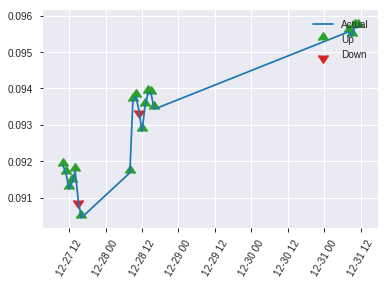


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2164644342775133
RMSE: 0.4652573849790171
LogLoss: 0.6393812286551983
Mean Per-Class Error: 0.31080097087378644
AUC: 0.7440129449838188
pr_auc: 0.7234620493701687
Gini: 0.4880258899676375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08652356694895445: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   82   0.6833   (82.0/120.0)
1      5    98   0.0485   (5.0/103.0)
Total  43   180  0.3901   (87.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0865236    0.69258   179
max f2                       0.019463     0.838762  201
max f0point5                 0.547546     0.687961  75
max accuracy                 0.547546     0.699552  75
max precision                0.997397     1         0
max recall                   0.019463     1         201
max specificity              0.997397     1         0
max absolute_mcc             0.547546     0.396562  75
max min_per_class_accuracy   0.431551     0.660194  105
max mean_per_class_accuracy  0.541909     0.689199  77

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.68 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.989486           2.16505    2.16505            1                0.992802    1                           0.992802            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.981352           2.16505    2.16505            1                0.987372    1                           0.99063             0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.971607           2.16505    2.16505            1                0.975825    1                           0.9864              0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.965578           2.16505    2.16505            1                0.9682      1                           0.982355            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.960676           2.16505    2.16505            1                0.962385    1                           0.977363            0.0291262       0.116505                   116.505   116.505
    6        0.103139                    0.870618           1.57458    1.88265            0.727273         0.926346    0.869565                    0.952964            0.0776699       0.194175                   57.4581   88.2651
    7        0.152466                    0.76617            1.7714     1.84666            0.818182         0.813704    0.852941                    0.907909            0.0873786       0.281553                   77.1403   84.6659
    8        0.201794                    0.727248           1.37776    1.73204            0.636364         0.745293    0.8                         0.868158            0.0679612       0.349515                   37.7758   73.2039
    9        0.300448                    0.599472           1.18094    1.55108            0.545455         0.667754    0.716418                    0.802354            0.116505        0.466019                   18.0936   55.108
    10       0.399103                    0.498785           1.18094    1.45958            0.545455         0.544047    0.674157                    0.738503            0.116505        0.582524                   18.0936   45.9583
    11       0.502242                    0.387177           0.941325   1.35316            0.434783         0.450558    0.625                       0.679371            0.0970874       0.679612                   -5.86745  35.3155
    12       0.600897                    0.291447           0.78729    1.26025            0.363636         0.332956    0.58209                     0.622497            0.0776699       0.757282                   -21.271   26.0252
    13       0.699552                    0.185742           0.78729    1.19355            0.363636         0.236291    0.551282                    0.568032            0.0776699       0.834951                   -21.271   19.3552
    14       0.798206                    0.0913034          0.984113   1.16767            0.454545         0.131476    0.539326                    0.514076            0.0970874       0.932039                   -1.5887   16.7667
    15       0.896861                    0.0223751          0.590468   1.10417            0.272727         0.056798    0.51                        0.463775            0.0582524       0.990291                   -40.9532  10.4175
    16       1                           7.13287e-05        0.0941325  1                  0.0434783        0.00

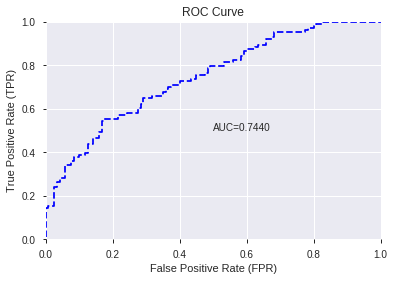

This function is available for GLM models only


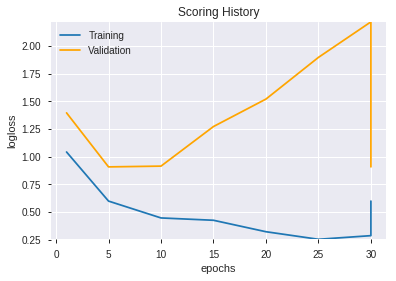

--2019-08-26 21:06:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_205631_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_205631_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLHARAMI',
 'CDLDOJI',
 'CDLSTALLEDPATTERN',
 'hour',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'WILLR_12',
 'ULTOSC',
 'CCI_8',
 'CDLHAMMER',
 'CORREL_30',
 'aroonup_30',
 'SAREXT',
 'dayofweek',
 'days_in_month',
 'TRANGE',
 'CDLINVERTEDHAMMER',
 'STOCHRSI_fastd',
 'Volume',
 'MFI_12',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'aroonup_8',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'MFI_14',
 'BETA_24',
 'CDL3BLACKCROWS',
 'day',
 'WILLR_8',
 'MFI_8',
 'aroondown_30',
 'STOCH_slowd',
 'quarter',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'STOCHF_fastd',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'STOCH_slowk',
 'aroondown_8',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'weekday_name',
 'weekday',
 'CDLUNIQUE3RIVER']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_210654_model_1  0.762783  0.58532              0.331877  0.44876  0.201386

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.453054           1.000000    0.092175
1               ULTOSC             0.320914           0.708334    0.065291
2                  SUB             0.274144           0.605102    0.055775
3   CDLCLOSINGMARUBOZU             0.248904           0.549391    0.050640
4         STOCHF_fastk             0.229923           0.507495    0.046779
5             WILLR_12             0.210593           0.464830    0.042846
6                CCI_8             0.179481           0.396157    0.036516
7          STOCH_slowd             0.176266           0.389062    0.035862
8                  DIV             0.173010           0.381874    0.035199
9            CDLHAMMER             0.139980           0.308970    0.028479
10              SAREXT             0.134663           0.297234    0.027398
11                hour             0.126457           0.279121    0.025728
12       days_in_month             0.125178           0.276298    0.025468
13         HT_DCPERIOD             0.119797           0.264421    0.024373
14   CDLSTALLEDPATTERN             0.116871           0.257962    0.023778
15              TRANGE             0.113461           0.250435    0.023084
16         CDLLONGLINE             0.105944           0.233844    0.021555
17      CDLEVENINGSTAR             0.089971           0.198587    0.018305
18           CDLHARAMI             0.089403           0.197334    0.018189
19             WILLR_8             0.088961           0.196358    0.018099
20             quarter             0.088818           0.196042    0.018070
21        STOCHF_fastd             0.084920           0.187438    0.017277
22         STOCH_slowk             0.084277           0.186020    0.017146
23      CDLSPINNINGTOP             0.083055           0.183322    0.016898
24           aroonup_8             0.082659           0.182447    0.016817
25      STOCHRSI_fastk             0.082122           0.181264    0.016708
26               MFI_8             0.081979           0.180947    0.016679
27              Volume             0.069931           0.154354    0.014228
28   CDL3WHITESOLDIERS             0.066071           0.145835    0.013442
29        aroondown_30             0.065793           0.145220    0.013386
30     CDLUNIQUE3RIVER             0.059898           0.132208    0.012186
31                 day             0.059837           0.132075    0.012174
32         aroondown_8             0.051678           0.114065    0.010514
33             CDLDOJI             0.049531           0.109328    0.010077
34             BETA_24             0.046768           0.103228    0.009515
35      CDL3BLACKCROWS             0.041885           0.092449    0.008522
36      CDLMORNINGSTAR             0.040595           0.089603    0.008259
37  CDLMORNINGDOJISTAR             0.036298           0.080117    0.007385
38      STOCHRSI_fastd             0.035895           0.079228    0.007303
39  CDLEVENINGDOJISTAR             0.034196           0.075479    0.006957
40           CORREL_30             0.027680           0.061096    0.005631
41              MFI_12             0.024987           0.055152    0.005084
42              MFI_14             0.019845           0.043802    0.004037
43   CDLINVERTEDHAMMER             0.019840           0.043792    0.004037
44          AROONOSC_8             0.018082           0.039911    0.003679
45        HT_TRENDMODE             0.017774           0.039231    0.003616
46           dayofweek             0.011727           0.025885    0.002386
47             weekday             0.011683           0.025786    0.002377
48        weekday_name             0.000246           0.000543    0.000050
49          aroonup_30             0.000096           0.000212    0.000020

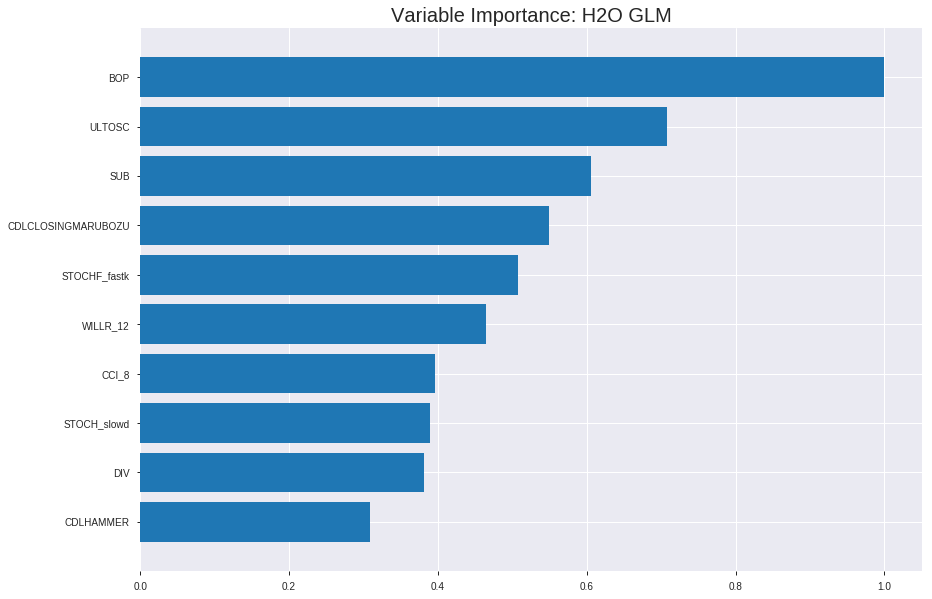

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_210654_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18405759327855678
RMSE: 0.4290193390496013
LogLoss: 0.5442950272679431
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2144.993731790383
Residual deviance: 1696.023304966911
AIC: 1798.023304966911
AUC: 0.7946303644364586
pr_auc: 0.7443861227737578
Gini: 0.5892607288729172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3630496822299588: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      485  370  0.4327   (370.0/855.0)
1      97   606  0.138    (97.0/703.0)
Total  582  976  0.2997   (467.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36305      0.721858  252
max f2                       0.2209       0.833333  316
max f0point5                 0.508761     0.691313  182
max accuracy                 0.459409     0.719512  207
max precision                0.982932     1         0
max recall                   0.0387999    1         387
max specificity              0.982932     1         0
max absolute_mcc             0.402202     0.444151  234
max min_per_class_accuracy   0.470577     0.71462   202
max mean_per_class_accuracy  0.402202     0.720863  234

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.916648           2.0777    2.0777             0.9375           0.945154   0.9375                      0.945154            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.892626           1.93919   2.00845            0.875            0.9042     0.90625                     0.924677            0.0199147       0.0412518                  93.9189   100.845
    3        0.0301669                   0.866024           1.92072   1.98045            0.866667         0.880902   0.893617                    0.910707            0.0184922       0.059744                   92.0721   98.0449
    4        0.0404365                   0.850254           1.66216   1.89961            0.75             0.859552   0.857143                    0.897715            0.0170697       0.0768137                  66.2162   89.9614
    5        0.0500642                   0.832413           2.06847   1.93209            0.933333         0.838583   0.871795                    0.886343            0.0199147       0.0967283                  106.847   93.2086
    6        0.100128                    0.763749           1.84685   1.88947            0.833333         0.795173   0.852564                    0.840758            0.0924609       0.189189                   84.6847   88.9466
    7        0.150193                    0.711439           1.79002   1.85632            0.807692         0.738463   0.837607                    0.80666             0.0896159       0.278805                   79.0021   85.6318
    8        0.200257                    0.678719           1.64796   1.80423            0.74359          0.694933   0.814103                    0.778728            0.0825036       0.361309                   64.7956   80.4227
    9        0.300385                    0.596878           1.32121   1.64322            0.596154         0.637765   0.741453                    0.731741            0.13229         0.493599                   32.1206   64.322
    10       0.399872                    0.52288            1.34403   1.56878            0.606452         0.563242   0.707865                    0.689819            0.133713        0.627312                   34.4028   56.8782
    11       0.5                         0.449175           1.12231   1.47937            0.50641          0.487983   0.667522                    0.6494              0.112376        0.739687                   12.2315   47.9374
    12       0.600128                    0.381041           0.951836  1.39136            0.429487         0.41472    0.627807                    0.610245            0.0953058       0.834993                   -4.81635  39.1357
    13       0.699615                    0.30114            0.757803  1.30126            0.341935         0.341257   0.587156                    0.571994            0.0753912       0.910384                   -24.2197  30.1265
    14       0.799743                    0.22332            0.497228  1.2006             0.224359         0.261978   0.541734                    0.53318             0.0497866       0.960171                   -50.2772  20.0599
    15       0.899872                    0.128764           0.269924  1.09704            0.121795         0.175254   0.495007                    0.493354            0.027027        0.987198                   -73.0076  9.70428
    16       1                           7.97867e-05        0.127859  1                  0.0576923        0.0725526  0.45122                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19303506160188721
RMSE: 0.43935755553067163
LogLoss: 0.573268094235059
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 621.7697307743217
Residual deviance: 511.3551400576726
AIC: 613.3551400576725
AUC: 0.7844645550527903
pr_auc: 0.7455247721288294
Gini: 0.5689291101055807
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371874582874323: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  83   0.3689   (83.0/225.0)
1      36   185  0.1629   (36.0/221.0)
Total  178  268  0.2668   (119.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371875     0.756646  238
max f2                       0.226567     0.852365  303
max f0point5                 0.490912     0.739261  174
max accuracy                 0.433575     0.73991   203
max precision                0.953654     1         0
max recall                   0.0192253    1         394
max specificity              0.953654     1         0
max absolute_mcc             0.420086     0.48102   211
max min_per_class_accuracy   0.447729     0.733333  199
max mean_per_class_accuracy  0.420086     0.740171  211

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 42.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.893705           2.0181    2.0181             1                0.919626   1                           0.919626            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.848266           2.0181    2.0181             1                0.867809   1                           0.896596            0.0180995       0.040724                   101.81    101.81
    3        0.0313901                   0.817114           2.0181    2.0181             1                0.832997   1                           0.873882            0.0226244       0.0633484                  101.81    101.81
    4        0.0403587                   0.790222           1.51357   1.90598            0.75             0.800637   0.944444                    0.857605            0.0135747       0.0769231                  51.3575   90.5983
    5        0.0515695                   0.759967           0.80724   1.66713            0.4              0.775388   0.826087                    0.839732            0.00904977      0.0859729                  -19.276   66.7126
    6        0.100897                    0.708081           1.55944   1.61448            0.772727         0.732955   0.8                         0.78753             0.0769231       0.162896                   55.9441   61.448
    7        0.150224                    0.682817           1.37598   1.53617            0.681818         0.695117   0.761194                    0.757186            0.0678733       0.230769                   37.5977   53.6165
    8        0.201794                    0.632993           1.49164   1.52479            0.73913          0.653243   0.755556                    0.730622            0.0769231       0.307692                   49.1639   52.4786
    9        0.300448                    0.580437           1.51357   1.5211             0.75             0.608174   0.753731                    0.690416            0.149321        0.457014                   51.3575   52.1105
    10       0.401345                    0.521657           1.61448   1.54458            0.8              0.550109   0.765363                    0.655143            0.162896        0.61991                    61.448    54.4579
    11       0.5                         0.446987           1.19251   1.47511            0.590909         0.484457   0.730942                    0.621465            0.117647        0.737557                   19.2513   47.5113
    12       0.600897                    0.371875           0.986626  1.39309            0.488889         0.405847   0.690299                    0.58526             0.0995475       0.837104                   -1.33736  39.3091
    13       0.699552                    0.302712           0.642123  1.28719            0.318182         0.335593   0.637821                    0.550051            0.0633484       0.900452                   -35.7877  28.7185
    14       0.800448                    0.192675           0.493313  1.18712            0.244444         0.241638   0.588235                    0.511175            0.0497738       0.950226                   -50.6687  18.7117
    15       0.899103                    0.101385           0.183464  1.07699            0.0909091        0.139408   0.533666                    0.470383            0.0180995       0.968326                   -81.6536  7.69908
    16       1                           0.0014574          0.313927  1                  0.155556         0.0527785  0.495516                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:06:55  0.000 sec   2            19        51            1.35833           1.37599
    2019-08-26 21:06:55  0.012 sec   4            12        51            1.34855           1.36649
    2019-08-26 21:06:55  0.023 sec   6            7.3       51            1.33459           1.35302
    2019-08-26 21:06:55  0.033 sec   8            4.5       51            1.31566           1.335
    2019-08-26 21:06:55  0.044 sec   10           2.8       51            1.29145           1.31233
    2019-08-26 21:06:55  0.054 sec   12           1.7       51            1.26267           1.28596
    2019-08-26 21:06:55  0.064 sec   14           1.1       51            1.23108           1.25772
    2019-08-26 21:06:55  0.074 sec   16           0.67      51            1.19931           1.23004
    2019-08-26 21:06:55  0.084 sec   18           0.42      51            1.17008           1.20525
    2019-08-26 21:06:55  0.094 sec   20           0.26      51            1.14532           1.18485
    2019-08-26 21:06:55  0.104 sec   22           0.16      51            1.12583           1.16939
    2019-08-26 21:06:55  0.114 sec   24           0.1       51            1.11133           1.15858
    2019-08-26 21:06:55  0.123 sec   26           0.062     51            1.10093           1.15172
    2019-08-26 21:06:55  0.134 sec   28           0.039     51            1.09365           1.14798
    2019-08-26 21:06:55  0.144 sec   30           0.024     51            1.08859           1.14654
    2019-08-26 21:06:55  0.154 sec   32           0.015     51            1.08505           1.14668
    2019-08-26 21:06:55  0.164 sec   34           0.0093    51            1.08253           1.14787
    2019-08-26 21:06:55  0.183 sec   36           0.0058    51            1.08069           1.14979
    2019-08-26 21:06:55  0.194 sec   38           0.0036    51            1.07933           1.15235
    2019-08-26 21:06:55  0.205 sec   40           0.0022    51            1.07833           1.15555

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7045454545454545)

('auc', 0.7627831715210356)

('logloss', 0.5853200072166287)

('mean_per_class_error', 0.29000809061488675)

('rmse', 0.4487604518076394)

('mse', 0.20138594310659666)

glm prediction progress: |████████████████████████████████████████████████| 100%


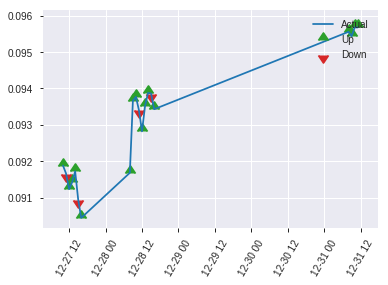


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20138594310659666
RMSE: 0.4487604518076394
LogLoss: 0.5853200072166287
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 307.9486967302692
Residual deviance: 261.0527232186164
AIC: 363.0527232186164
AUC: 0.7627831715210356
pr_auc: 0.7244053945672988
Gini: 0.5255663430420712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40105941617505675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   68   0.5667   (68.0/120.0)
1      10   93   0.0971   (10.0/103.0)
Total  62   161  0.3498   (78.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401059     0.704545  160
max f2                       0.294603     0.830537  183
max f0point5                 0.631966     0.704698  85
max accuracy                 0.631966     0.717489  85
max precision                0.949264     1         0
max recall                   0.0677238    1         219
max specificity              0.949264     1         0
max absolute_mcc             0.631966     0.430162  85
max min_per_class_accuracy   0.552226     0.675     108
max mean_per_class_accuracy  0.631966     0.709992  85

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.926078           2.16505   2.16505            1                0.938481  1                           0.938481            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.910084           2.16505   2.16505            1                0.915325  1                           0.929218            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.905519           1.08252   1.85576            0.5              0.906496  0.857143                    0.922726            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.889069           2.16505   1.92449            1                0.897913  0.888889                    0.917212            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.877018           2.16505   1.98463            1                0.884758  0.916667                    0.909099            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.814946           1.96823   1.97678            0.909091         0.846017  0.913043                    0.878929            0.0970874       0.203883                   96.8226   97.6783
    7        0.152466                    0.775508           0.78729   1.59195            0.363636         0.790699  0.735294                    0.850384            0.038835        0.242718                   -21.271   59.1947
    8        0.201794                    0.742815           1.7714    1.63581            0.818182         0.758529  0.755556                    0.827931            0.0873786       0.330097                   77.1403   63.5814
    9        0.300448                    0.678261           1.57458   1.61571            0.727273         0.707792  0.746269                    0.788482            0.15534         0.485437                   57.4581   61.5708
    10       0.399103                    0.62142            1.37776   1.55689            0.636364         0.652292  0.719101                    0.754817            0.135922        0.621359                   37.7758   55.6889
    11       0.502242                    0.538293           0.75306   1.39182            0.347826         0.582797  0.642857                    0.719492            0.0776699       0.699029                   -24.694   39.1817
    12       0.600897                    0.467579           0.984113  1.32488            0.454545         0.496846  0.61194                     0.682938            0.0970874       0.796117                   -1.5887   32.488
    13       0.699552                    0.410392           0.78729   1.24907            0.363636         0.438657  0.576923                    0.648488            0.0776699       0.873786                   -21.271   24.9066
    14       0.798206                    0.306879           0.688879  1.17983            0.318182         0.362755  0.544944                    0.613173            0.0679612       0.941748                   -31.1121  17.983
    15       0.896861                    0.169393           0.393645  1.09335            0.181818         0.247545  0.505                       0.572954            0.038835        0.980583                   -60.6355  9.33495
    16       1                           0.00785247         0.188265  1                  0.0869565        0.107534  0.461883                    0.524951           

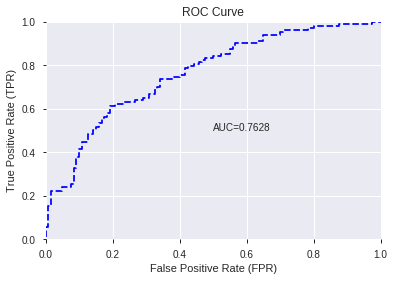

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


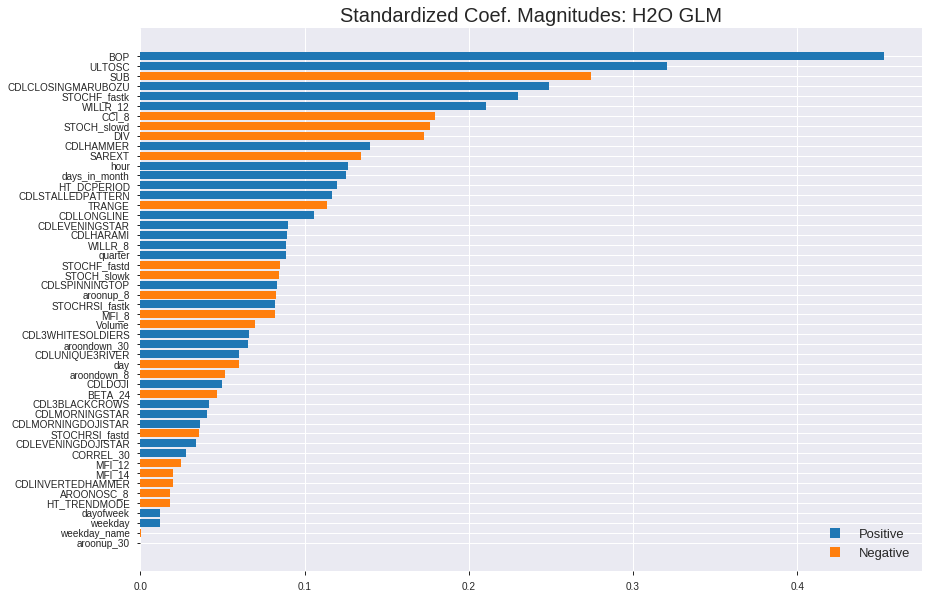

'log_likelihood'
--2019-08-26 21:07:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_210654_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_210654_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'ULTOSC',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_12',
 'CCI_8',
 'STOCH_slowd',
 'DIV',
 'CDLHAMMER',
 'SAREXT',
 'hour',
 'days_in_month',
 'HT_DCPERIOD',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'CDLLONGLINE',
 'CDLEVENINGSTAR',
 'CDLHARAMI',
 'WILLR_8',
 'quarter',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLSPINNINGTOP',
 'aroonup_8',
 'STOCHRSI_fastk',
 'MFI_8',
 'Volume',
 'CDL3WHITESOLDIERS',
 'aroondown_30',
 'CDLUNIQUE3RIVER',
 'day',
 'aroondown_8',
 'CDLDOJI',
 'BETA_24',
 'CDL3BLACKCROWS',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastd',
 'CDLEVENINGDOJISTAR',
 'CORREL_30',
 'MFI_12',
 'MFI_14',
 'CDLINVERTEDHAMMER',
 'AROONOSC_8',
 'HT_TRENDMODE',
 'dayofweek',
 'weekday',
 'weekday_name',
 'aroonup_30']

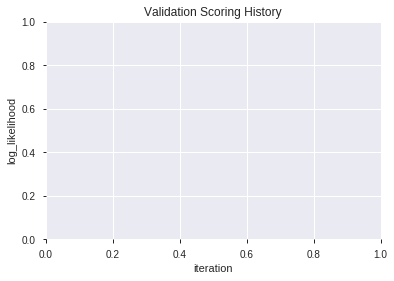

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_210704_model_2  0.767476  0.575076              0.293649  0.443025  0.196271
1  XGBoost_grid_1_AutoML_20190826_210704_model_3  0.761974  0.581186              0.325607  0.446106  0.199011
2  XGBoost_grid_1_AutoML_20190826_210704_model_6  0.756553  0.585968              0.294984  0.448531  0.201180
3               XGBoost_1_AutoML_20190826_210704  0.755178  0.583479              0.302023  0.447649  0.200389
4               XGBoost_3_AutoML_20190826_210704  0.754369  0.585592              0.321440  0.448575  0.201219
5  XGBoost_grid_1_AutoML_20190826_210704_model_1  0.752751  0.590119              0.294337  0.450198  0.202678
6  XGBoost_grid_1_AutoML_20190826_210704_model_4  0.752670  0.590689              0.349272  0.449954  0.202459
7               XGBoost_2_AutoML_20190826_210704  0.750728  0.594163              0.317233  0.451631  0.203971
8  XGBoost_grid_1_AutoML_20190826_210704_model_7  0.742476  0.604030              0.295672  0.456834  0.208697
9  XGBoost_grid_1_AutoML_20190826_210704_model_5  0.736570  0.625115              0.310316  0.463481  0.214814

variable  relative_importance  scaled_importance  percentage
0                  BOP          2122.985352           1.000000    0.249559
1                  DIV           751.567505           0.354014    0.088347
2         STOCHF_fastk           582.113953           0.274196    0.068428
3                 hour           499.418793           0.235244    0.058707
4               Volume           423.100800           0.199295    0.049736
5               TRANGE           401.466400           0.189105    0.047193
6                  SUB           313.447937           0.147645    0.036846
7               SAREXT           267.848694           0.126166    0.031486
8                CCI_8           233.391556           0.109936    0.027435
9       STOCHRSI_fastd           206.571945           0.097303    0.024283
10              ULTOSC           204.810699           0.096473    0.024076
11             BETA_24           189.403763           0.089216    0.022265
12         STOCH_slowk           180.198669           0.084880    0.021183
13         HT_DCPERIOD           178.308228           0.083989    0.020960
14  CDLCLOSINGMARUBOZU           161.084106           0.075876    0.018936
15         STOCH_slowd           155.364105           0.073182    0.018263
16            WILLR_12           147.075958           0.069278    0.017289
17           CDLHAMMER           144.785919           0.068199    0.017020
18               MFI_8           122.159195           0.057541    0.014360
19              MFI_12           120.899986           0.056948    0.014212
20                 day           113.251343           0.053345    0.013313
21              MFI_14           106.220055           0.050033    0.012486
22      STOCHRSI_fastk            91.093468           0.042908    0.010708
23           aroonup_8            81.763245           0.038513    0.009611
24         aroondown_8            78.444359           0.036950    0.009221
25          aroonup_30            72.598320           0.034196    0.008534
26          AROONOSC_8            68.422729           0.032229    0.008043
27           CORREL_30            67.425919           0.031760    0.007926
28        aroondown_30            63.897224           0.030098    0.007511
29             WILLR_8            54.457512           0.025651    0.006402
30             quarter            52.539288           0.024748    0.006176
31       days_in_month            47.192806           0.022229    0.005548
32      CDLSPINNINGTOP            36.435349           0.017162    0.004283
33        STOCHF_fastd            34.978321           0.016476    0.004112
34           CDLHARAMI            34.342827           0.016177    0.004037
35        weekday_name            30.835932           0.014525    0.003625
36   CDLSTALLEDPATTERN            26.040882           0.012266    0.003061
37           dayofweek            24.453104           0.011518    0.002874
38             CDLDOJI             6.250390           0.002944    0.000735
39         CDLLONGLINE             4.180976           0.001969    0.000491
40        HT_TRENDMODE             3.747174           0.001765    0.000440
41             weekday             2.373090           0.001118    0.000279

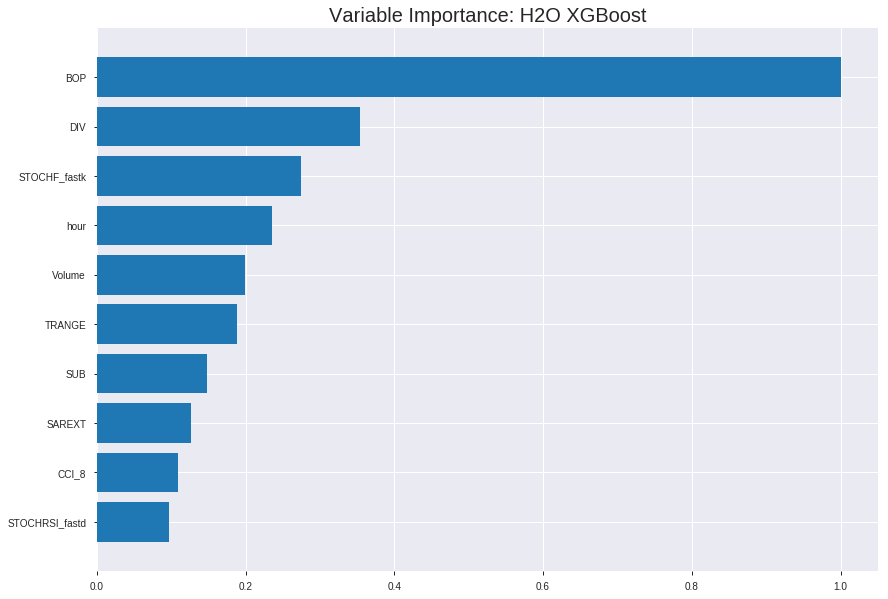

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_210704_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1370919824678767
RMSE: 0.3702593448758272
LogLoss: 0.440116943731936
Mean Per-Class Error: 0.16987513829619094
AUC: 0.9107725453985842
pr_auc: 0.8978163296942672
Gini: 0.8215450907971684
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5167754590511322: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      736  119  0.1392   (119.0/855.0)
1      141  562  0.2006   (141.0/703.0)
Total  877  681  0.1669   (260.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516775     0.812139  179
max f2                       0.310197     0.881435  280
max f0point5                 0.626        0.830361  123
max accuracy                 0.516775     0.833119  179
max precision                0.876604     1         0
max recall                   0.109998     1         383
max specificity              0.876604     1         0
max absolute_mcc             0.516775     0.662362  179
max min_per_class_accuracy   0.494182     0.819346  190
max mean_per_class_accuracy  0.516775     0.830125  179

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.8422             2.21622   2.21622            1                0.85575   1                           0.85575             0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.831046           2.21622   2.21622            1                0.836756  1                           0.846253            0.0227596       0.0455192                  121.622   121.622
    3        0.0301669                   0.821653           2.21622   2.21622            1                0.826065  1                           0.83981             0.0213371       0.0668563                  121.622   121.622
    4        0.0404365                   0.810504           2.21622   2.21622            1                0.815913  1                           0.833741            0.0227596       0.0896159                  121.622   121.622
    5        0.0500642                   0.800983           2.21622   2.21622            1                0.806237  1                           0.828451            0.0213371       0.110953                   121.622   121.622
    6        0.100128                    0.763272           2.15939   2.1878             0.974359         0.781155  0.987179                    0.804803            0.108108        0.219061                   115.939   118.78
    7        0.150193                    0.732313           2.07415   2.14992            0.935897         0.747901  0.970085                    0.785836            0.103841        0.322902                   107.415   114.992
    8        0.200257                    0.695782           2.07415   2.13098            0.935897         0.714897  0.961538                    0.768101            0.103841        0.426743                   107.415   113.098
    9        0.300385                    0.619177           1.77581   2.01259            0.801282         0.657333  0.90812                     0.731178            0.177809        0.604552                   77.5814   101.259
    10       0.399872                    0.54238            1.45841   1.87471            0.658065         0.582338  0.845907                    0.694147            0.145092        0.749644                   45.8413   87.4713
    11       0.5                         0.464524           1.00866   1.70128            0.455128         0.505191  0.767651                    0.656308            0.100996        0.85064                    0.866251  70.128
    12       0.600128                    0.369628           0.781358  1.5478             0.352564         0.416873  0.698396                    0.616359            0.0782361       0.928876                   -21.8642  54.7796
    13       0.699615                    0.282728           0.457541  1.39276            0.206452         0.32243   0.62844                     0.574562            0.0455192       0.974395                   -54.2459  39.276
    14       0.799743                    0.1911             0.113652  1.23261            0.0512821        0.234094  0.55618                     0.531935            0.0113798       0.985775                   -88.6348  23.2615
    15       0.899872                    0.119834           0.113652  1.10811            0.0512821        0.146931  0.5                         0.489096            0.0113798       0.997155                   -88.6348  10.8108
    16       1                           0.0879587          0.028413  1                  0.0128205        0.105208  0.45122                     0.450658            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19344288761307699
RMSE: 0.43982142695993903
LogLoss: 0.5725267034526904
Mean Per-Class Error: 0.2614077425842132
AUC: 0.7937456008044244
pr_auc: 0.7466234002411677
Gini: 0.5874912016088487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3335973620414734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  82   0.3644   (82.0/225.0)
1      35   186  0.1584   (35.0/221.0)
Total  178  268  0.2623   (117.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333597     0.760736  241
max f2                       0.155901     0.846709  328
max f0point5                 0.534277     0.749129  141
max accuracy                 0.333597     0.737668  241
max precision                0.828591     1         0
max recall                   0.0991223    1         393
max specificity              0.828591     1         0
max absolute_mcc             0.333597     0.487188  241
max min_per_class_accuracy   0.400825     0.723982  199
max mean_per_class_accuracy  0.333597     0.738592  241

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 41.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.77744            1.61448   1.61448            0.8              0.802276  0.8                         0.802276            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.766039           1.51357   1.56963            0.75             0.77047   0.777778                    0.78814             0.0135747       0.0316742                  51.3575   56.9633
    3        0.0313901                   0.741449           1.21086   1.4415             0.6              0.753436  0.714286                    0.775746            0.0135747       0.0452489                  21.086    44.15
    4        0.0403587                   0.726725           1.51357   1.45752            0.75             0.737574  0.722222                    0.767263            0.0135747       0.0588235                  51.3575   45.7516
    5        0.0515695                   0.722955           1.61448   1.49164            0.8              0.724923  0.73913                     0.758059            0.0180995       0.0769231                  61.448    49.1639
    6        0.100897                    0.694946           1.92637   1.70417            0.954545         0.707756  0.844444                    0.733467            0.0950226       0.171946                   92.6368   70.4173
    7        0.150224                    0.664946           1.46771   1.62653            0.727273         0.67801   0.80597                     0.715257            0.0723982       0.244344                   46.7709   62.6528
    8        0.201794                    0.637708           1.66713   1.6369             0.826087         0.650691  0.811111                    0.698757            0.0859729       0.330317                   66.7126   63.6903
    9        0.300448                    0.581181           1.69704   1.65665            0.840909         0.611238  0.820896                    0.670019            0.167421        0.497738                   69.7038   65.6649
    10       0.401345                    0.489604           1.16601   1.5333             0.577778         0.534695  0.759777                    0.635999            0.117647        0.615385                   16.6013   53.3305
    11       0.5                         0.398645           1.10078   1.44796            0.545455         0.44465   0.717489                    0.598244            0.108597        0.723982                   10.0782   44.7964
    12       0.600897                    0.333597           1.16601   1.40062            0.577778         0.367758  0.69403                     0.559543            0.117647        0.841629                   16.6013   40.0621
    13       0.699552                    0.256539           0.596257  1.28719            0.295455         0.297576  0.637821                    0.522599            0.0588235       0.900452                   -40.3743  28.7185
    14       0.800448                    0.163839           0.448467  1.18146            0.222222         0.204896  0.585434                    0.482552            0.0452489       0.945701                   -55.1533  18.1464
    15       0.899103                    0.124326           0.229329  1.07699            0.113636         0.13875   0.533666                    0.444829            0.0226244       0.968326                   -77.0671  7.69908
    16       1                           0.0923833          0.313927  1                  0.155556         0.109118  0.495516                    0.410956            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:07:08  0.661 sec   0                  0.5              0.693147            0.5             0                  1                0.54878                          0.5                0.693147              0.5               0                    1                  0.504484
    2019-08-26 21:07:09  0.739 sec   5                  0.47271          0.639763            0.846473        0.6698             1.98087          0.225289                         0.480782           0.655231              0.776209          0.736767             1.61448            0.295964
    2019-08-26 21:07:09  0.785 sec   10                 0.452037         0.600202            0.858032        0.800561           2.09309          0.232349                         0.467101           0.628389              0.783952          0.733069             1.61448            0.293722
    2019-08-26 21:07:09  0.835 sec   15                 0.43644          0.570288            0.864654        0.828521           2.09957          0.229782                         0.458411           0.611083              0.792539          0.745363             1.21086            0.293722
    2019-08-26 21:07:09  0.886 sec   20                 0.423944         0.546024            0.871229        0.837485           2.0777           0.231065                         0.452418           0.598887              0.796008          0.749726             1.21086            0.286996
    2019-08-26 21:07:09  0.945 sec   25                 0.414473         0.527346            0.876118        0.848747           2.21622          0.214377                         0.44812            0.589896              0.797265          0.749181             1.21086            0.280269
    2019-08-26 21:07:09  1.003 sec   30                 0.406319         0.511031            0.880698        0.858324           2.21622          0.213094                         0.445235           0.583726              0.798441          0.752826             1.21086            0.278027
    2019-08-26 21:07:09  1.066 sec   35                 0.399286         0.49717             0.887001        0.866772           2.21622          0.210526                         0.443041           0.579188              0.798482          0.758988             2.0181             0.29148
    2019-08-26 21:07:09  1.134 sec   40                 0.392937         0.4846              0.891289        0.874859           2.21622          0.207959                         0.442286           0.577318              0.796058          0.751423             2.0181             0.289238
    2019-08-26 21:07:09  1.197 sec   45                 0.387485         0.473672            0.895409        0.878187           2.21622          0.206033                         0.440857           0.574704              0.796561          0.754676             2.0181             0.275785
    2019-08-26 21:07:09  1.256 sec   50                 0.382672         0.464156            0.899431        0.883218           2.21622          0.195764                         0.440979           0.57486               0.794681          0.748777             1.61448            0.284753
    2019-08-26 21:07:09  1.315 sec   55                 0.37871          0.456317            0.902937        0.889304           2.21622          0.191271                         0.440558           0.573923              0.794862          0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2122.9853515625        1.0                    0.24955899379755922
DIV           751.5675048828125      0.354014456260692      0.08834749149420834
STOCHF_fastk  582.1139526367188      0.2741959346108006     0.06842806154485273
hour          499.4187927246094      0.23524363574013415    0.05870716503258742
Volume        423.1007995605469      0.1992952043918476     0.04973591067670839
---           ---                    ---                    ---
dayofweek     24.45310401916504      0.011518263185927191   0.0028744861709754585
CDLDOJI       6.250389575958252      0.0029441510613146793  0.0007347393764497074
CDLLONGLINE   4.180975914001465      0.0019693851919064353  0.000491477786891983
HT_TRENDMODE  3.7471742630004883     0.0017650495139981057  0.0004404839807162382
weekday       2.373089551925659      0.0011178077842972796  0.0002789589859083082


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.721311475409836)

('auc', 0.7674757281553398)

('logloss', 0.5750757245315883)

('mean_per_class_error', 0.29364886731391593)

('rmse', 0.4430245488019123)

('mse', 0.19627075084113793)

xgboost prediction progress: |████████████████████████████████████████████| 100%


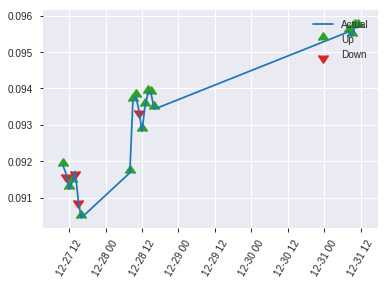


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19627075084113793
RMSE: 0.4430245488019123
LogLoss: 0.5750757245315883
Mean Per-Class Error: 0.29364886731391593
AUC: 0.7674757281553398
pr_auc: 0.7240740412795704
Gini: 0.5349514563106796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3599148690700531: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   53   0.4417   (53.0/120.0)
1      15   88   0.1456   (15.0/103.0)
Total  82   141  0.3049   (68.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359915     0.721311  140
max f2                       0.173459     0.83887   189
max f0point5                 0.611742     0.685579  79
max accuracy                 0.55627      0.704036  94
max precision                0.850781     1         0
max recall                   0.0996858    1         217
max specificity              0.850781     1         0
max absolute_mcc             0.359915     0.426707  140
max min_per_class_accuracy   0.506784     0.679612  107
max mean_per_class_accuracy  0.359915     0.706351  140

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 46.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.829521           2.16505   2.16505            1                0.838356  1                           0.838356            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.827673           2.16505   2.16505            1                0.828113  1                           0.834259            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.822559           2.16505   2.16505            1                0.827112  1                           0.832217            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.814227           1.08252   1.92449            0.5              0.819748  0.888889                    0.829446            0.00970874      0.0776699                  8.25243   92.4488
    5        0.0538117                   0.808345           2.16505   1.98463            1                0.811065  0.916667                    0.824851            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.766097           1.37776   1.69439            0.636364         0.783968  0.782609                    0.805298            0.0679612       0.174757                   37.7758   69.4386
    7        0.152466                    0.722484           1.96823   1.78298            0.909091         0.741211  0.823529                    0.784564            0.0970874       0.271845                   96.8226   78.2981
    8        0.201794                    0.695913           1.57458   1.73204            0.727273         0.7087    0.8                         0.766019            0.0776699       0.349515                   57.4581   73.2039
    9        0.300448                    0.63936            1.27935   1.58339            0.590909         0.663453  0.731343                    0.732341            0.126214        0.475728                   27.9347   58.3394
    10       0.399103                    0.577451           1.18094   1.48391            0.545455         0.611609  0.685393                    0.702497            0.116505        0.592233                   18.0936   48.391
    11       0.502242                    0.488271           0.941325  1.37249            0.434783         0.532693  0.633929                    0.667627            0.0970874       0.68932                    -5.86745  37.2486
    12       0.600897                    0.372278           1.27935   1.35719            0.590909         0.42052   0.626866                    0.627057            0.126214        0.815534                   27.9347   35.7195
    13       0.699552                    0.317201           0.885702  1.2907             0.409091         0.346567  0.596154                    0.587501            0.0873786       0.902913                   -11.4298  29.0702
    14       0.798206                    0.229503           0.196823  1.1555             0.0909091        0.260953  0.533708                    0.547141            0.0194175       0.92233                    -80.3177  15.5503
    15       0.896861                    0.142357           0.590468  1.09335            0.272727         0.178915  0.505                       0.506636            0.0582524       0.980583                   -40.9532  9.33495
    16       1                           0.0893853          0.188265  1                  0.0869565        0.118355  0.461883                    0.466589          

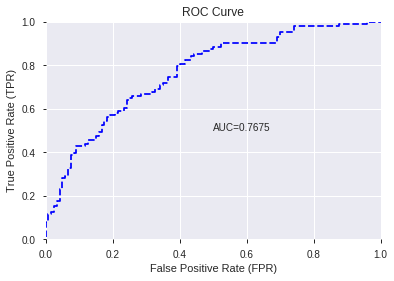

This function is available for GLM models only


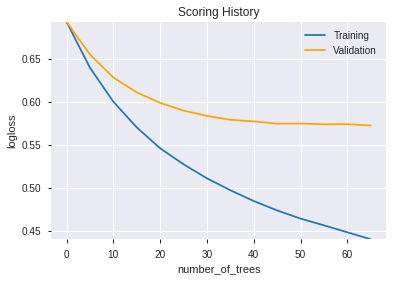

--2019-08-26 21:07:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_210704_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_210704_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'hour',
 'Volume',
 'TRANGE',
 'SUB',
 'SAREXT',
 'CCI_8',
 'STOCHRSI_fastd',
 'ULTOSC',
 'BETA_24',
 'STOCH_slowk',
 'HT_DCPERIOD',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowd',
 'WILLR_12',
 'CDLHAMMER',
 'MFI_8',
 'MFI_12',
 'day',
 'MFI_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'aroondown_8',
 'aroonup_30',
 'AROONOSC_8',
 'CORREL_30',
 'aroondown_30',
 'WILLR_8',
 'quarter',
 'days_in_month',
 'CDLSPINNINGTOP',
 'STOCHF_fastd',
 'CDLHARAMI',
 'weekday_name',
 'CDLSTALLEDPATTERN',
 'dayofweek',
 'CDLDOJI',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'weekday']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_210725_model_1  0.758252  0.587567              0.299879  0.449196  0.201777

variable  relative_importance  scaled_importance    percentage
0                          BOP         2.574143e-01           1.000000  3.528807e-02
1           CDLCLOSINGMARUBOZU         1.639777e-01           0.637019  2.247916e-02
2                  CDLLONGLINE         1.299296e-01           0.504749  1.781162e-02
3                          SUB         1.160630e-01           0.450880  1.591069e-02
4                          DIV         1.085323e-01           0.421625  1.487834e-02
...                        ...                  ...                ...           ...
1032  BBANDS_middleband_14_1_4         1.215145e-05           0.000047  1.665802e-06
1033  BBANDS_middleband_12_1_4         7.936325e-06           0.000031  1.087964e-06
1034  BBANDS_middleband_14_1_5         7.203429e-06           0.000028  9.874942e-07
1035  BBANDS_middleband_12_1_5         3.043577e-06           0.000012  4.172339e-07
1036                   MA_12_1         4.903630e-07           0.000002  6.722224e-08

[1037 rows x 4 columns]

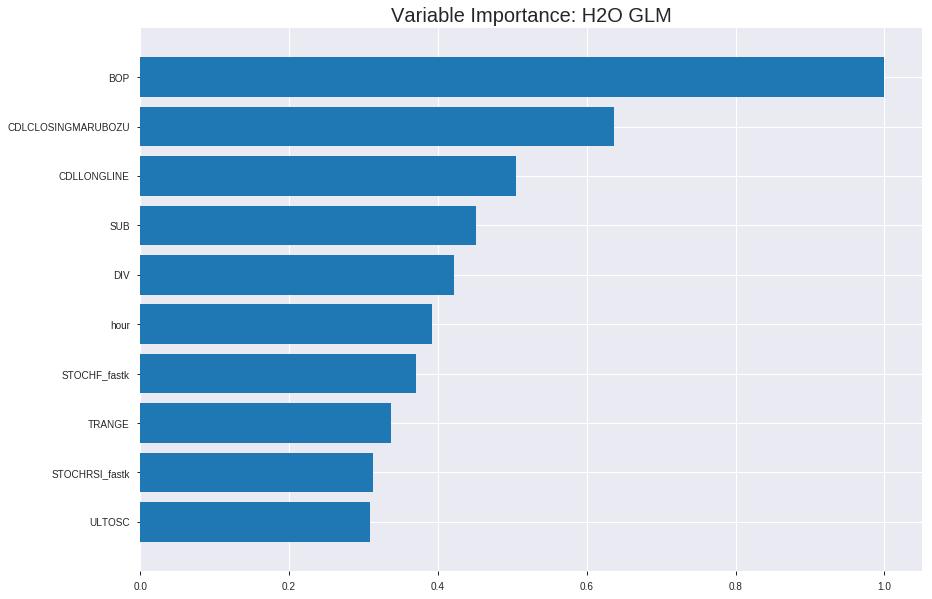

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_210725_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18243460630055
RMSE: 0.42712364287235377
LogLoss: 0.5430177860883015
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2144.993731790383
Residual deviance: 1692.0434214511474
AIC: 3768.0434214511474
AUC: 0.8064477219601874
pr_auc: 0.7615373888561265
Gini: 0.6128954439203749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4085460255101445: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      537  318  0.3719   (318.0/855.0)
1      123  580  0.175    (123.0/703.0)
Total  660  898  0.2831   (441.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408546     0.724547  226
max f2                       0.265683     0.840948  302
max f0point5                 0.588078     0.707605  124
max accuracy                 0.502626     0.72914   171
max precision                0.927762     1         0
max recall                   0.11802      1         368
max specificity              0.927762     1         0
max absolute_mcc             0.428395     0.457853  215
max min_per_class_accuracy   0.466375     0.726316  193
max mean_per_class_accuracy  0.452194     0.729587  201

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.861864           2.21622   2.21622            1                0.880941  1                           0.880941            0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.84041            1.80068   2.00845            0.8125           0.852363  0.90625                     0.866652            0.0184922       0.0412518                  80.0676   100.845
    3        0.0301669                   0.820554           1.92072   1.98045            0.866667         0.832352  0.893617                    0.855705            0.0184922       0.059744                   92.0721   98.0449
    4        0.0404365                   0.797625           1.93919   1.96997            0.875            0.808522  0.888889                    0.843722            0.0199147       0.0796586                  93.9189   96.997
    5        0.0500642                   0.784946           2.21622   2.01733            1                0.790847  0.910256                    0.833554            0.0213371       0.100996                   121.622   101.733
    6        0.100128                    0.720277           1.87526   1.94629            0.846154         0.754086  0.878205                    0.79382             0.0938834       0.194879                   87.526    94.6292
    7        0.150193                    0.674452           1.81843   1.90367            0.820513         0.699113  0.858974                    0.762251            0.0910384       0.285917                   81.8434   90.3673
    8        0.200257                    0.637097           1.61954   1.83264            0.730769         0.655779  0.826923                    0.735633            0.0810811       0.366999                   61.9543   83.264
    9        0.300385                    0.571819           1.44906   1.70478            0.653846         0.605924  0.769231                    0.692397            0.145092        0.512091                   44.9064   70.4782
    10       0.399872                    0.511056           1.25824   1.59368            0.567742         0.541088  0.719101                    0.654752            0.125178        0.637269                   25.8239   59.3684
    11       0.5                         0.452116           1.13652   1.50213            0.512821         0.481238  0.677792                    0.620005            0.113798        0.751067                   13.6521   50.2134
    12       0.600128                    0.395966           0.866597  1.3961             0.391026         0.423843  0.629947                    0.587276            0.086771        0.837838                   -13.3403  39.6098
    13       0.699615                    0.331261           0.70061   1.2972             0.316129         0.362689  0.585321                    0.555339            0.0697013       0.907539                   -29.939   29.7198
    14       0.799743                    0.25623            0.61088   1.21127            0.275641         0.297799  0.546549                    0.523095            0.0611664       0.968706                   -38.912   21.1271
    15       0.899872                    0.169634           0.170478  1.09546            0.0769231        0.214367  0.494294                    0.488743            0.0170697       0.985775                   -82.9522  9.54621
    16       1                           0.00102967         0.142065  1                  0.0641026        0.11399   0.45122                     0.45122            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20715635915386488
RMSE: 0.4551443278278494
LogLoss: 0.602642134850201
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 621.7697307743217
Residual deviance: 537.5567842863793
AIC: 2613.5567842863793
AUC: 0.7615384615384615
pr_auc: 0.7266291907387429
Gini: 0.523076923076923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3210809907173113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  98   0.4356   (98.0/225.0)
1      33   188  0.1493   (33.0/221.0)
Total  160  286  0.2937   (131.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321081     0.741617  253
max f2                       0.171595     0.84793   329
max f0point5                 0.491172     0.698225  140
max accuracy                 0.342897     0.706278  245
max precision                0.891828     1         0
max recall                   0.0451218    1         390
max specificity              0.891828     1         0
max absolute_mcc             0.321081     0.432734  253
max min_per_class_accuracy   0.418954     0.688889  195
max mean_per_class_accuracy  0.321081     0.707562  253

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 40.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.821108           1.61448   1.61448            0.8              0.859515  0.8                         0.859515            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.797672           2.0181    1.79387            1                0.804503  0.888889                    0.835065            0.0180995       0.0361991                  101.81    79.3866
    3        0.0313901                   0.766371           1.61448   1.7298             0.8              0.78324   0.857143                    0.816556            0.0180995       0.0542986                  61.448    72.98
    4        0.0403587                   0.754551           2.0181    1.79387            1                0.757213  0.888889                    0.803369            0.0180995       0.0723982                  101.81    79.3866
    5        0.0515695                   0.738431           1.61448   1.75487            0.8              0.749923  0.869565                    0.79175             0.0180995       0.0904977                  61.448    75.4869
    6        0.100897                    0.676675           1.37598   1.56963            0.681818         0.710321  0.777778                    0.751941            0.0678733       0.158371                   37.5977   56.9633
    7        0.150224                    0.630554           1.7429    1.62653            0.863636         0.658469  0.80597                     0.721248            0.0859729       0.244344                   74.2904   62.6528
    8        0.201794                    0.596617           1.4039    1.56963            0.695652         0.614947  0.777778                    0.694083            0.0723982       0.316742                   40.3895   56.9633
    9        0.300448                    0.526799           1.46771   1.53617            0.727273         0.563998  0.761194                    0.651368            0.144796        0.461538                   46.7709   53.6165
    10       0.401345                    0.467295           1.16601   1.44311            0.577778         0.492804  0.715084                    0.611506            0.117647        0.579186                   16.6013   44.311
    11       0.5                         0.418646           1.14665   1.38462            0.568182         0.441788  0.686099                    0.578019            0.113122        0.692308                   14.6647   38.4615
    12       0.600897                    0.35336            1.03147   1.32532            0.511111         0.385198  0.656716                    0.545642            0.104072        0.79638                    3.14731   32.5319
    13       0.699552                    0.285539           0.825586  1.25484            0.409091         0.318327  0.621795                    0.513585            0.081448        0.877828                   -17.4414  25.4844
    14       0.800448                    0.202867           0.627853  1.17581            0.311111         0.246085  0.582633                    0.479867            0.0633484       0.941176                   -37.2147  17.5812
    15       0.899103                    0.112474           0.275195  1.07699            0.136364         0.157001  0.533666                    0.44444             0.0271493       0.968326                   -72.4805  7.69908
    16       1                           0.00330771         0.313927  1                  0.155556         0.071203  0.495516                    0.406781            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 21:07:28  0.000 sec   2            .19E2     1038          1.341470265721027   1.3653615253446736
     2019-08-26 21:07:30  1.819 sec   4            .14E2     1038          1.333075405794546   1.358098019456567
     2019-08-26 21:07:32  3.592 sec   6            .1E2      1038          1.3228163351026312  1.349139899007231
     2019-08-26 21:07:34  5.392 sec   8            .73E1     1038          1.310515589518433   1.338601387928448
     2019-08-26 21:07:35  7.183 sec   10           .53E1     1038          1.2960164384504824  1.3264413811635285
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 21:07:57  29.028 sec  34           .12E0     1038          1.0723003149045582  1.2072874309404917
     2019-08-26 21:07:59  30.898 sec  36           .86E-1    1038          1.059963178540148   1.2120850033436126
     2019-08-26 21:08:01  32.687 sec  38           .62E-1    1038          1.0489383758375193  1.2192380055596015
     2019-08-26 21:08:03  34.486 sec  40           .45E-1    1038          1.0391147700780445  1.2285512847967686
     2019-08-26 21:08:05  36.325 sec  42           .33E-1    1038          1.0303907110398607  1.238643072708362


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.711297071129707)

('auc', 0.7582524271844661)

('logloss', 0.5875670164448016)

('mean_per_class_error', 0.2810679611650486)

('rmse', 0.4491957719463862)

('mse', 0.2017768415345098)

glm prediction progress: |████████████████████████████████████████████████| 100%


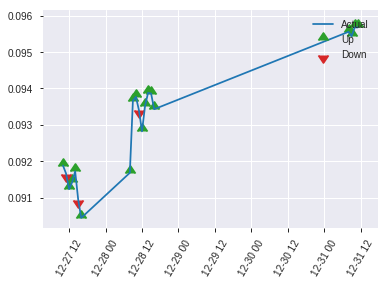


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2017768415345098
RMSE: 0.4491957719463862
LogLoss: 0.5875670164448016
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 307.9486967302692
Residual deviance: 262.0548893343816
AIC: 2338.0548893343816
AUC: 0.7582524271844661
pr_auc: 0.7078960393796092
Gini: 0.5165048543689321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4502277292273657: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   51   0.425    (51.0/120.0)
1      18   85   0.1748   (18.0/103.0)
Total  87   136  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450228     0.711297  135
max f2                       0.147799     0.827974  209
max f0point5                 0.492187     0.689655  111
max accuracy                 0.492187     0.717489  111
max precision                0.972249     1         0
max recall                   0.147799     1         209
max specificity              0.972249     1         0
max absolute_mcc             0.492187     0.436594  111
max min_per_class_accuracy   0.502481     0.708333  107
max mean_per_class_accuracy  0.492187     0.718932  111

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 49.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.877815           2.16505   2.16505            1                0.913373  1                           0.913373            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.862547           2.16505   2.16505            1                0.862749  1                           0.893123            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.845256           1.08252   1.85576            0.5              0.854757  0.857143                    0.882162            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.83555            2.16505   1.92449            1                0.842013  0.888889                    0.87324             0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.809224           1.44337   1.80421            0.666667         0.825395  0.833333                    0.861278            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.753011           1.96823   1.88265            0.909091         0.777229  0.869565                    0.821081            0.0970874       0.194175                   96.8226   88.2651
    7        0.152466                    0.724874           1.18094   1.65563            0.545455         0.734496  0.764706                    0.793068            0.0582524       0.252427                   18.0936   65.5625
    8        0.201794                    0.672663           1.7714    1.68393            0.818182         0.696441  0.777778                    0.769448            0.0873786       0.339806                   77.1403   68.3927
    9        0.300448                    0.611181           1.18094   1.51877            0.545455         0.634281  0.701493                    0.725065            0.116505        0.456311                   18.0936   51.8765
    10       0.399103                    0.552883           1.37776   1.48391            0.636364         0.579644  0.685393                    0.689118            0.135922        0.592233                   37.7758   48.391
    11       0.502242                    0.492187           1.41199   1.46914            0.652174         0.521833  0.678571                    0.654765            0.145631        0.737864                   41.1988   46.914
    12       0.600897                    0.454202           0.688879  1.34104            0.318182         0.472829  0.619403                    0.624895            0.0679612       0.805825                   -31.1121  34.1038
    13       0.699552                    0.39868            0.688879  1.24907            0.318182         0.42434   0.576923                    0.596612            0.0679612       0.873786                   -31.1121  24.9066
    14       0.798206                    0.320466           0.492056  1.1555             0.227273         0.362887  0.533708                    0.567724            0.0485437       0.92233                    -50.7944  15.5503
    15       0.896861                    0.205775           0.492056  1.08252            0.227273         0.261081  0.5                         0.533993            0.0485437       0.970874                   -50.7944  8.25243
    16       1                           0.0221716          0.282398  1                  0.130435         0.13675   0.461883                    0.493022           

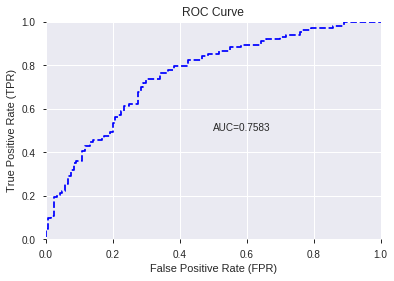

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


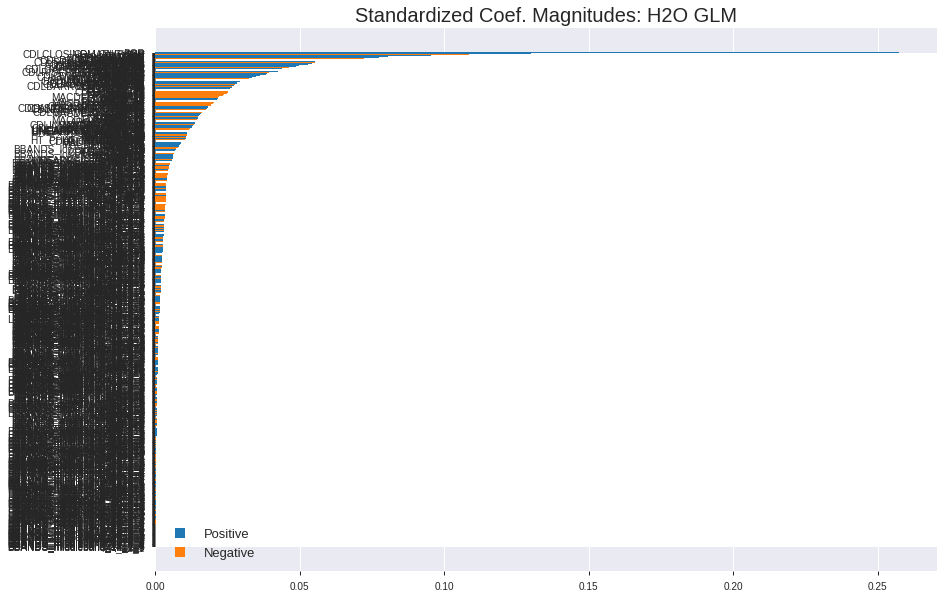

'log_likelihood'
--2019-08-26 21:08:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_210725_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_210725_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

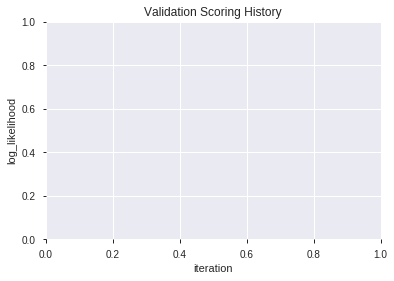

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_210831_model_4  0.763026  0.581163              0.288754  0.445415  0.198395
1  XGBoost_grid_1_AutoML_20190826_210831_model_2  0.757524  0.582967              0.319377  0.446745  0.199581
2  XGBoost_grid_1_AutoML_20190826_210831_model_1  0.755340  0.583415              0.306877  0.448260  0.200937
3  XGBoost_grid_1_AutoML_20190826_210831_model_5  0.753883  0.602100              0.294337  0.455740  0.207699
4  XGBoost_grid_1_AutoML_20190826_210831_model_7  0.752670  0.591801              0.276254  0.450431  0.202888
5  XGBoost_grid_1_AutoML_20190826_210831_model_3  0.751375  0.588842              0.312379  0.450440  0.202896
6               XGBoost_2_AutoML_20190826_210831  0.748382  0.591648              0.290817  0.451082  0.203475
7  XGBoost_grid_1_AutoML_20190826_210831_model_6  0.747896  0.590368              0.292961  0.451547  0.203895
8               XGBoost_3_AutoML_20190826_210831  0.742071  0.599376              0.322128  0.454933  0.206964
9               XGBoost_1_AutoML_20190826_210831  0.740129  0.601366              0.304045  0.455625  0.207594

variable  relative_importance  scaled_importance  percentage
0                        BOP          1673.708130           1.000000    0.302647
1                        DIV           553.220337           0.330536    0.100036
2               STOCHF_fastk           310.794067           0.185692    0.056199
3                     TRANGE           271.950836           0.162484    0.049175
4                        SUB           217.639908           0.130035    0.039355
..                       ...                  ...                ...         ...
126                   ROC_30             5.257247           0.003141    0.000951
127              MINUS_DI_30             4.971710           0.002970    0.000899
128                  BETA_20             4.384586           0.002620    0.000793
129  BBANDS_upperband_30_1_2             4.001519           0.002391    0.000724
130                STDDEV_24             3.865973           0.002310    0.000699

[131 rows x 4 columns]

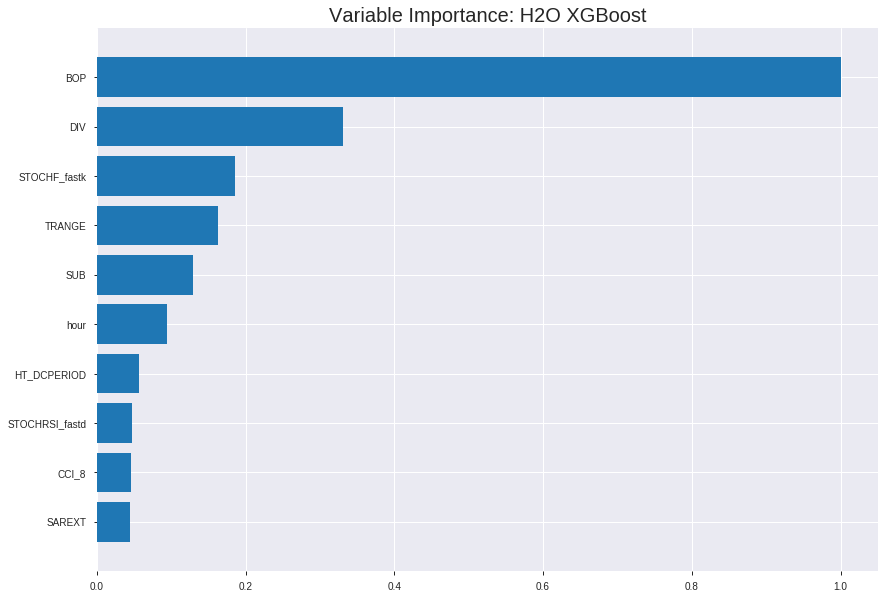

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_210831_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15966459383512888
RMSE: 0.3995805223420292
LogLoss: 0.491520330990569
Mean Per-Class Error: 0.21846056582898687
AUC: 0.8607030853568249
pr_auc: 0.8322855216973475
Gini: 0.7214061707136499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41266077756881714: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      579  276  0.3228   (276.0/855.0)
1      92   611  0.1309   (92.0/703.0)
Total  671  887  0.2362   (368.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412661     0.768553  230
max f2                       0.264351     0.852517  302
max f0point5                 0.587556     0.763668  140
max accuracy                 0.493293     0.78113   190
max precision                0.872585     1         0
max recall                   0.125969     1         377
max specificity              0.872585     1         0
max absolute_mcc             0.476729     0.560705  197
max min_per_class_accuracy   0.487717     0.776608  193
max mean_per_class_accuracy  0.476729     0.781539  197

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.837579           2.21622   2.21622            1                0.850195  1                           0.850195            0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.826853           2.0777    2.14696            0.9375           0.830891  0.96875                     0.840543            0.0213371       0.0440967                  107.77    114.696
    3        0.0301669                   0.814055           2.21622   2.16906            1                0.821161  0.978723                    0.834357            0.0213371       0.0654339                  121.622   116.906
    4        0.0404365                   0.800484           1.93919   2.11068            0.875            0.806591  0.952381                    0.827306            0.0199147       0.0853485                  93.9189   111.068
    5        0.0500642                   0.790874           2.21622   2.13098            1                0.795615  0.961538                    0.821211            0.0213371       0.106686                   121.622   113.098
    6        0.100128                    0.752516           2.01733   2.07415            0.910256         0.771171  0.935897                    0.796191            0.100996        0.207681                   101.733   107.415
    7        0.150193                    0.713281           2.01733   2.05521            0.910256         0.731008  0.92735                     0.774463            0.100996        0.308677                   101.733   105.521
    8        0.200257                    0.681267           1.84685   2.00312            0.833333         0.69768   0.903846                    0.755267            0.0924609       0.401138                   84.6847   100.312
    9        0.300385                    0.616592           1.54851   1.85158            0.698718         0.648313  0.83547                     0.719616            0.15505         0.556188                   54.851    85.1582
    10       0.399872                    0.546956           1.27254   1.70752            0.574194         0.581106  0.770465                    0.685155            0.1266          0.682788                   27.2537   70.7518
    11       0.5                         0.46018            1.22176   1.61024            0.551282         0.504514  0.726573                    0.648981            0.122333        0.805121                   22.176    61.0242
    12       0.600128                    0.388201           0.809771  1.47669            0.365385         0.425527  0.66631                     0.611699            0.0810811       0.886202                   -19.0229  47.6687
    13       0.699615                    0.293886           0.571927  1.34803            0.258065         0.342535  0.608257                    0.573423            0.056899        0.943101                   -42.8073  34.8029
    14       0.799743                    0.209876           0.355163  1.22372            0.160256         0.250777  0.552167                    0.533028            0.0355619       0.978663                   -64.4837  22.3721
    15       0.899872                    0.142111           0.184685  1.10811            0.0833333        0.171727  0.5                         0.492826            0.0184922       0.997155                   -81.5315  10.8108
    16       1                           0.0753433          0.028413  1                  0.0128205        0.115904  0.45122                     0.455085         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19379328182538982
RMSE: 0.440219583645923
LogLoss: 0.5734168403130933
Mean Per-Class Error: 0.2670588235294118
AUC: 0.7873705379587732
pr_auc: 0.7413818815943746
Gini: 0.5747410759175464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36546897888183594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  79   0.3511   (79.0/225.0)
1      41   180  0.1855   (41.0/221.0)
Total  187  259  0.2691   (120.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365469     0.75      235
max f2                       0.112897     0.843511  382
max f0point5                 0.519123     0.738328  156
max accuracy                 0.452564     0.733184  188
max precision                0.704203     0.865385  47
max recall                   0.112897     1         382
max specificity              0.827594     0.995556  0
max absolute_mcc             0.365469     0.469508  235
max min_per_class_accuracy   0.436127     0.724444  201
max mean_per_class_accuracy  0.448881     0.732941  190

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 42.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.791438           1.21086   1.21086            0.6              0.815676  0.6                         0.815676            0.0135747       0.0135747                  21.086    21.086
    2        0.0201794                   0.774264           1.51357   1.3454             0.75             0.780369  0.666667                    0.799984            0.0135747       0.0271493                  51.3575   34.54
    3        0.0313901                   0.759244           1.21086   1.29735            0.6              0.767066  0.642857                    0.788228            0.0135747       0.040724                   21.086    29.735
    4        0.0403587                   0.747505           2.0181    1.45752            1                0.756595  0.722222                    0.781198            0.0180995       0.0588235                  101.81    45.7516
    5        0.0515695                   0.743466           2.0181    1.57938            1                0.744926  0.782609                    0.773313            0.0226244       0.081448                   101.81    57.9382
    6        0.100897                    0.712501           1.83464   1.70417            0.909091         0.729027  0.844444                    0.751662            0.0904977       0.171946                   83.4636   70.4173
    7        0.150224                    0.678529           1.65117   1.68677            0.818182         0.696762  0.835821                    0.733635            0.081448        0.253394                   65.1172   68.677
    8        0.201794                    0.645605           1.49164   1.6369             0.73913          0.661409  0.811111                    0.715177            0.0769231       0.330317                   49.1639   63.6903
    9        0.300448                    0.59188            1.51357   1.59641            0.75             0.619877  0.791045                    0.683885            0.149321        0.479638                   51.3575   59.6407
    10       0.401345                    0.506383           1.39025   1.54458            0.688889         0.551372  0.765363                    0.650572            0.140271        0.61991                    39.0246   54.4579
    11       0.5                         0.434395           1.10078   1.45701            0.545455         0.466143  0.721973                    0.614182            0.108597        0.728507                   10.0782   45.7014
    12       0.600897                    0.347044           0.94178   1.3705             0.466667         0.390235  0.679104                    0.576579            0.0950226       0.823529                   -5.82202  37.05
    13       0.699552                    0.267546           0.642123  1.26778            0.318182         0.309843  0.628205                    0.538962            0.0633484       0.886878                   -35.7877  26.778
    14       0.800448                    0.193905           0.53816   1.17581            0.266667         0.232393  0.582633                    0.500319            0.0542986       0.941176                   -46.184   17.5812
    15       0.899103                    0.134516           0.229329  1.07196            0.113636         0.162171  0.531172                    0.463216            0.0226244       0.963801                   -77.0671  7.19581
    16       1                           0.0831075          0.358773  1                  0.177778         0.113258  0.495516                    0.427906            0.036


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:08:59  11.958 sec  0                  0.5              0.693147            0.5             0                  1                0.54878                          0.5                0.693147              0.5               0                    1                  0.504484
    2019-08-26 21:08:59  12.695 sec  5                  0.475932         0.645859            0.806221        0.735973           2.10541          0.275995                         0.480855           0.655375              0.763781          0.705461             1.26131            0.266816
    2019-08-26 21:09:00  12.996 sec  10                 0.459178         0.613272            0.811916        0.767843           2.08585          0.272786                         0.46778            0.629737              0.77814           0.720392             0.80724            0.257848
    2019-08-26 21:09:00  13.291 sec  15                 0.447949         0.591144            0.81524         0.771893           2.0777           0.276637                         0.461311           0.616848              0.775877          0.719607             0.40362            0.246637
    2019-08-26 21:09:00  13.597 sec  20                 0.438983         0.572821            0.818031        0.777741           2.0777           0.268935                         0.45545            0.604939              0.776591          0.722343             0.40362            0.280269
    2019-08-26 21:09:01  13.888 sec  25                 0.431641         0.557918            0.823151        0.787196           2.0777           0.279204                         0.451209           0.596029              0.77638           0.723111             0.40362            0.26009
    2019-08-26 21:09:01  14.205 sec  30                 0.42496          0.543612            0.828231        0.790274           2.0777           0.263158                         0.447801           0.589159              0.778632          0.725683             0.40362            0.282511
    2019-08-26 21:09:01  14.506 sec  35                 0.419532         0.532699            0.835924        0.801317           2.0777           0.247754                         0.445503           0.584578              0.783198          0.731904             0.40362            0.269058
    2019-08-26 21:09:02  14.805 sec  40                 0.41522          0.523795            0.841382        0.808269           2.0777           0.245186                         0.444642           0.582481              0.782041          0.727808             0.40362            0.278027
    2019-08-26 21:09:02  15.104 sec  45                 0.411765         0.516421            0.845021        0.814359           2.21622          0.240693                         0.443622           0.580188              0.783741          0.732293             0.80724            0.278027
    2019-08-26 21:09:02  15.421 sec  50                 0.408217         0.509066            0.849005        0.818066           2.21622          0.239409                         0.44295            0.578573              0.784183          0.733753             1.21086            0.280269
    2019-08-26 21:09:02  15.734 sec  55                 0.405344         0.503077            0.852604        0.82342            2.0777           0.238768                         0.442856           0.578483              0.784756          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1673.7081298828125     1.0                    0.30264716756635424
DIV                      553.2203369140625      0.3305357290418355     0.10003570217399145
STOCHF_fastk             310.7940673828125      0.18569191475730792    0.056199132041272144
TRANGE                   271.9508361816406      0.16248402653136526    0.04917533040449405
SUB                      217.63990783691406     0.1300345645403255     0.0393545926438538
---                      ---                    ---                    ---
ROC_30                   5.257247447967529      0.0031410777985141436  0.0009506382988258652
MINUS_DI_30              4.971710205078125      0.0029704762236090875  0.0008990062153984906
BETA_20                  4.384586334228516      0.002619683955610295   0.0007928399290844787
BBANDS_upperband_30_1_2  4.001519203186035      0.002390810638809652   0.0007235720680232472
STDDEV_24                3.8659725189208984     0.00230982478360285    0.0006990619283319697


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.7155172413793104)

('auc', 0.7630258899676375)

('logloss', 0.5811626700002552)

('mean_per_class_error', 0.2823624595469256)

('rmse', 0.445415445412615)

('mse', 0.19839491901211823)

xgboost prediction progress: |████████████████████████████████████████████| 100%


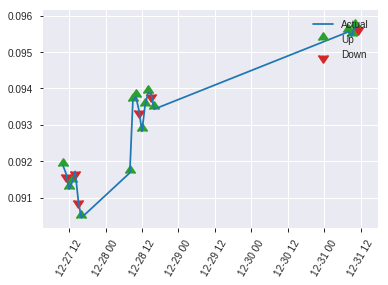


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19839491901211823
RMSE: 0.445415445412615
LogLoss: 0.5811626700002552
Mean Per-Class Error: 0.2823624595469256
AUC: 0.7630258899676375
pr_auc: 0.6907529509077622
Gini: 0.5260517799352751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3779833912849426: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   46   0.3833   (46.0/120.0)
1      20   83   0.1942   (20.0/103.0)
Total  94   129  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377983     0.715517  128
max f2                       0.1795       0.845771  190
max f0point5                 0.569054     0.72104   79
max accuracy                 0.569054     0.726457  79
max precision                0.813231     1         0
max recall                   0.125768     1         210
max specificity              0.813231     1         0
max absolute_mcc             0.569054     0.451009  79
max min_per_class_accuracy   0.473534     0.699029  105
max mean_per_class_accuracy  0.561929     0.717638  81

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 44.34 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.80538            2.16505    2.16505            1                0.809899  1                           0.809899            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.797006           0          1.29903            0                0.800464  0.6                         0.806125            0               0.0291262                  -100      29.9029
    3        0.0313901                   0.783903           2.16505    1.54646            1                0.789517  0.714286                    0.80138             0.0194175       0.0485437                  116.505   54.6463
    4        0.0403587                   0.773202           2.16505    1.68393            1                0.780091  0.777778                    0.796649            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.763541           1.44337    1.62379            0.666667         0.768076  0.75                        0.789506            0.0194175       0.0873786                  44.3366   62.3786
    6        0.103139                    0.732987           1.7714     1.69439            0.818182         0.745821  0.782609                    0.768613            0.0873786       0.174757                   77.1403   69.4386
    7        0.152466                    0.702295           1.57458    1.65563            0.727273         0.717961  0.764706                    0.752226            0.0776699       0.252427                   57.4581   65.5625
    8        0.201794                    0.673917           1.18094    1.53959            0.545455         0.688993  0.711111                    0.736769            0.0582524       0.31068                    18.0936   53.959
    9        0.300448                    0.593766           1.86981    1.64802            0.863636         0.632482  0.761194                    0.702525            0.184466        0.495146                   86.9815   64.8022
    10       0.399103                    0.531242           1.37776    1.58122            0.636364         0.568224  0.730337                    0.669327            0.135922        0.631068                   37.7758   58.1215
    11       0.502242                    0.450575           0.75306    1.41115            0.347826         0.482636  0.651786                    0.630989            0.0776699       0.708738                   -24.694   41.1148
    12       0.600897                    0.369872           0.984113   1.34104            0.454545         0.402079  0.619403                    0.593407            0.0970874       0.805825                   -1.5887   34.1038
    13       0.699552                    0.287559           0.492056   1.22131            0.227273         0.32762   0.564103                    0.555924            0.0485437       0.854369                   -50.7944  22.1309
    14       0.798206                    0.209367           0.78729    1.16767            0.363636         0.237932  0.539326                    0.516622            0.0776699       0.932039                   -21.271   16.7667
    15       0.896861                    0.151395           0.590468   1.10417            0.272727         0.184481  0.51                        0.480086            0.0582524       0.990291                   -40.9532  10.4175
    16       1                           0.0965033          0.0941325  1                  0.0434783        0.124618  0.461883                    

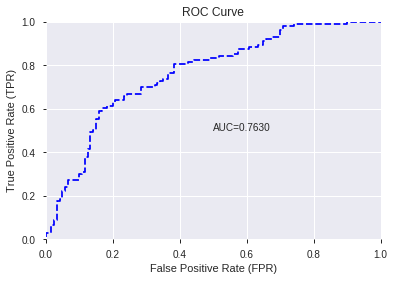

This function is available for GLM models only


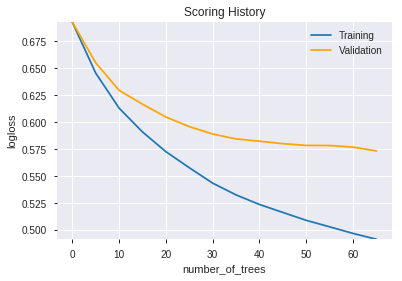

--2019-08-26 21:09:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_210831_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_210831_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_210931_model_6  0.743851  0.591193              0.313835  0.450596  0.203037
1  DeepLearning_grid_1_AutoML_20190826_210931_model_5  0.737379  0.614277              0.340898  0.461037  0.212555
2  DeepLearning_grid_1_AutoML_20190826_210931_model_8  0.734385  0.647048              0.334668  0.471049  0.221887
3  DeepLearning_grid_1_AutoML_20190826_210931_model_4  0.732605  0.815794              0.384021  0.500952  0.250953
4  DeepLearning_grid_1_AutoML_20190826_210931_model_7  0.729693  0.616452              0.288026  0.460684  0.212230
5  DeepLearning_grid_1_AutoML_20190826_210931_model_9  0.726699  0.628844              0.337460  0.465256  0.216463
6               DeepLearning_1_AutoML_20190826_210931  0.725647  0.660524              0.369417  0.475665  0.226257
7  DeepLearning_grid_1_AutoML_20190826_210931_model_3  0.717476  0.755774              0.353398  0.481438  0.231782
8  DeepLearning_grid_1_AutoML_20190826_210931_model_1  0.716586  0.910712              0.340898  0.500383  0.250383
9  DeepLearning_grid_1_AutoML_20190826_210931_model_2  0.701052  0.825394              0.402023  0.525085  0.275714

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.029970
1   CDLCLOSINGMARUBOZU             0.957811           0.957811    0.028706
2                  DIV             0.846271           0.846271    0.025363
3                  SUB             0.775682           0.775682    0.023247
4          CDLLONGLINE             0.769810           0.769810    0.023071
5                 hour             0.746409           0.746409    0.022370
6               ULTOSC             0.735265           0.735265    0.022036
7            CORREL_30             0.713464           0.713464    0.021383
8         HT_TRENDMODE             0.709121           0.709121    0.021252
9             WILLR_12             0.698248           0.698248    0.020927
10             CDLDOJI             0.684965           0.684965    0.020528
11              SAREXT             0.683294           0.683294    0.020478
12               CCI_8             0.679484           0.679484    0.020364
13  CDLMORNINGDOJISTAR             0.679307           0.679307    0.020359
14        STOCHF_fastk             0.675470           0.675470    0.020244
15           CDLHARAMI             0.667439           0.667439    0.020003
16   CDLSTALLEDPATTERN             0.660706           0.660706    0.019801
17              TRANGE             0.659195           0.659195    0.019756
18           CDLHAMMER             0.656355           0.656355    0.019671
19        aroondown_30             0.652364           0.652364    0.019551
20       days_in_month             0.649743           0.649743    0.019473
21      CDLMORNINGSTAR             0.649253           0.649253    0.019458
22      CDLEVENINGSTAR             0.648284           0.648284    0.019429
23             quarter             0.647291           0.647291    0.019399
24      STOCHRSI_fastk             0.646667           0.646667    0.019381
25           aroonup_8             0.646071           0.646071    0.019363
26  CDLEVENINGDOJISTAR             0.642677           0.642677    0.019261
27          aroonup_30             0.642138           0.642138    0.019245
28        weekday_name             0.641353           0.641353    0.019221
29             BETA_24             0.640019           0.640019    0.019181
30      STOCHRSI_fastd             0.639815           0.639815    0.019175
31      CDL3BLACKCROWS             0.637815           0.637815    0.019115
32              MFI_12             0.631387           0.631387    0.018923
33   CDLINVERTEDHAMMER             0.631173           0.631173    0.018916
34         aroondown_8             0.628114           0.628114    0.018825
35         STOCH_slowd             0.627919           0.627919    0.018819
36               MFI_8             0.620740           0.620740    0.018604
37              Volume             0.620337           0.620337    0.018592
38           dayofweek             0.612958           0.612958    0.018370
39         HT_DCPERIOD             0.612167           0.612167    0.018347
40                 day             0.610415           0.610415    0.018294
41             WILLR_8             0.609566           0.609566    0.018269
42          AROONOSC_8             0.608158           0.608158    0.018227
43         STOCH_slowk             0.607374           0.607374    0.018203
44   CDL3WHITESOLDIERS             0.600855           0.600855    0.018008
45              MFI_14             0.599451           0.599451    0.017966
46     CDLUNIQUE3RIVER             0.596952           0.596952    0.017891
47      CDLSPINNINGTOP             0.596543           0.596543    0.017878
48        STOCHF_fastd             0.594929           0.594929    0.017830
49             weekday             0.575717           0.575717    0.017254

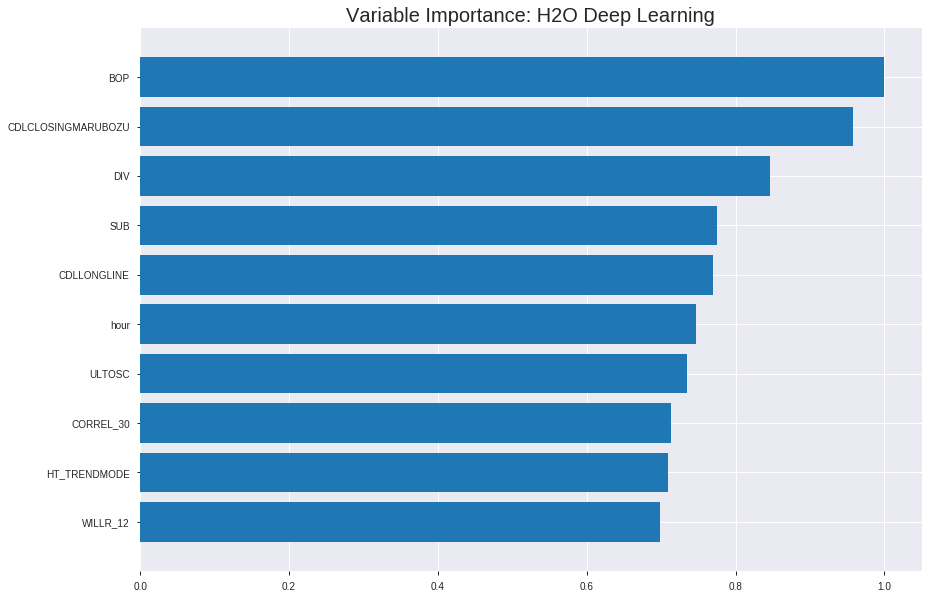

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_210931_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18024395957862493
RMSE: 0.4245514804810189
LogLoss: 0.5333867725249472
Mean Per-Class Error: 0.2670934091986723
AUC: 0.8090672389841365
pr_auc: 0.7590730265223306
Gini: 0.6181344779682729
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4021872349514532: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      520  335  0.3918   (335.0/855.0)
1      105  598  0.1494   (105.0/703.0)
Total  625  933  0.2824   (440.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402187     0.731051  228
max f2                       0.166478     0.838235  327
max f0point5                 0.520366     0.712116  155
max accuracy                 0.450547     0.72914   198
max precision                0.968997     1         0
max recall                   0.0254509    1         386
max specificity              0.968997     1         0
max absolute_mcc             0.402187     0.465832  228
max min_per_class_accuracy   0.465599     0.722807  190
max mean_per_class_accuracy  0.443238     0.732907  203

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 42.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.916055           2.0777     2.0777             0.9375           0.935649   0.9375                      0.935649            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.891936           2.21622    2.14696            1                0.904081   0.96875                     0.919865            0.0227596       0.0440967                  121.622   114.696
    3        0.0301669                   0.875664           1.77297    2.0276             0.8              0.88352    0.914894                    0.908266            0.0170697       0.0611664                  77.2973   102.76
    4        0.0404365                   0.852913           2.0777     2.04033            0.9375           0.864012   0.920635                    0.897027            0.0213371       0.0825036                  107.77    104.033
    5        0.0500642                   0.830001           1.62523    1.9605             0.733333         0.840989   0.884615                    0.88625             0.0156472       0.0981508                  62.5225   96.0499
    6        0.100128                    0.726834           1.81843    1.88947            0.820513         0.771676   0.852564                    0.828963            0.0910384       0.189189                   81.8434   88.9466
    7        0.150193                    0.661694           1.87526    1.88473            0.846154         0.691059   0.850427                    0.782995            0.0938834       0.283073                   87.526    88.4731
    8        0.200257                    0.618842           1.79002    1.86105            0.807692         0.639966   0.839744                    0.747238            0.0896159       0.372688                   79.0021   86.1053
    9        0.300385                    0.54852            1.37803    1.70005            0.621795         0.580529   0.767094                    0.691668            0.13798         0.510669                   37.8032   70.0046
    10       0.399872                    0.49932            1.25824    1.59013            0.567742         0.523993   0.717496                    0.649951            0.125178        0.635846                   25.8239   59.0126
    11       0.5                         0.453826           1.15073    1.50213            0.519231         0.479149   0.677792                    0.615747            0.11522         0.751067                   15.0728   50.2134
    12       0.600128                    0.400437           1.00866    1.4198             0.455128         0.427762   0.640642                    0.584382            0.100996        0.852063                   0.866251  41.9801
    13       0.699615                    0.313215           0.657716   1.31143            0.296774         0.360555   0.591743                    0.552554            0.0654339       0.917496                   -34.2284  31.1431
    14       0.799743                    0.182983           0.468815   1.20593            0.211538         0.249806   0.544141                    0.514649            0.0469417       0.964438                   -53.1185  20.5935
    15       0.899872                    0.0653094          0.298337   1.10495            0.134615         0.118472   0.498573                    0.470567            0.029872        0.99431                    -70.1663  10.4947
    16       1                           0.00137443         0.0568261  1                  0.025641         0.0295258  0.45122    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20031547639734923
RMSE: 0.4475661698535192
LogLoss: 0.6002295856357593
Mean Per-Class Error: 0.24423328305681247
AUC: 0.779819004524887
pr_auc: 0.7291974705669259
Gini: 0.5596380090497739
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4504164592566071: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      166  59   0.2622   (59.0/225.0)
1      50   171  0.2262   (50.0/221.0)
Total  216  230  0.2444   (109.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450416     0.758315  197
max f2                       0.0772031    0.846395  350
max f0point5                 0.453015     0.751111  194
max accuracy                 0.453015     0.755605  194
max precision                0.958561     1         0
max recall                   0.00340178   1         397
max specificity              0.958561     1         0
max absolute_mcc             0.450416     0.511765  197
max min_per_class_accuracy   0.456363     0.751111  191
max mean_per_class_accuracy  0.450416     0.755767  197

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 41.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.944011           2.0181    2.0181             1                0.950914   1                           0.950914            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.864228           1.51357   1.79387            0.75             0.913633   0.888889                    0.934345            0.0135747       0.0361991                  51.3575   79.3866
    3        0.0313901                   0.850255           1.61448   1.7298             0.8              0.858558   0.857143                    0.907278            0.0180995       0.0542986                  61.448    72.98
    4        0.0403587                   0.80433            2.0181    1.79387            1                0.824362   0.888889                    0.888852            0.0180995       0.0723982                  101.81    79.3866
    5        0.0515695                   0.787889           1.21086   1.66713            0.6              0.794099   0.826087                    0.868254            0.0135747       0.0859729                  21.086    66.7126
    6        0.100897                    0.708374           1.37598   1.52479            0.681818         0.743055   0.755556                    0.807045            0.0678733       0.153846                   37.5977   52.4786
    7        0.150224                    0.635065           1.37598   1.47592            0.681818         0.667843   0.731343                    0.761337            0.0678733       0.221719                   37.5977   47.5924
    8        0.201794                    0.581575           1.49164   1.47994            0.73913          0.60438    0.733333                    0.721226            0.0769231       0.298643                   49.1639   47.994
    9        0.300448                    0.541648           1.55944   1.50604            0.772727         0.56038    0.746269                    0.668411            0.153846        0.452489                   55.9441   50.6044
    10       0.401345                    0.502088           1.52479   1.51076            0.755556         0.520194   0.748603                    0.63115             0.153846        0.606335                   52.4786   51.0756
    11       0.5                         0.455304           1.51357   1.51131            0.75             0.479657   0.748879                    0.601259            0.149321        0.755656                   51.3575   51.1312
    12       0.600897                    0.390372           0.717547  1.37803            0.355556         0.425597   0.682836                    0.571763            0.0723982       0.828054                   -28.2453  37.8031
    13       0.699552                    0.296275           0.642123  1.27425            0.318182         0.352315   0.63141                     0.540815            0.0633484       0.891403                   -35.7877  27.4249
    14       0.800448                    0.175522           0.493313  1.17581            0.244444         0.242671   0.582633                    0.503234            0.0497738       0.941176                   -50.6687  17.5812
    15       0.899103                    0.0536943          0.412793  1.09209            0.204545         0.111272   0.541147                    0.460226            0.040724        0.9819                     -58.7207  9.20888
    16       1                           0.00187524         0.179387  1                  0.0888889        0.0193162  0.495516                    0.4


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:13:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:13:46  2 min 25.324 sec  903 obs/sec       1.37291   1             2139       0.464846         0.68141             0.127368       0.767314        0.695555           1.66216          0.343389                         0.462971           0.694855              0.142564         0.774641          0.741007             2.0181             0.316143
    2019-08-26 21:13:54  2 min 32.851 sec  1644 obs/sec      9.65276   7             15039      0.424551         0.533387            0.272096       0.809067        0.759073           2.0777           0.282413                         0.447566           0.60023               0.198674         0.779819          0.729197             2.0181             0.244395
    2019-08-26 21:14:01  2 min 40.295 sec  2032 obs/sec      20.7298   15            32297      0.412608         0.508718            0.312473       0.829513        0.788997           2.21622          0.264442                         0.445362           0.613157              0.206547         0.789542          0.725785             1.21086            0.280269
    2019-08-26 21:14:09  2 min 47.493 sec  2210 obs/sec      31.7766   23            49508      0.400973         0.484467            0.350704       0.849317        0.812681           2.21622          0.239409                         0.44794            0.620103              0.197335         0.783811          0.724869             1.21086            0.262332
    2019-08-26 21:14:16  2 min 54.538 sec  2321 obs/sec      42.8325   31            66733      0.39132          0.464549            0.381589       0.861764        0.82942            2.21622          0.244544                         0.444413           0.609833              0.209926         0.779226          0.723968             0.80724            0.29148
    2019-08-26 21:14:23  3 min  1.551 sec  2398 obs/sec      53.9615   39            84072      0.379824         0.440068            0.41739        0.875894        0.847217           2.21622          0.220796                         0.45057            0.637807              0.187881         0.776068          0.722647             1.21086            0.302691
    2019-08-26 21:14:30  3 min  9.364 sec  2455 obs/sec      66.4153   48            103475     0.370737         0.423562            0.444932       0.890069        0.867497           2.0777           0.200257                         0.455183           0.644587              0.171168         0.76905           0.715377             1.21086            0.311659
    2019-08-26 21:14:31  3 min 10.096 sec  2454 obs/sec      66.4153   48            103475     0.424551         0.533387            0.272096       0.809067        0.759073           2.0777           0.282413                         0.447566           0.60023               0.198674         0.779819          0.729197             2.0181             0.244395

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.02997014089207533
CDLCLOSINGMARUBOZU  0.9578111171722412     0.9578111171722412   0.028705734129648143
DIV                 0.8462713956832886     0.8462713956832886   0.025362872961561388
SUB                 0.7756816148757935     0.7756816148757935   0.023247287285220044
CDLLONGLINE         0.7698097825050354     0.7698097825050354   0.02307130764177378
---                 ---                    ---                  ---
MFI_14              0.5994505286216736     0.5994505286216736   0.017965616800620594
CDLUNIQUE3RIVER     0.5969523191452026     0.5969523191452026   0.01789074511063284
CDLSPINNINGTOP      0.5965425968170166     0.5965425968170166   0.017878465674730476
STOCHF_fastd        0.594928503036499      0.594928503036499    0.01783009105671534
weekday             0.5757171511650085     0.5757171511650085   0.017254324134399538


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6860986547085202)

('F1', 0.7196969696969698)

('auc', 0.7438511326860842)

('logloss', 0.5911930605790097)

('mean_per_class_error', 0.3122977346278317)

('rmse', 0.45059585836720023)

('mse', 0.203036627577674)

deeplearning prediction progress: |███████████████████████████████████████| 100%


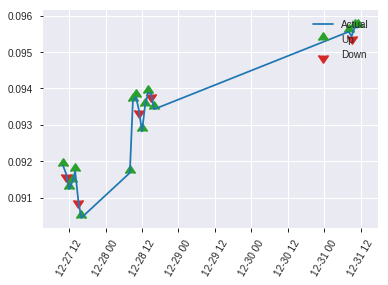


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.203036627577674
RMSE: 0.45059585836720023
LogLoss: 0.5911930605790097
Mean Per-Class Error: 0.3122977346278317
AUC: 0.7438511326860842
pr_auc: 0.6921351289522318
Gini: 0.4877022653721683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3505405063398281: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   66   0.55     (66.0/120.0)
1      8    95   0.0777   (8.0/103.0)
Total  62   161  0.3318   (74.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350541     0.719697  160
max f2                       0.0513211    0.831987  206
max f0point5                 0.608206     0.673854  66
max accuracy                 0.608206     0.686099  66
max precision                0.96227      1         0
max recall                   0.0513211    1         206
max specificity              0.96227      1         0
max absolute_mcc             0.350541     0.414313  160
max min_per_class_accuracy   0.506183     0.666667  108
max mean_per_class_accuracy  0.493602     0.687702  112

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.942484           2.16505   2.16505            1                0.953528   1                           0.953528            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.937767           2.16505   2.16505            1                0.940119   1                           0.948164            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.932609           2.16505   2.16505            1                0.934582   1                           0.944284            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.898555           2.16505   2.16505            1                0.931007   1                           0.941333            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.888474           1.44337   1.98463            0.666667         0.891823   0.916667                    0.928956            0.0194175       0.106796                   44.3366   98.4628
    6        0.103139                    0.773356           1.18094   1.60025            0.545455         0.828571   0.73913                     0.880946            0.0582524       0.165049                   18.0936   60.0253
    7        0.152466                    0.734013           1.37776   1.52827            0.636364         0.752435   0.705882                    0.839369            0.0679612       0.23301                    37.7758   52.827
    8        0.201794                    0.707448           1.37776   1.49148            0.636364         0.723065   0.688889                    0.810939            0.0679612       0.300971                   37.7758   49.1478
    9        0.300448                    0.605553           1.86981   1.61571            0.863636         0.661777   0.746269                    0.761961            0.184466        0.485437                   86.9815   61.5708
    10       0.399103                    0.546327           0.984113  1.45958            0.454545         0.579919   0.674157                    0.716961            0.0970874       0.582524                   -1.5887   45.9583
    11       0.502242                    0.494863           1.12959   1.39182            0.521739         0.525628   0.642857                    0.67767             0.116505        0.699029                   12.9591   39.1817
    12       0.600897                    0.446406           0.688879  1.27641            0.318182         0.467868   0.589552                    0.643225            0.0679612       0.76699                    -31.1121  27.6409
    13       0.699552                    0.363434           1.27935   1.27682            0.590909         0.406328   0.589744                    0.609816            0.126214        0.893204                   27.9347   27.6824
    14       0.798206                    0.210578           0.492056  1.17983            0.227273         0.299778   0.544944                    0.571497            0.0485437       0.941748                   -50.7944  17.983
    15       0.896861                    0.0821221          0.196823  1.0717             0.0909091        0.134952   0.495                       0.523477            0.0194175       0.961165                   -80.3177  7.1699
    16       1                           0.00250717         0.37653   1                  0.173913         0.0363835  0.461883                    0.

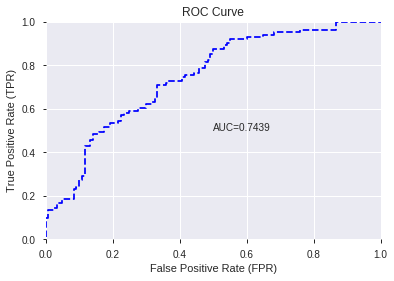

This function is available for GLM models only


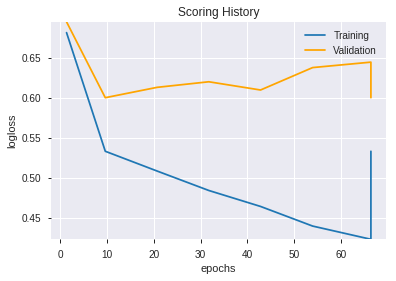

--2019-08-26 21:19:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_210931_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_210931_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'hour',
 'ULTOSC',
 'CORREL_30',
 'HT_TRENDMODE',
 'WILLR_12',
 'CDLDOJI',
 'SAREXT',
 'CCI_8',
 'CDLMORNINGDOJISTAR',
 'STOCHF_fastk',
 'CDLHARAMI',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'CDLHAMMER',
 'aroondown_30',
 'days_in_month',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'quarter',
 'STOCHRSI_fastk',
 'aroonup_8',
 'CDLEVENINGDOJISTAR',
 'aroonup_30',
 'weekday_name',
 'BETA_24',
 'STOCHRSI_fastd',
 'CDL3BLACKCROWS',
 'MFI_12',
 'CDLINVERTEDHAMMER',
 'aroondown_8',
 'STOCH_slowd',
 'MFI_8',
 'Volume',
 'dayofweek',
 'HT_DCPERIOD',
 'day',
 'WILLR_8',
 'AROONOSC_8',
 'STOCH_slowk',
 'CDL3WHITESOLDIERS',
 'MFI_14',
 'CDLUNIQUE3RIVER',
 'CDLSPINNINGTOP',
 'STOCHF_fastd',
 'weekday']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_211913_model_1  0.762783  0.58532              0.331877  0.44876  0.201386

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.453054           1.000000    0.092175
1               ULTOSC             0.320914           0.708334    0.065291
2                  SUB             0.274144           0.605102    0.055775
3   CDLCLOSINGMARUBOZU             0.248904           0.549391    0.050640
4         STOCHF_fastk             0.229923           0.507495    0.046779
5             WILLR_12             0.210593           0.464830    0.042846
6                CCI_8             0.179481           0.396157    0.036516
7          STOCH_slowd             0.176266           0.389062    0.035862
8                  DIV             0.173010           0.381874    0.035199
9            CDLHAMMER             0.139980           0.308970    0.028479
10              SAREXT             0.134663           0.297234    0.027398
11                hour             0.126457           0.279121    0.025728
12       days_in_month             0.125178           0.276298    0.025468
13         HT_DCPERIOD             0.119797           0.264421    0.024373
14   CDLSTALLEDPATTERN             0.116871           0.257962    0.023778
15              TRANGE             0.113461           0.250435    0.023084
16         CDLLONGLINE             0.105944           0.233844    0.021555
17      CDLEVENINGSTAR             0.089971           0.198587    0.018305
18           CDLHARAMI             0.089403           0.197334    0.018189
19             WILLR_8             0.088961           0.196358    0.018099
20             quarter             0.088818           0.196042    0.018070
21        STOCHF_fastd             0.084920           0.187438    0.017277
22         STOCH_slowk             0.084277           0.186020    0.017146
23      CDLSPINNINGTOP             0.083055           0.183322    0.016898
24           aroonup_8             0.082659           0.182447    0.016817
25      STOCHRSI_fastk             0.082122           0.181264    0.016708
26               MFI_8             0.081979           0.180947    0.016679
27              Volume             0.069931           0.154354    0.014228
28   CDL3WHITESOLDIERS             0.066071           0.145835    0.013442
29        aroondown_30             0.065793           0.145220    0.013386
30     CDLUNIQUE3RIVER             0.059898           0.132208    0.012186
31                 day             0.059837           0.132075    0.012174
32         aroondown_8             0.051678           0.114065    0.010514
33             CDLDOJI             0.049531           0.109328    0.010077
34             BETA_24             0.046768           0.103228    0.009515
35      CDL3BLACKCROWS             0.041885           0.092449    0.008522
36      CDLMORNINGSTAR             0.040595           0.089603    0.008259
37  CDLMORNINGDOJISTAR             0.036298           0.080117    0.007385
38      STOCHRSI_fastd             0.035895           0.079228    0.007303
39  CDLEVENINGDOJISTAR             0.034196           0.075479    0.006957
40           CORREL_30             0.027680           0.061096    0.005631
41              MFI_12             0.024987           0.055152    0.005084
42              MFI_14             0.019845           0.043802    0.004037
43   CDLINVERTEDHAMMER             0.019840           0.043792    0.004037
44          AROONOSC_8             0.018082           0.039911    0.003679
45        HT_TRENDMODE             0.017774           0.039231    0.003616
46           dayofweek             0.011727           0.025885    0.002386
47             weekday             0.011683           0.025786    0.002377
48        weekday_name             0.000246           0.000543    0.000050
49          aroonup_30             0.000096           0.000212    0.000020

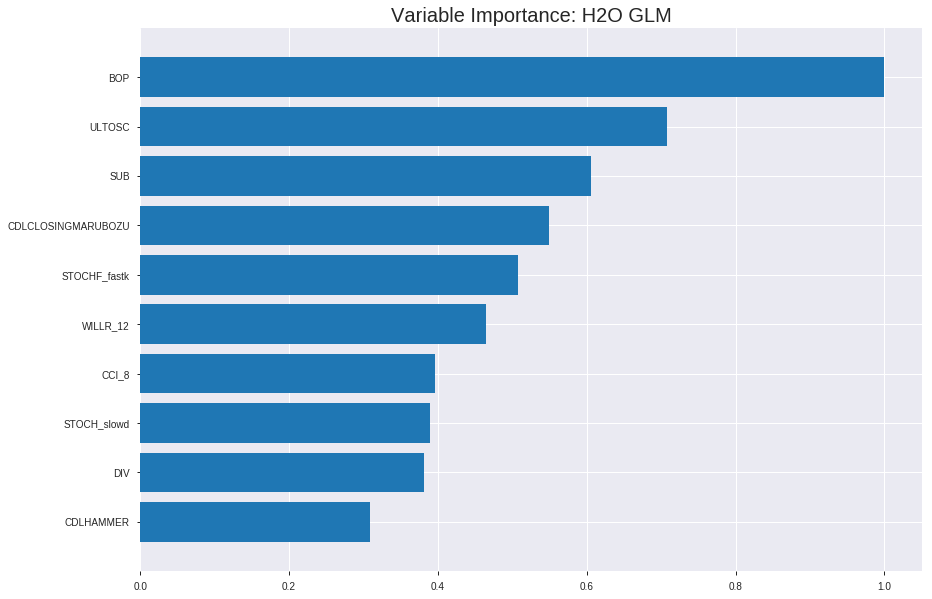

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_211913_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18405759327855678
RMSE: 0.4290193390496013
LogLoss: 0.5442950272679431
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2144.993731790383
Residual deviance: 1696.023304966911
AIC: 1798.023304966911
AUC: 0.7946303644364586
pr_auc: 0.7443861227737578
Gini: 0.5892607288729172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3630496822299588: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      485  370  0.4327   (370.0/855.0)
1      97   606  0.138    (97.0/703.0)
Total  582  976  0.2997   (467.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36305      0.721858  252
max f2                       0.2209       0.833333  316
max f0point5                 0.508761     0.691313  182
max accuracy                 0.459409     0.719512  207
max precision                0.982932     1         0
max recall                   0.0387999    1         387
max specificity              0.982932     1         0
max absolute_mcc             0.402202     0.444151  234
max min_per_class_accuracy   0.470577     0.71462   202
max mean_per_class_accuracy  0.402202     0.720863  234

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.916648           2.0777    2.0777             0.9375           0.945154   0.9375                      0.945154            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.892626           1.93919   2.00845            0.875            0.9042     0.90625                     0.924677            0.0199147       0.0412518                  93.9189   100.845
    3        0.0301669                   0.866024           1.92072   1.98045            0.866667         0.880902   0.893617                    0.910707            0.0184922       0.059744                   92.0721   98.0449
    4        0.0404365                   0.850254           1.66216   1.89961            0.75             0.859552   0.857143                    0.897715            0.0170697       0.0768137                  66.2162   89.9614
    5        0.0500642                   0.832413           2.06847   1.93209            0.933333         0.838583   0.871795                    0.886343            0.0199147       0.0967283                  106.847   93.2086
    6        0.100128                    0.763749           1.84685   1.88947            0.833333         0.795173   0.852564                    0.840758            0.0924609       0.189189                   84.6847   88.9466
    7        0.150193                    0.711439           1.79002   1.85632            0.807692         0.738463   0.837607                    0.80666             0.0896159       0.278805                   79.0021   85.6318
    8        0.200257                    0.678719           1.64796   1.80423            0.74359          0.694933   0.814103                    0.778728            0.0825036       0.361309                   64.7956   80.4227
    9        0.300385                    0.596878           1.32121   1.64322            0.596154         0.637765   0.741453                    0.731741            0.13229         0.493599                   32.1206   64.322
    10       0.399872                    0.52288            1.34403   1.56878            0.606452         0.563242   0.707865                    0.689819            0.133713        0.627312                   34.4028   56.8782
    11       0.5                         0.449175           1.12231   1.47937            0.50641          0.487983   0.667522                    0.6494              0.112376        0.739687                   12.2315   47.9374
    12       0.600128                    0.381041           0.951836  1.39136            0.429487         0.41472    0.627807                    0.610245            0.0953058       0.834993                   -4.81635  39.1357
    13       0.699615                    0.30114            0.757803  1.30126            0.341935         0.341257   0.587156                    0.571994            0.0753912       0.910384                   -24.2197  30.1265
    14       0.799743                    0.22332            0.497228  1.2006             0.224359         0.261978   0.541734                    0.53318             0.0497866       0.960171                   -50.2772  20.0599
    15       0.899872                    0.128764           0.269924  1.09704            0.121795         0.175254   0.495007                    0.493354            0.027027        0.987198                   -73.0076  9.70428
    16       1                           7.97867e-05        0.127859  1                  0.0576923        0.0725526  0.45122                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19303506160188721
RMSE: 0.43935755553067163
LogLoss: 0.573268094235059
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 621.7697307743217
Residual deviance: 511.3551400576726
AIC: 613.3551400576725
AUC: 0.7844645550527903
pr_auc: 0.7455247721288294
Gini: 0.5689291101055807
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371874582874323: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  83   0.3689   (83.0/225.0)
1      36   185  0.1629   (36.0/221.0)
Total  178  268  0.2668   (119.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371875     0.756646  238
max f2                       0.226567     0.852365  303
max f0point5                 0.490912     0.739261  174
max accuracy                 0.433575     0.73991   203
max precision                0.953654     1         0
max recall                   0.0192253    1         394
max specificity              0.953654     1         0
max absolute_mcc             0.420086     0.48102   211
max min_per_class_accuracy   0.447729     0.733333  199
max mean_per_class_accuracy  0.420086     0.740171  211

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 42.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.893705           2.0181    2.0181             1                0.919626   1                           0.919626            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.848266           2.0181    2.0181             1                0.867809   1                           0.896596            0.0180995       0.040724                   101.81    101.81
    3        0.0313901                   0.817114           2.0181    2.0181             1                0.832997   1                           0.873882            0.0226244       0.0633484                  101.81    101.81
    4        0.0403587                   0.790222           1.51357   1.90598            0.75             0.800637   0.944444                    0.857605            0.0135747       0.0769231                  51.3575   90.5983
    5        0.0515695                   0.759967           0.80724   1.66713            0.4              0.775388   0.826087                    0.839732            0.00904977      0.0859729                  -19.276   66.7126
    6        0.100897                    0.708081           1.55944   1.61448            0.772727         0.732955   0.8                         0.78753             0.0769231       0.162896                   55.9441   61.448
    7        0.150224                    0.682817           1.37598   1.53617            0.681818         0.695117   0.761194                    0.757186            0.0678733       0.230769                   37.5977   53.6165
    8        0.201794                    0.632993           1.49164   1.52479            0.73913          0.653243   0.755556                    0.730622            0.0769231       0.307692                   49.1639   52.4786
    9        0.300448                    0.580437           1.51357   1.5211             0.75             0.608174   0.753731                    0.690416            0.149321        0.457014                   51.3575   52.1105
    10       0.401345                    0.521657           1.61448   1.54458            0.8              0.550109   0.765363                    0.655143            0.162896        0.61991                    61.448    54.4579
    11       0.5                         0.446987           1.19251   1.47511            0.590909         0.484457   0.730942                    0.621465            0.117647        0.737557                   19.2513   47.5113
    12       0.600897                    0.371875           0.986626  1.39309            0.488889         0.405847   0.690299                    0.58526             0.0995475       0.837104                   -1.33736  39.3091
    13       0.699552                    0.302712           0.642123  1.28719            0.318182         0.335593   0.637821                    0.550051            0.0633484       0.900452                   -35.7877  28.7185
    14       0.800448                    0.192675           0.493313  1.18712            0.244444         0.241638   0.588235                    0.511175            0.0497738       0.950226                   -50.6687  18.7117
    15       0.899103                    0.101385           0.183464  1.07699            0.0909091        0.139408   0.533666                    0.470383            0.0180995       0.968326                   -81.6536  7.69908
    16       1                           0.0014574          0.313927  1                  0.155556         0.0527785  0.495516                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:19:13  0.000 sec   2            19        51            1.35833           1.37599
    2019-08-26 21:19:13  0.009 sec   4            12        51            1.34855           1.36649
    2019-08-26 21:19:13  0.019 sec   6            7.3       51            1.33459           1.35302
    2019-08-26 21:19:13  0.029 sec   8            4.5       51            1.31566           1.335
    2019-08-26 21:19:13  0.038 sec   10           2.8       51            1.29145           1.31233
    2019-08-26 21:19:13  0.048 sec   12           1.7       51            1.26267           1.28596
    2019-08-26 21:19:13  0.058 sec   14           1.1       51            1.23108           1.25772
    2019-08-26 21:19:13  0.067 sec   16           0.67      51            1.19931           1.23004
    2019-08-26 21:19:13  0.077 sec   18           0.42      51            1.17008           1.20525
    2019-08-26 21:19:13  0.087 sec   20           0.26      51            1.14532           1.18485
    2019-08-26 21:19:13  0.097 sec   22           0.16      51            1.12583           1.16939
    2019-08-26 21:19:13  0.107 sec   24           0.1       51            1.11133           1.15858
    2019-08-26 21:19:13  0.116 sec   26           0.062     51            1.10093           1.15172
    2019-08-26 21:19:13  0.125 sec   28           0.039     51            1.09365           1.14798
    2019-08-26 21:19:13  0.135 sec   30           0.024     51            1.08859           1.14654
    2019-08-26 21:19:13  0.145 sec   32           0.015     51            1.08505           1.14668
    2019-08-26 21:19:13  0.154 sec   34           0.0093    51            1.08253           1.14787
    2019-08-26 21:19:13  0.164 sec   36           0.0058    51            1.08069           1.14979
    2019-08-26 21:19:13  0.178 sec   38           0.0036    51            1.07933           1.15235
    2019-08-26 21:19:13  0.188 sec   40           0.0022    51            1.07833           1.15555

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7045454545454545)

('auc', 0.7627831715210356)

('logloss', 0.5853200072166287)

('mean_per_class_error', 0.29000809061488675)

('rmse', 0.4487604518076394)

('mse', 0.20138594310659666)

glm prediction progress: |████████████████████████████████████████████████| 100%


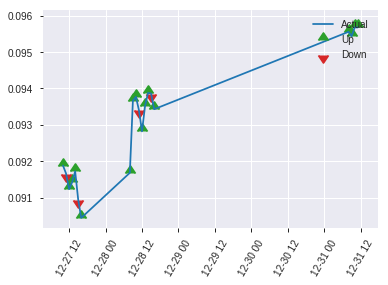


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20138594310659666
RMSE: 0.4487604518076394
LogLoss: 0.5853200072166287
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 307.9486967302692
Residual deviance: 261.0527232186164
AIC: 363.0527232186164
AUC: 0.7627831715210356
pr_auc: 0.7244053945672988
Gini: 0.5255663430420712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40105941617505675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   68   0.5667   (68.0/120.0)
1      10   93   0.0971   (10.0/103.0)
Total  62   161  0.3498   (78.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401059     0.704545  160
max f2                       0.294603     0.830537  183
max f0point5                 0.631966     0.704698  85
max accuracy                 0.631966     0.717489  85
max precision                0.949264     1         0
max recall                   0.0677238    1         219
max specificity              0.949264     1         0
max absolute_mcc             0.631966     0.430162  85
max min_per_class_accuracy   0.552226     0.675     108
max mean_per_class_accuracy  0.631966     0.709992  85

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.926078           2.16505   2.16505            1                0.938481  1                           0.938481            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.910084           2.16505   2.16505            1                0.915325  1                           0.929218            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.905519           1.08252   1.85576            0.5              0.906496  0.857143                    0.922726            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.889069           2.16505   1.92449            1                0.897913  0.888889                    0.917212            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.877018           2.16505   1.98463            1                0.884758  0.916667                    0.909099            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.814946           1.96823   1.97678            0.909091         0.846017  0.913043                    0.878929            0.0970874       0.203883                   96.8226   97.6783
    7        0.152466                    0.775508           0.78729   1.59195            0.363636         0.790699  0.735294                    0.850384            0.038835        0.242718                   -21.271   59.1947
    8        0.201794                    0.742815           1.7714    1.63581            0.818182         0.758529  0.755556                    0.827931            0.0873786       0.330097                   77.1403   63.5814
    9        0.300448                    0.678261           1.57458   1.61571            0.727273         0.707792  0.746269                    0.788482            0.15534         0.485437                   57.4581   61.5708
    10       0.399103                    0.62142            1.37776   1.55689            0.636364         0.652292  0.719101                    0.754817            0.135922        0.621359                   37.7758   55.6889
    11       0.502242                    0.538293           0.75306   1.39182            0.347826         0.582797  0.642857                    0.719492            0.0776699       0.699029                   -24.694   39.1817
    12       0.600897                    0.467579           0.984113  1.32488            0.454545         0.496846  0.61194                     0.682938            0.0970874       0.796117                   -1.5887   32.488
    13       0.699552                    0.410392           0.78729   1.24907            0.363636         0.438657  0.576923                    0.648488            0.0776699       0.873786                   -21.271   24.9066
    14       0.798206                    0.306879           0.688879  1.17983            0.318182         0.362755  0.544944                    0.613173            0.0679612       0.941748                   -31.1121  17.983
    15       0.896861                    0.169393           0.393645  1.09335            0.181818         0.247545  0.505                       0.572954            0.038835        0.980583                   -60.6355  9.33495
    16       1                           0.00785247         0.188265  1                  0.0869565        0.107534  0.461883                    0.524951           

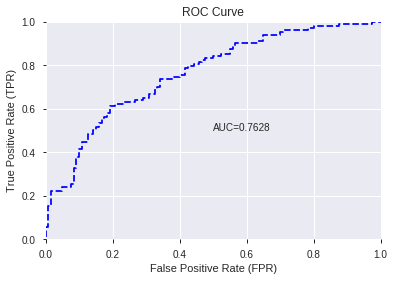

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


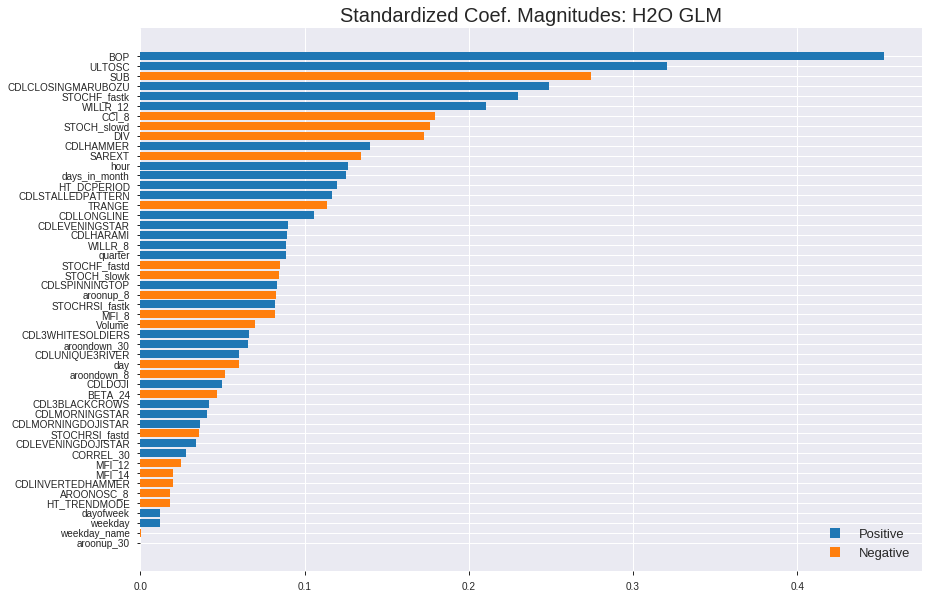

'log_likelihood'
--2019-08-26 21:19:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_211913_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_211913_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'ULTOSC',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_12',
 'CCI_8',
 'STOCH_slowd',
 'DIV',
 'CDLHAMMER',
 'SAREXT',
 'hour',
 'days_in_month',
 'HT_DCPERIOD',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'CDLLONGLINE',
 'CDLEVENINGSTAR',
 'CDLHARAMI',
 'WILLR_8',
 'quarter',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLSPINNINGTOP',
 'aroonup_8',
 'STOCHRSI_fastk',
 'MFI_8',
 'Volume',
 'CDL3WHITESOLDIERS',
 'aroondown_30',
 'CDLUNIQUE3RIVER',
 'day',
 'aroondown_8',
 'CDLDOJI',
 'BETA_24',
 'CDL3BLACKCROWS',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastd',
 'CDLEVENINGDOJISTAR',
 'CORREL_30',
 'MFI_12',
 'MFI_14',
 'CDLINVERTEDHAMMER',
 'AROONOSC_8',
 'HT_TRENDMODE',
 'dayofweek',
 'weekday',
 'weekday_name',
 'aroonup_30']

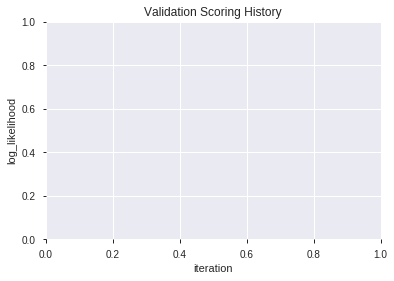

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_211923_model_2  0.767476  0.575076              0.293649  0.443025  0.196271
1  XGBoost_grid_1_AutoML_20190826_211923_model_3  0.761974  0.581186              0.325607  0.446106  0.199011
2  XGBoost_grid_1_AutoML_20190826_211923_model_6  0.756553  0.585968              0.294984  0.448531  0.201180
3               XGBoost_1_AutoML_20190826_211923  0.755178  0.583479              0.302023  0.447649  0.200389
4               XGBoost_3_AutoML_20190826_211923  0.754369  0.585592              0.321440  0.448575  0.201219
5  XGBoost_grid_1_AutoML_20190826_211923_model_1  0.752751  0.590119              0.294337  0.450198  0.202678
6  XGBoost_grid_1_AutoML_20190826_211923_model_4  0.752670  0.590689              0.349272  0.449954  0.202459
7               XGBoost_2_AutoML_20190826_211923  0.750728  0.594163              0.317233  0.451631  0.203971
8  XGBoost_grid_1_AutoML_20190826_211923_model_7  0.742476  0.604030              0.295672  0.456834  0.208697
9  XGBoost_grid_1_AutoML_20190826_211923_model_5  0.736570  0.625115              0.310316  0.463481  0.214814

variable  relative_importance  scaled_importance  percentage
0                  BOP          2122.985352           1.000000    0.249559
1                  DIV           751.567505           0.354014    0.088347
2         STOCHF_fastk           582.113953           0.274196    0.068428
3                 hour           499.418793           0.235244    0.058707
4               Volume           423.100800           0.199295    0.049736
5               TRANGE           401.466400           0.189105    0.047193
6                  SUB           313.447937           0.147645    0.036846
7               SAREXT           267.848694           0.126166    0.031486
8                CCI_8           233.391556           0.109936    0.027435
9       STOCHRSI_fastd           206.571945           0.097303    0.024283
10              ULTOSC           204.810699           0.096473    0.024076
11             BETA_24           189.403763           0.089216    0.022265
12         STOCH_slowk           180.198669           0.084880    0.021183
13         HT_DCPERIOD           178.308228           0.083989    0.020960
14  CDLCLOSINGMARUBOZU           161.084106           0.075876    0.018936
15         STOCH_slowd           155.364105           0.073182    0.018263
16            WILLR_12           147.075958           0.069278    0.017289
17           CDLHAMMER           144.785919           0.068199    0.017020
18               MFI_8           122.159195           0.057541    0.014360
19              MFI_12           120.899986           0.056948    0.014212
20                 day           113.251343           0.053345    0.013313
21              MFI_14           106.220055           0.050033    0.012486
22      STOCHRSI_fastk            91.093468           0.042908    0.010708
23           aroonup_8            81.763245           0.038513    0.009611
24         aroondown_8            78.444359           0.036950    0.009221
25          aroonup_30            72.598320           0.034196    0.008534
26          AROONOSC_8            68.422729           0.032229    0.008043
27           CORREL_30            67.425919           0.031760    0.007926
28        aroondown_30            63.897224           0.030098    0.007511
29             WILLR_8            54.457512           0.025651    0.006402
30             quarter            52.539288           0.024748    0.006176
31       days_in_month            47.192806           0.022229    0.005548
32      CDLSPINNINGTOP            36.435349           0.017162    0.004283
33        STOCHF_fastd            34.978321           0.016476    0.004112
34           CDLHARAMI            34.342827           0.016177    0.004037
35        weekday_name            30.835932           0.014525    0.003625
36   CDLSTALLEDPATTERN            26.040882           0.012266    0.003061
37           dayofweek            24.453104           0.011518    0.002874
38             CDLDOJI             6.250390           0.002944    0.000735
39         CDLLONGLINE             4.180976           0.001969    0.000491
40        HT_TRENDMODE             3.747174           0.001765    0.000440
41             weekday             2.373090           0.001118    0.000279

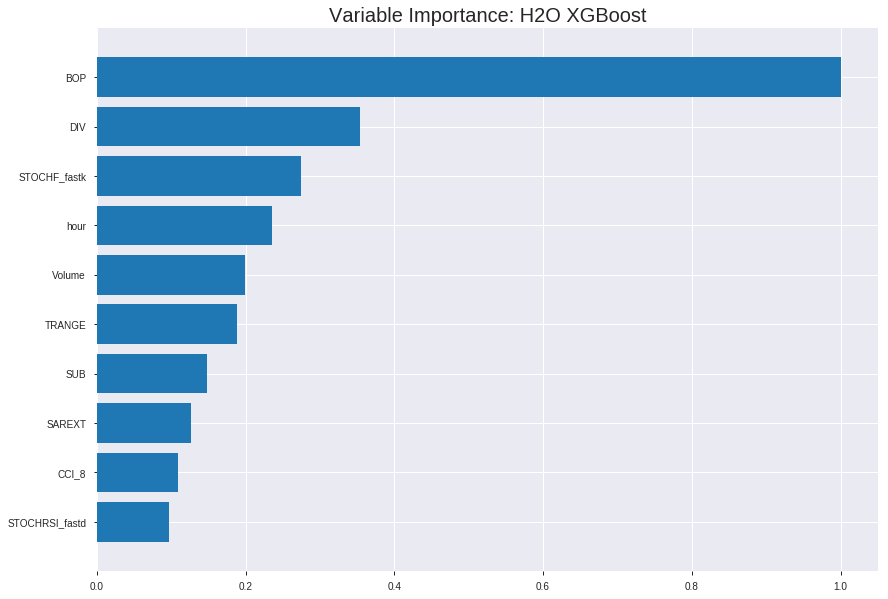

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_211923_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1370919824678767
RMSE: 0.3702593448758272
LogLoss: 0.440116943731936
Mean Per-Class Error: 0.16987513829619094
AUC: 0.9107725453985842
pr_auc: 0.8978163296942672
Gini: 0.8215450907971684
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5167754590511322: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      736  119  0.1392   (119.0/855.0)
1      141  562  0.2006   (141.0/703.0)
Total  877  681  0.1669   (260.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516775     0.812139  179
max f2                       0.310197     0.881435  280
max f0point5                 0.626        0.830361  123
max accuracy                 0.516775     0.833119  179
max precision                0.876604     1         0
max recall                   0.109998     1         383
max specificity              0.876604     1         0
max absolute_mcc             0.516775     0.662362  179
max min_per_class_accuracy   0.494182     0.819346  190
max mean_per_class_accuracy  0.516775     0.830125  179

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.8422             2.21622   2.21622            1                0.85575   1                           0.85575             0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.831046           2.21622   2.21622            1                0.836756  1                           0.846253            0.0227596       0.0455192                  121.622   121.622
    3        0.0301669                   0.821653           2.21622   2.21622            1                0.826065  1                           0.83981             0.0213371       0.0668563                  121.622   121.622
    4        0.0404365                   0.810504           2.21622   2.21622            1                0.815913  1                           0.833741            0.0227596       0.0896159                  121.622   121.622
    5        0.0500642                   0.800983           2.21622   2.21622            1                0.806237  1                           0.828451            0.0213371       0.110953                   121.622   121.622
    6        0.100128                    0.763272           2.15939   2.1878             0.974359         0.781155  0.987179                    0.804803            0.108108        0.219061                   115.939   118.78
    7        0.150193                    0.732313           2.07415   2.14992            0.935897         0.747901  0.970085                    0.785836            0.103841        0.322902                   107.415   114.992
    8        0.200257                    0.695782           2.07415   2.13098            0.935897         0.714897  0.961538                    0.768101            0.103841        0.426743                   107.415   113.098
    9        0.300385                    0.619177           1.77581   2.01259            0.801282         0.657333  0.90812                     0.731178            0.177809        0.604552                   77.5814   101.259
    10       0.399872                    0.54238            1.45841   1.87471            0.658065         0.582338  0.845907                    0.694147            0.145092        0.749644                   45.8413   87.4713
    11       0.5                         0.464524           1.00866   1.70128            0.455128         0.505191  0.767651                    0.656308            0.100996        0.85064                    0.866251  70.128
    12       0.600128                    0.369628           0.781358  1.5478             0.352564         0.416873  0.698396                    0.616359            0.0782361       0.928876                   -21.8642  54.7796
    13       0.699615                    0.282728           0.457541  1.39276            0.206452         0.32243   0.62844                     0.574562            0.0455192       0.974395                   -54.2459  39.276
    14       0.799743                    0.1911             0.113652  1.23261            0.0512821        0.234094  0.55618                     0.531935            0.0113798       0.985775                   -88.6348  23.2615
    15       0.899872                    0.119834           0.113652  1.10811            0.0512821        0.146931  0.5                         0.489096            0.0113798       0.997155                   -88.6348  10.8108
    16       1                           0.0879587          0.028413  1                  0.0128205        0.105208  0.45122                     0.450658            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19344288761307699
RMSE: 0.43982142695993903
LogLoss: 0.5725267034526904
Mean Per-Class Error: 0.2614077425842132
AUC: 0.7937456008044244
pr_auc: 0.7466234002411677
Gini: 0.5874912016088487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3335973620414734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  82   0.3644   (82.0/225.0)
1      35   186  0.1584   (35.0/221.0)
Total  178  268  0.2623   (117.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333597     0.760736  241
max f2                       0.155901     0.846709  328
max f0point5                 0.534277     0.749129  141
max accuracy                 0.333597     0.737668  241
max precision                0.828591     1         0
max recall                   0.0991223    1         393
max specificity              0.828591     1         0
max absolute_mcc             0.333597     0.487188  241
max min_per_class_accuracy   0.400825     0.723982  199
max mean_per_class_accuracy  0.333597     0.738592  241

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 41.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.77744            1.61448   1.61448            0.8              0.802276  0.8                         0.802276            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.766039           1.51357   1.56963            0.75             0.77047   0.777778                    0.78814             0.0135747       0.0316742                  51.3575   56.9633
    3        0.0313901                   0.741449           1.21086   1.4415             0.6              0.753436  0.714286                    0.775746            0.0135747       0.0452489                  21.086    44.15
    4        0.0403587                   0.726725           1.51357   1.45752            0.75             0.737574  0.722222                    0.767263            0.0135747       0.0588235                  51.3575   45.7516
    5        0.0515695                   0.722955           1.61448   1.49164            0.8              0.724923  0.73913                     0.758059            0.0180995       0.0769231                  61.448    49.1639
    6        0.100897                    0.694946           1.92637   1.70417            0.954545         0.707756  0.844444                    0.733467            0.0950226       0.171946                   92.6368   70.4173
    7        0.150224                    0.664946           1.46771   1.62653            0.727273         0.67801   0.80597                     0.715257            0.0723982       0.244344                   46.7709   62.6528
    8        0.201794                    0.637708           1.66713   1.6369             0.826087         0.650691  0.811111                    0.698757            0.0859729       0.330317                   66.7126   63.6903
    9        0.300448                    0.581181           1.69704   1.65665            0.840909         0.611238  0.820896                    0.670019            0.167421        0.497738                   69.7038   65.6649
    10       0.401345                    0.489604           1.16601   1.5333             0.577778         0.534695  0.759777                    0.635999            0.117647        0.615385                   16.6013   53.3305
    11       0.5                         0.398645           1.10078   1.44796            0.545455         0.44465   0.717489                    0.598244            0.108597        0.723982                   10.0782   44.7964
    12       0.600897                    0.333597           1.16601   1.40062            0.577778         0.367758  0.69403                     0.559543            0.117647        0.841629                   16.6013   40.0621
    13       0.699552                    0.256539           0.596257  1.28719            0.295455         0.297576  0.637821                    0.522599            0.0588235       0.900452                   -40.3743  28.7185
    14       0.800448                    0.163839           0.448467  1.18146            0.222222         0.204896  0.585434                    0.482552            0.0452489       0.945701                   -55.1533  18.1464
    15       0.899103                    0.124326           0.229329  1.07699            0.113636         0.13875   0.533666                    0.444829            0.0226244       0.968326                   -77.0671  7.69908
    16       1                           0.0923833          0.313927  1                  0.155556         0.109118  0.495516                    0.410956            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:19:27  0.653 sec   0                  0.5              0.693147            0.5             0                  1                0.54878                          0.5                0.693147              0.5               0                    1                  0.504484
    2019-08-26 21:19:27  0.716 sec   5                  0.47271          0.639763            0.846473        0.6698             1.98087          0.225289                         0.480782           0.655231              0.776209          0.736767             1.61448            0.295964
    2019-08-26 21:19:27  0.767 sec   10                 0.452037         0.600202            0.858032        0.800561           2.09309          0.232349                         0.467101           0.628389              0.783952          0.733069             1.61448            0.293722
    2019-08-26 21:19:27  0.816 sec   15                 0.43644          0.570288            0.864654        0.828521           2.09957          0.229782                         0.458411           0.611083              0.792539          0.745363             1.21086            0.293722
    2019-08-26 21:19:27  0.865 sec   20                 0.423944         0.546024            0.871229        0.837485           2.0777           0.231065                         0.452418           0.598887              0.796008          0.749726             1.21086            0.286996
    2019-08-26 21:19:27  0.921 sec   25                 0.414473         0.527346            0.876118        0.848747           2.21622          0.214377                         0.44812            0.589896              0.797265          0.749181             1.21086            0.280269
    2019-08-26 21:19:27  0.985 sec   30                 0.406319         0.511031            0.880698        0.858324           2.21622          0.213094                         0.445235           0.583726              0.798441          0.752826             1.21086            0.278027
    2019-08-26 21:19:27  1.045 sec   35                 0.399286         0.49717             0.887001        0.866772           2.21622          0.210526                         0.443041           0.579188              0.798482          0.758988             2.0181             0.29148
    2019-08-26 21:19:27  1.103 sec   40                 0.392937         0.4846              0.891289        0.874859           2.21622          0.207959                         0.442286           0.577318              0.796058          0.751423             2.0181             0.289238
    2019-08-26 21:19:27  1.160 sec   45                 0.387485         0.473672            0.895409        0.878187           2.21622          0.206033                         0.440857           0.574704              0.796561          0.754676             2.0181             0.275785
    2019-08-26 21:19:27  1.225 sec   50                 0.382672         0.464156            0.899431        0.883218           2.21622          0.195764                         0.440979           0.57486               0.794681          0.748777             1.61448            0.284753
    2019-08-26 21:19:27  1.284 sec   55                 0.37871          0.456317            0.902937        0.889304           2.21622          0.191271                         0.440558           0.573923              0.794862          0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2122.9853515625        1.0                    0.24955899379755922
DIV           751.5675048828125      0.354014456260692      0.08834749149420834
STOCHF_fastk  582.1139526367188      0.2741959346108006     0.06842806154485273
hour          499.4187927246094      0.23524363574013415    0.05870716503258742
Volume        423.1007995605469      0.1992952043918476     0.04973591067670839
---           ---                    ---                    ---
dayofweek     24.45310401916504      0.011518263185927191   0.0028744861709754585
CDLDOJI       6.250389575958252      0.0029441510613146793  0.0007347393764497074
CDLLONGLINE   4.180975914001465      0.0019693851919064353  0.000491477786891983
HT_TRENDMODE  3.7471742630004883     0.0017650495139981057  0.0004404839807162382
weekday       2.373089551925659      0.0011178077842972796  0.0002789589859083082


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.721311475409836)

('auc', 0.7674757281553398)

('logloss', 0.5750757245315883)

('mean_per_class_error', 0.29364886731391593)

('rmse', 0.4430245488019123)

('mse', 0.19627075084113793)

xgboost prediction progress: |████████████████████████████████████████████| 100%


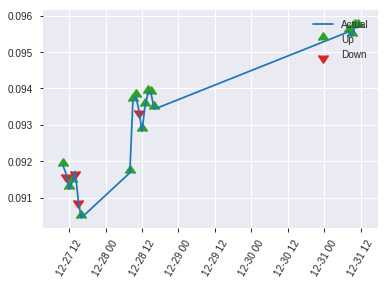


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19627075084113793
RMSE: 0.4430245488019123
LogLoss: 0.5750757245315883
Mean Per-Class Error: 0.29364886731391593
AUC: 0.7674757281553398
pr_auc: 0.7240740412795704
Gini: 0.5349514563106796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3599148690700531: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   53   0.4417   (53.0/120.0)
1      15   88   0.1456   (15.0/103.0)
Total  82   141  0.3049   (68.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359915     0.721311  140
max f2                       0.173459     0.83887   189
max f0point5                 0.611742     0.685579  79
max accuracy                 0.55627      0.704036  94
max precision                0.850781     1         0
max recall                   0.0996858    1         217
max specificity              0.850781     1         0
max absolute_mcc             0.359915     0.426707  140
max min_per_class_accuracy   0.506784     0.679612  107
max mean_per_class_accuracy  0.359915     0.706351  140

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 46.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.829521           2.16505   2.16505            1                0.838356  1                           0.838356            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.827673           2.16505   2.16505            1                0.828113  1                           0.834259            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.822559           2.16505   2.16505            1                0.827112  1                           0.832217            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.814227           1.08252   1.92449            0.5              0.819748  0.888889                    0.829446            0.00970874      0.0776699                  8.25243   92.4488
    5        0.0538117                   0.808345           2.16505   1.98463            1                0.811065  0.916667                    0.824851            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.766097           1.37776   1.69439            0.636364         0.783968  0.782609                    0.805298            0.0679612       0.174757                   37.7758   69.4386
    7        0.152466                    0.722484           1.96823   1.78298            0.909091         0.741211  0.823529                    0.784564            0.0970874       0.271845                   96.8226   78.2981
    8        0.201794                    0.695913           1.57458   1.73204            0.727273         0.7087    0.8                         0.766019            0.0776699       0.349515                   57.4581   73.2039
    9        0.300448                    0.63936            1.27935   1.58339            0.590909         0.663453  0.731343                    0.732341            0.126214        0.475728                   27.9347   58.3394
    10       0.399103                    0.577451           1.18094   1.48391            0.545455         0.611609  0.685393                    0.702497            0.116505        0.592233                   18.0936   48.391
    11       0.502242                    0.488271           0.941325  1.37249            0.434783         0.532693  0.633929                    0.667627            0.0970874       0.68932                    -5.86745  37.2486
    12       0.600897                    0.372278           1.27935   1.35719            0.590909         0.42052   0.626866                    0.627057            0.126214        0.815534                   27.9347   35.7195
    13       0.699552                    0.317201           0.885702  1.2907             0.409091         0.346567  0.596154                    0.587501            0.0873786       0.902913                   -11.4298  29.0702
    14       0.798206                    0.229503           0.196823  1.1555             0.0909091        0.260953  0.533708                    0.547141            0.0194175       0.92233                    -80.3177  15.5503
    15       0.896861                    0.142357           0.590468  1.09335            0.272727         0.178915  0.505                       0.506636            0.0582524       0.980583                   -40.9532  9.33495
    16       1                           0.0893853          0.188265  1                  0.0869565        0.118355  0.461883                    0.466589          

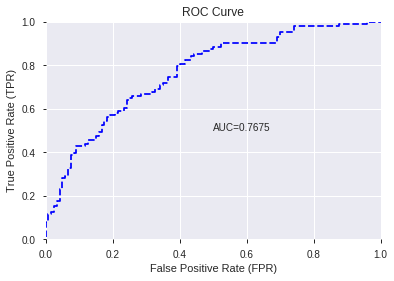

This function is available for GLM models only


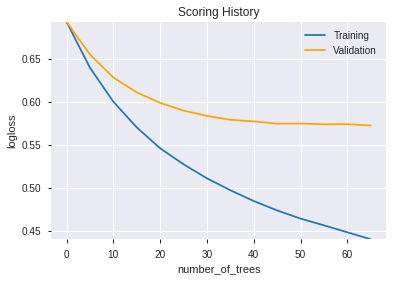

--2019-08-26 21:19:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_211923_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_211923_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'hour',
 'Volume',
 'TRANGE',
 'SUB',
 'SAREXT',
 'CCI_8',
 'STOCHRSI_fastd',
 'ULTOSC',
 'BETA_24',
 'STOCH_slowk',
 'HT_DCPERIOD',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowd',
 'WILLR_12',
 'CDLHAMMER',
 'MFI_8',
 'MFI_12',
 'day',
 'MFI_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'aroondown_8',
 'aroonup_30',
 'AROONOSC_8',
 'CORREL_30',
 'aroondown_30',
 'WILLR_8',
 'quarter',
 'days_in_month',
 'CDLSPINNINGTOP',
 'STOCHF_fastd',
 'CDLHARAMI',
 'weekday_name',
 'CDLSTALLEDPATTERN',
 'dayofweek',
 'CDLDOJI',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'weekday']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 926] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


65

['Volume',
 'hour',
 'BOP',
 'aroondown_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DM_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'MINUS_DM_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'MINUS_DM_24',
 'RSI_24',
 'WILLR_24',
 'MINUS_DM_30',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'ATR_12',
 'NATR_12',
 'ATR_14',
 'NATR_14',
 'ATR_20',
 'NATR_20',
 'ATR_24',
 'ATR_30',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_211945_model_8  0.766667  0.580960              0.295712  0.447941  0.200651
1  DeepLearning_grid_1_AutoML_20190826_211945_model_9  0.766343  0.589166              0.329814  0.449366  0.201929
2  DeepLearning_grid_1_AutoML_20190826_211945_model_6  0.765129  0.587247              0.329086  0.445569  0.198531
3  DeepLearning_grid_1_AutoML_20190826_211945_model_4  0.751133  0.717470              0.315170  0.483082  0.233368
4  DeepLearning_grid_1_AutoML_20190826_211945_model_3  0.741505  0.678862              0.328398  0.469455  0.220388
5               DeepLearning_1_AutoML_20190826_211945  0.738754  0.633182              0.349231  0.470103  0.220997
6  DeepLearning_grid_1_AutoML_20190826_211945_model_7  0.732039  0.647681              0.367314  0.476485  0.227038
7  DeepLearning_grid_1_AutoML_20190826_211945_model_2  0.731472  0.668366              0.393730  0.469156  0.220107
8  DeepLearning_grid_1_AutoML_20190826_211945_model_5  0.729288  0.606298              0.329045  0.457558  0.209360
9  DeepLearning_grid_1_AutoML_20190826_211945_model_1  0.712945  0.840892              0.351335  0.498662  0.248664

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.038120
1   CDLCLOSINGMARUBOZU             0.851005           0.851005    0.032440
2                  DIV             0.739682           0.739682    0.028197
3                 hour             0.710605           0.710605    0.027088
4                  SUB             0.695736           0.695736    0.026521
..                 ...                  ...                ...         ...
60               CMO_8             0.320824           0.320824    0.012230
61              RSI_14             0.318976           0.318976    0.012159
62              RSI_20             0.314530           0.314530    0.011990
63              RSI_24             0.312865           0.312865    0.011926
64         MINUS_DM_14             0.311578           0.311578    0.011877

[65 rows x 4 columns]

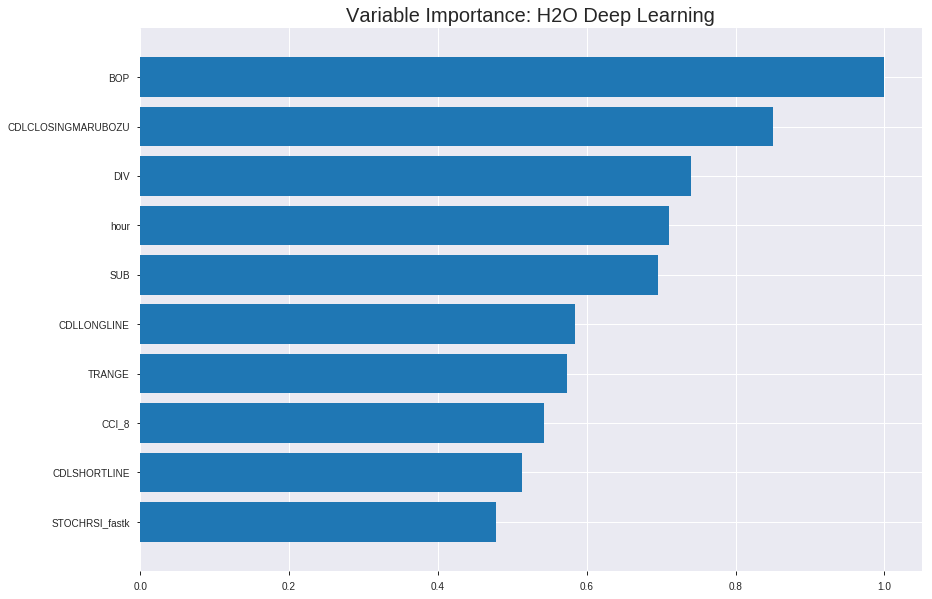

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_211945_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18769422207953623
RMSE: 0.43323691218493404
LogLoss: 0.5517510940130667
Mean Per-Class Error: 0.2741741741741741
AUC: 0.8052498481861363
pr_auc: 0.751067596228553
Gini: 0.6104996963722726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3610854832901045: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  425   0.4971   (425.0/855.0)
1      59   644   0.0839   (59.0/703.0)
Total  489  1069  0.3107   (484.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361085     0.726862  239
max f2                       0.206442     0.839033  309
max f0point5                 0.469216     0.710613  157
max accuracy                 0.451831     0.727214  171
max precision                0.892085     1         0
max recall                   0.063953     1         373
max specificity              0.892085     1         0
max absolute_mcc             0.418869     0.452327  201
max min_per_class_accuracy   0.437484     0.715789  183
max mean_per_class_accuracy  0.418869     0.725826  201

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 41.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.845927           2.0777    2.0777             0.9375           0.867131   0.9375                      0.867131            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.829142           1.80068   1.93919            0.8125           0.838345   0.875                       0.852738            0.0184922       0.0398293                  80.0676   93.9189
    3        0.0301669                   0.815349           2.06847   1.98045            0.933333         0.821643   0.893617                    0.842814            0.0199147       0.059744                   106.847   98.0449
    4        0.0404365                   0.802513           1.80068   1.93479            0.8125           0.809885   0.873016                    0.834451            0.0184922       0.0782361                  80.0676   93.4792
    5        0.0500642                   0.78502            1.62523   1.87526            0.733333         0.79596    0.846154                    0.827049            0.0156472       0.0938834                  62.5225   87.526
    6        0.100128                    0.681149           1.9605    1.91788            0.884615         0.730308   0.865385                    0.778678            0.0981508       0.192034                   96.0499   91.7879
    7        0.150193                    0.601653           1.79002   1.87526            0.807692         0.639015   0.846154                    0.732124            0.0896159       0.28165                    79.0021   87.526
    8        0.200257                    0.546875           1.59113   1.80423            0.717949         0.57291    0.814103                    0.69232             0.0796586       0.361309                   59.113    80.4227
    9        0.300385                    0.479503           1.49168   1.70005            0.673077         0.5108     0.767094                    0.631814            0.14936         0.510669                   49.1684   70.0046
    10       0.399872                    0.452055           1.28684   1.59724            0.580645         0.463334   0.720706                    0.589897            0.128023        0.638691                   28.6835   59.7241
    11       0.5                         0.433172           0.966043  1.47084            0.435897         0.442631   0.663671                    0.560406            0.0967283       0.73542                    -3.3957   47.0839
    12       0.600128                    0.406452           1.05128   1.40084            0.474359         0.420672   0.632086                    0.537092            0.105263        0.840683                   5.12821   40.0838
    13       0.699615                    0.352906           0.814996  1.31753            0.367742         0.383891   0.594495                    0.515306            0.0810811       0.921764                   -18.5004  31.753
    14       0.799743                    0.240909           0.426195  1.20593            0.192308         0.300828   0.544141                    0.488454            0.0426743       0.964438                   -57.3805  20.5935
    15       0.899872                    0.12238            0.241511  1.09862            0.108974         0.175853   0.49572                     0.453671            0.0241821       0.98862                    -75.8489  9.86236
    16       1                           0.00053701         0.113652  1                  0.0512821        0.0716189  0.45122                     0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20911494723737276
RMSE: 0.4572908781480041
LogLoss: 0.6114805949703023
Mean Per-Class Error: 0.2791050779286073
AUC: 0.7818300653594771
pr_auc: 0.757881260947646
Gini: 0.5636601307189542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3520519806640598: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  92   0.4089   (92.0/225.0)
1      33   188  0.1493   (33.0/221.0)
Total  166  280  0.2803   (125.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352052     0.750499  244
max f2                       0.186675     0.846709  322
max f0point5                 0.436513     0.73057   163
max accuracy                 0.436513     0.719731  163
max precision                0.87112      1         0
max recall                   0.00750364   1         399
max specificity              0.87112      1         0
max absolute_mcc             0.352052     0.456951  244
max min_per_class_accuracy   0.414141     0.697778  192
max mean_per_class_accuracy  0.352052     0.720895  244

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 38.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.853101           2.0181    2.0181             1                0.865143   1                           0.865143            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.8217             1.51357   1.79387            0.75             0.838638   0.888889                    0.853363            0.0135747       0.0361991                  51.3575   79.3866
    3        0.0313901                   0.807422           2.0181    1.87395            1                0.815176   0.928571                    0.839724            0.0226244       0.0588235                  101.81    87.395
    4        0.0403587                   0.781531           1.51357   1.79387            0.75             0.800498   0.888889                    0.831007            0.0135747       0.0723982                  51.3575   79.3866
    5        0.0515695                   0.734673           2.0181    1.84261            1                0.754638   0.913043                    0.814405            0.0226244       0.0950226                  101.81    84.2613
    6        0.100897                    0.600522           1.46771   1.65933            0.727273         0.671147   0.822222                    0.744368            0.0723982       0.167421                   46.7709   65.9326
    7        0.150224                    0.55131            1.55944   1.62653            0.772727         0.575613   0.80597                     0.688956            0.0769231       0.244344                   55.9441   62.6528
    8        0.201794                    0.510683           1.66713   1.6369             0.826087         0.532083   0.811111                    0.648866            0.0859729       0.330317                   66.7126   63.6903
    9        0.300448                    0.45912            1.55944   1.61147            0.772727         0.480178   0.798507                    0.593476            0.153846        0.484163                   55.9441   61.1468
    10       0.401345                    0.438541           1.25571   1.52203            0.622222         0.449318   0.75419                     0.557235            0.126697        0.61086                    25.5706   52.203
    11       0.5                         0.413936           0.917318  1.40271            0.454545         0.42589    0.695067                    0.53132             0.0904977       0.701357                   -8.2682   40.2715
    12       0.600897                    0.367776           1.07632   1.34791            0.533333         0.391523   0.66791                     0.507846            0.108597        0.809955                   7.63198   34.791
    13       0.699552                    0.304639           0.77972   1.26778            0.386364         0.335253   0.628205                    0.483506            0.0769231       0.886878                   -22.028   26.778
    14       0.800448                    0.194978           0.583007  1.18146            0.288889         0.251755   0.585434                    0.454294            0.0588235       0.945701                   -41.6993  18.1464
    15       0.899103                    0.0814751          0.275195  1.08202            0.136364         0.133676   0.53616                     0.419114            0.0271493       0.972851                   -72.4805  8.20234
    16       1                           0.00750364         0.26908   1                  0.133333         0.0465955  0.495516                    0.38


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:26:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:26:40  1 min 26.701 sec  625 obs/sec       0.842747  1             1313       0.449496         0.585674            0.184048       0.760061        0.691078           1.93919          0.347882                         0.474086           0.646173              0.100898         0.751503          0.717624             1.61448            0.311659
    2019-08-26 21:26:54  1 min 40.449 sec  922 obs/sec       8.61168   10            13417      0.444625         0.575266            0.201635       0.788151        0.731511           1.93919          0.29846                          0.469224           0.638643              0.119245         0.75992           0.744842             2.0181             0.316143
    2019-08-26 21:27:07  1 min 53.858 sec  1006 obs/sec      17.1938   20            26788      0.433237         0.551751            0.242008       0.80525         0.751068           2.0777           0.310655                         0.457291           0.611481              0.163473         0.78183           0.757881             2.0181             0.280269
    2019-08-26 21:27:21  2 min  7.492 sec  1065 obs/sec      26.6566   31            41531      0.426211         0.536109            0.266395       0.817353        0.769444           2.21622          0.300385                         0.457588           0.621625              0.162386         0.776933          0.757328             2.0181             0.295964
    2019-08-26 21:27:35  2 min 21.291 sec  1119 obs/sec      36.9949   43            57638      0.417741         0.518577            0.295262       0.82674         0.791406           2.0777           0.285623                         0.467123           0.67158               0.127116         0.764153          0.731357             1.21086            0.311659
    2019-08-26 21:27:49  2 min 34.973 sec  1155 obs/sec      47.344    55            73762      0.404553         0.487819            0.339056       0.844503        0.820828           2.21622          0.25353                          0.470105           0.713097              0.115932         0.763459          0.729108             1.21086            0.327354
    2019-08-26 21:27:50  2 min 36.505 sec  1153 obs/sec      47.344    55            73762      0.433237         0.551751            0.242008       0.80525         0.751068           2.0777           0.310655                         0.457291           0.611481              0.163473         0.78183           0.757881             2.0181             0.280269

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03812006311548727
CDLCLOSINGMARUBOZU  0.8510048985481262     0.8510048985481262   0.03244036044424341
DIV                 0.7396820783615112     0.7396820783615112   0.028196727512535606
hour                0.7106050848960876     0.7106050848960876   0.02708831068642505
SUB                 0.69573575258255       0.69573575258255     0.026521490800147842
---                 ---                    ---                  ---
CMO_8               0.32082417607307434    0.32082417607307434  0.012229837840879793
RSI_14              0.3189755082130432     0.3189755082130432   0.012159366505375835
RSI_20              0.3145295977592468     0.3145295977592468   0.011989888118271312
RSI_24              0.3128648102283478     0.3128648102283478   0.011926426312519564
MINUS_DM_14         0.31157830357551575    0.31157830357551575  0.011877384597715113


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7142857142857143)

('auc', 0.7666666666666667)

('logloss', 0.5809599886770975)

('mean_per_class_error', 0.28317152103559873)

('rmse', 0.44794090413741405)

('mse', 0.200651053599444)

deeplearning prediction progress: |███████████████████████████████████████| 100%


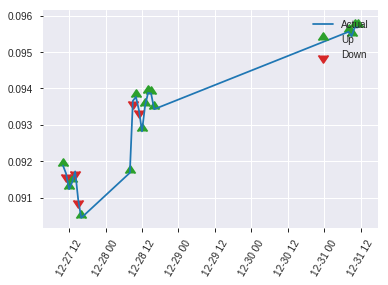


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.200651053599444
RMSE: 0.44794090413741405
LogLoss: 0.5809599886770975
Mean Per-Class Error: 0.28317152103559873
AUC: 0.7666666666666667
pr_auc: 0.7322425670940651
Gini: 0.5333333333333334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3929680444094935: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   50   0.4167   (50.0/120.0)
1      18   85   0.1748   (18.0/103.0)
Total  88   135  0.3049   (68.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392968     0.714286  134
max f2                       0.144908     0.841584  193
max f0point5                 0.415038     0.683012  116
max accuracy                 0.415038     0.713004  116
max precision                0.86689      1         0
max recall                   0.107248     1         203
max specificity              0.86689      1         0
max absolute_mcc             0.410865     0.433377  118
max min_per_class_accuracy   0.423818     0.7       108
max mean_per_class_accuracy  0.410865     0.716828  118

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 40.47 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.853333           2.16505    2.16505            1                0.858656   1                           0.858656            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.839528           2.16505    2.16505            1                0.846372   1                           0.853743            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.811331           2.16505    2.16505            1                0.827426   1                           0.846224            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.786981           2.16505    2.16505            1                0.808615   1                           0.837866            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.782471           1.44337    1.98463            0.666667         0.783174   0.916667                    0.824193            0.0194175       0.106796                   44.3366   98.4628
    6        0.103139                    0.653068           1.7714     1.88265            0.818182         0.715288   0.869565                    0.772108            0.0873786       0.194175                   77.1403   88.2651
    7        0.152466                    0.59794            1.7714     1.84666            0.818182         0.618543   0.852941                    0.722425            0.0873786       0.281553                   77.1403   84.6659
    8        0.201794                    0.534719           1.37776    1.73204            0.636364         0.569534   0.8                         0.685052            0.0679612       0.349515                   37.7758   73.2039
    9        0.300448                    0.472464           1.37776    1.61571            0.636364         0.497222   0.746269                    0.623376            0.135922        0.485437                   37.7758   61.5708
    10       0.399103                    0.445297           0.984113   1.45958            0.454545         0.45472    0.674157                    0.581686            0.0970874       0.582524                   -1.5887   45.9583
    11       0.502242                    0.423313           1.41199    1.44981            0.652174         0.433109   0.669643                    0.551175            0.145631        0.728155                   41.1988   44.9809
    12       0.600897                    0.394255           0.885702   1.35719            0.409091         0.406111   0.626866                    0.527358            0.0873786       0.815534                   -11.4298  35.7195
    13       0.699552                    0.318877           0.492056   1.23519            0.227273         0.356483   0.570513                    0.503261            0.0485437       0.864078                   -50.7944  23.5188
    14       0.798206                    0.241268           0.590468   1.1555             0.272727         0.280586   0.533708                    0.475739            0.0582524       0.92233                    -40.9532  15.5503
    15       0.896861                    0.117639           0.688879   1.10417            0.318182         0.176691   0.51                        0.442844            0.0679612       0.990291                   -31.1121  10.4175
    16       1                           0.00468554         0.0941325  1                  0.0434783        0.0730079  0.461883 

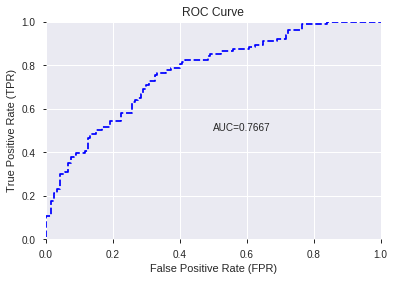

This function is available for GLM models only


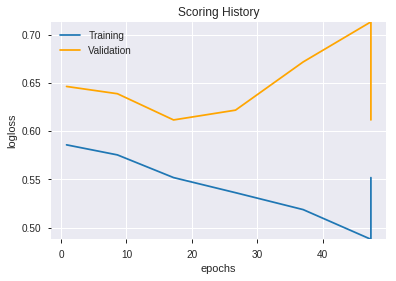

--2019-08-26 21:29:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_211945_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_211945_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'hour',
 'SUB',
 'CDLLONGLINE',
 'TRANGE',
 'CCI_8',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'NATR_20',
 'MINUS_DI_8',
 'WILLR_14',
 'CCI_14',
 'ADOSC',
 'WILLR_12',
 'WILLR_8',
 'CCI_12',
 'NATR_8',
 'aroondown_8',
 'WILLR_24',
 'Volume',
 'ROCR100_12',
 'MINUS_DM_12',
 'MINUS_DM_20',
 'MOM_12',
 'NATR_14',
 'NATR_12',
 'CDLENGULFING',
 'ATR_20',
 'MOM_8',
 'ATR_30',
 'ROCR100_8',
 'ROCP_8',
 'WILLR_20',
 'ATR_24',
 'RSI_8',
 'ROCR_8',
 'CDLMARUBOZU',
 'ROC_8',
 'CMO_12',
 'ATR_14',
 'ROCP_12',
 'ATR_8',
 'MINUS_DM_30',
 'CMO_24',
 'MINUS_DM_24',
 'ROCR_12',
 'MINUS_DM_8',
 'CMO_20',
 'ATR_12',
 'WILLR_30',
 'ROC_12',
 'CMO_14',
 'RSI_12',
 'CMO_8',
 'RSI_14',
 'RSI_20',
 'RSI_24',
 'MINUS_DM_14']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_212929_model_1  0.772977  0.569953              0.324919  0.439962  0.193566

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.552664           1.000000    0.152950
1   CDLCLOSINGMARUBOZU             0.278814           0.504491    0.077162
2                  SUB             0.215710           0.390309    0.059698
3          CDLLONGLINE             0.169589           0.306856    0.046934
4                 hour             0.153986           0.278625    0.042616
..                 ...                  ...                ...         ...
60          MINUS_DM_8             0.006572           0.011891    0.001819
61             NATR_20             0.005574           0.010086    0.001543
62         aroondown_8             0.004931           0.008921    0.001365
63            WILLR_20             0.003032           0.005485    0.000839
64               MOM_8             0.002615           0.004731    0.000724

[65 rows x 4 columns]

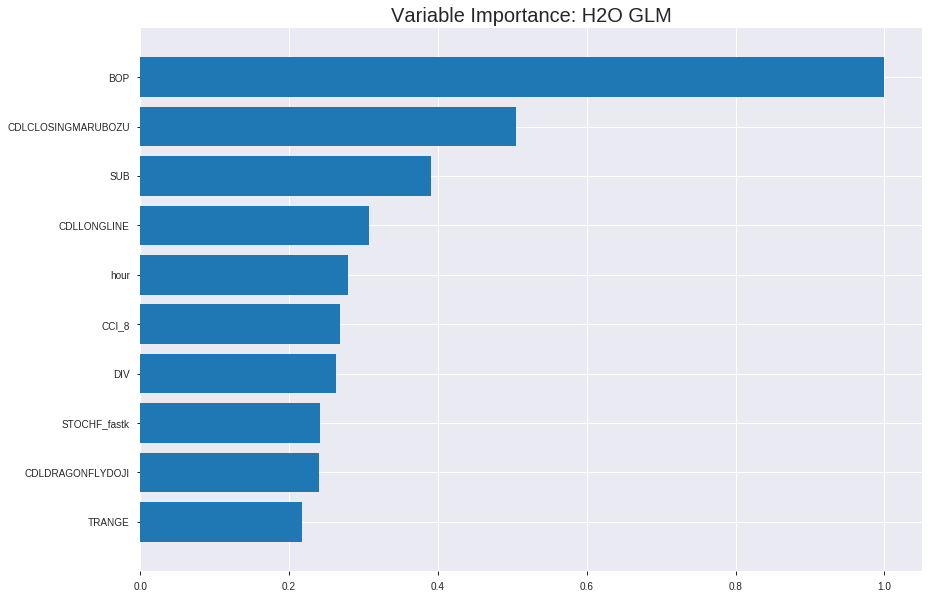

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_212929_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18990739285878386
RMSE: 0.43578365373059125
LogLoss: 0.5592955864632448
Null degrees of freedom: 1557
Residual degrees of freedom: 1492
Null deviance: 2144.993731790383
Residual deviance: 1742.765047419471
AIC: 1874.765047419471
AUC: 0.7815668854450019
pr_auc: 0.7260438724589278
Gini: 0.5631337708900037
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3263272872559095: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      410  445   0.5205   (445.0/855.0)
1      63   640   0.0896   (63.0/703.0)
Total  473  1085  0.3261   (508.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326327     0.715884  264
max f2                       0.218121     0.831099  319
max f0point5                 0.569261     0.676549  137
max accuracy                 0.458991     0.706033  196
max precision                0.944573     1         0
max recall                   0.0513898    1         387
max specificity              0.944573     1         0
max absolute_mcc             0.326327     0.421975  264
max min_per_class_accuracy   0.46305      0.704125  193
max mean_per_class_accuracy  0.430457     0.71089   212

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.894535           1.93919   1.93919            0.875            0.913517   0.875                       0.913517            0.0199147       0.0199147                  93.9189   93.9189
    2        0.0205392                   0.874366           1.93919   1.93919            0.875            0.884059   0.875                       0.898788            0.0199147       0.0398293                  93.9189   93.9189
    3        0.0301669                   0.850518           1.62523   1.83899            0.733333         0.864911   0.829787                    0.887976            0.0156472       0.0554765                  62.5225   83.8988
    4        0.0404365                   0.833038           1.93919   1.86444            0.875            0.840677   0.84127                     0.875964            0.0199147       0.0753912                  93.9189   86.4436
    5        0.0500642                   0.818351           2.06847   1.90367            0.933333         0.824055   0.858974                    0.865981            0.0199147       0.0953058                  106.847   90.3673
    6        0.100128                    0.745673           1.84685   1.87526            0.833333         0.784286   0.846154                    0.825133            0.0924609       0.187767                   84.6847   87.526
    7        0.150193                    0.693903           1.64796   1.79949            0.74359          0.718788   0.811966                    0.789685            0.0825036       0.27027                    64.7956   79.9492
    8        0.200257                    0.647942           1.67637   1.76871            0.75641          0.66952    0.798077                    0.759644            0.083926        0.354196                   67.6369   76.8711
    9        0.300385                    0.573714           1.37803   1.63848            0.621795         0.607804   0.739316                    0.709031            0.13798         0.492176                   37.8032   63.8485
    10       0.399872                    0.516563           1.11526   1.50831            0.503226         0.545564   0.680578                    0.668361            0.110953        0.603129                   11.5257   50.8308
    11       0.5                         0.450695           1.23597   1.45377            0.557692         0.4826     0.655969                    0.631161            0.123755        0.726885                   23.5967   45.377
    12       0.600128                    0.388924           0.93763   1.36765            0.423077         0.422818   0.617112                    0.5964              0.0938834       0.820768                   -6.23701  36.7654
    13       0.699615                    0.324162           0.900785  1.30126            0.406452         0.355095   0.587156                    0.562086            0.0896159       0.910384                   -9.92153  30.1265
    14       0.799743                    0.247134           0.440402  1.19348            0.198718         0.286766   0.538523                    0.527616            0.0440967       0.954481                   -55.9598  19.3484
    15       0.899872                    0.150182           0.32675   1.09704            0.147436         0.196483   0.495007                    0.490771            0.0327169       0.987198                   -67.325   9.70428
    16       1                           0.000322186        0.127859  1                  0.0576923        0.0957674  0.45122                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2060538898198494
RMSE: 0.4539315915640256
LogLoss: 0.6060885595065657
Null degrees of freedom: 445
Residual degrees of freedom: 380
Null deviance: 621.7697307743217
Residual deviance: 540.6309950798566
AIC: 672.6309950798566
AUC: 0.770296631473102
pr_auc: 0.7438524514059339
Gini: 0.540593262946204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2514297777040452: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  116  0.5156   (116.0/225.0)
1      21   200  0.095    (21.0/221.0)
Total  130  316  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25143      0.744879  280
max f2                       0.168795     0.841346  326
max f0point5                 0.452705     0.725389  169
max accuracy                 0.452705     0.715247  169
max precision                0.918024     1         0
max recall                   0.0246792    1         395
max specificity              0.918024     1         0
max absolute_mcc             0.452705     0.435053  169
max min_per_class_accuracy   0.393915     0.706667  203
max mean_per_class_accuracy  0.442535     0.714681  176

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 39.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.833858           2.0181    2.0181             1                0.8743     1                           0.8743              0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.81943            2.0181    2.0181             1                0.830816   1                           0.854974            0.0180995       0.040724                   101.81    101.81
    3        0.0313901                   0.788259           1.61448   1.87395            0.8              0.800896   0.928571                    0.83566             0.0180995       0.0588235                  61.448    87.395
    4        0.0403587                   0.77984            2.0181    1.90598            1                0.781985   0.944444                    0.823732            0.0180995       0.0769231                  101.81    90.5983
    5        0.0515695                   0.76176            1.61448   1.84261            0.8              0.771584   0.913043                    0.812396            0.0180995       0.0950226                  61.448    84.2613
    6        0.100897                    0.683418           1.28425   1.56963            0.636364         0.729398   0.777778                    0.771819            0.0633484       0.158371                   28.4245   56.9633
    7        0.150224                    0.644489           1.7429    1.62653            0.863636         0.661912   0.80597                     0.73573             0.0859729       0.244344                   74.2904   62.6528
    8        0.201794                    0.589257           1.4039    1.56963            0.695652         0.614475   0.777778                    0.704743            0.0723982       0.316742                   40.3895   56.9633
    9        0.300448                    0.528301           1.51357   1.55123            0.75             0.555859   0.768657                    0.655856            0.149321        0.466063                   51.3575   55.1226
    10       0.401345                    0.460447           1.43509   1.52203            0.711111         0.495149   0.75419                     0.615455            0.144796        0.61086                    43.5093   52.203
    11       0.5                         0.393273           1.00905   1.42081            0.5              0.427763   0.704036                    0.578421            0.0995475       0.710407                   0.904977  42.0814
    12       0.600897                    0.334321           0.852086  1.32532            0.422222         0.361095   0.656716                    0.54193             0.0859729       0.79638                    -14.7914  32.5319
    13       0.699552                    0.261072           0.963184  1.27425            0.477273         0.299762   0.63141                     0.507778            0.0950226       0.891403                   -3.68161  27.4249
    14       0.800448                    0.186818           0.448467  1.17016            0.222222         0.224284   0.579832                    0.472044            0.0452489       0.936652                   -55.1533  17.0159
    15       0.899103                    0.0898756          0.275195  1.07196            0.136364         0.136771   0.531172                    0.435255            0.0271493       0.963801                   -72.4805  7.19581
    16       1                           0.0160698          0.358773  1                  0.177778         0.0572363  0.495516                    0.3


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:29:29  0.000 sec   2            19        66            1.34924           1.37055
    2019-08-26 21:29:29  0.013 sec   4            12        66            1.33792           1.36084
    2019-08-26 21:29:29  0.026 sec   6            7.3       66            1.32361           1.34856
    2019-08-26 21:29:29  0.039 sec   8            4.5       66            1.30595           1.3334
    2019-08-26 21:29:29  0.053 sec   10           2.8       66            1.28478           1.31542
    2019-08-26 21:29:29  0.066 sec   12           1.7       66            1.26057           1.29541
    2019-08-26 21:29:29  0.079 sec   14           1.1       66            1.23475           1.27505
    2019-08-26 21:29:29  0.092 sec   16           0.67      66            1.20934           1.25637
    2019-08-26 21:29:29  0.106 sec   18           0.42      66            1.18618           1.24089
    2019-08-26 21:29:29  0.120 sec   20           0.26      66            1.16626           1.22912
    2019-08-26 21:29:29  0.133 sec   22           0.16      66            1.14986           1.2208
    2019-08-26 21:29:29  0.146 sec   24           0.1       66            1.13672           1.21548
    2019-08-26 21:29:29  0.159 sec   26           0.062     66            1.12642           1.21278
    2019-08-26 21:29:29  0.176 sec   28           0.039     66            1.11859           1.21218
    2019-08-26 21:29:29  0.190 sec   30           0.024     66            1.11282           1.21333
    2019-08-26 21:29:29  0.205 sec   32           0.015     66            1.10864           1.21585
    2019-08-26 21:29:29  0.219 sec   34           0.0093    66            1.10551           1.21942
    2019-08-26 21:29:29  0.235 sec   36           0.0058    66            1.10307           1.22356
    2019-08-26 21:29:29  0.251 sec   38           0.0036    66            1.10098           1.22767

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7054263565891472)

('auc', 0.7729773462783172)

('logloss', 0.5699525587604788)

('mean_per_class_error', 0.27261326860841417)

('rmse', 0.43996177558578964)

('mse', 0.19356636397660074)

glm prediction progress: |████████████████████████████████████████████████| 100%


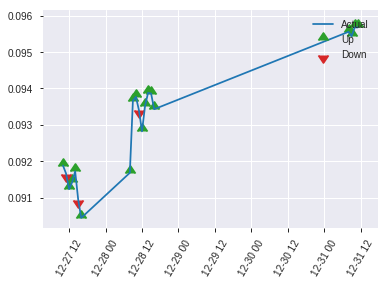


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19356636397660074
RMSE: 0.43996177558578964
LogLoss: 0.5699525587604788
Null degrees of freedom: 222
Residual degrees of freedom: 157
Null deviance: 307.9486967302692
Residual deviance: 254.19884120717356
AIC: 386.1988412071736
AUC: 0.7729773462783172
pr_auc: 0.7272944339637134
Gini: 0.5459546925566343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3186558276430129: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   64   0.5333   (64.0/120.0)
1      12   91   0.1165   (12.0/103.0)
Total  68   155  0.3408   (76.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318656     0.705426  154
max f2                       0.239457     0.831919  176
max f0point5                 0.539558     0.749354  70
max accuracy                 0.539558     0.73991   70
max precision                0.773591     0.894737  18
max recall                   0.0863574    1         214
max specificity              0.891611     0.991667  0
max absolute_mcc             0.539558     0.486691  70
max min_per_class_accuracy   0.43208      0.679612  107
max mean_per_class_accuracy  0.539558     0.727387  70

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 43.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.875768           1.44337   1.44337            0.666667         0.88617    0.666667                    0.88617             0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.850737           2.16505   1.73204            1                0.86139    0.8                         0.876258            0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.827773           1.08252   1.54646            0.5              0.841979   0.714286                    0.866464            0.00970874      0.0485437                  8.25243   54.6463
    4        0.0403587                   0.820034           2.16505   1.68393            1                0.820787   0.777778                    0.856313            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.803802           2.16505   1.80421            1                0.813175   0.833333                    0.845529            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.747995           1.96823   1.88265            0.909091         0.775531   0.869565                    0.812052            0.0970874       0.194175                   96.8226   88.2651
    7        0.152466                    0.691721           1.57458   1.78298            0.727273         0.718161   0.823529                    0.781675            0.0776699       0.271845                   57.4581   78.2981
    8        0.201794                    0.641852           1.96823   1.82826            0.909091         0.658039   0.844444                    0.751453            0.0970874       0.368932                   96.8226   82.8263
    9        0.300448                    0.547473           1.57458   1.74496            0.727273         0.589578   0.80597                     0.6983              0.15534         0.524272                   57.4581   74.4964
    10       0.399103                    0.47706            0.885702  1.53256            0.409091         0.516992   0.707865                    0.653482            0.0873786       0.61165                    -11.4298  53.2562
    11       0.502242                    0.426052           0.75306   1.37249            0.347826         0.44979    0.633929                    0.611653            0.0776699       0.68932                    -24.694   37.2486
    12       0.600897                    0.381974           0.885702  1.29257            0.409091         0.402685   0.597015                    0.577344            0.0873786       0.776699                   -11.4298  29.2566
    13       0.699552                    0.317021           1.08252   1.26294            0.5              0.348408   0.583333                    0.545059            0.106796        0.883495                   8.25243   26.2945
    14       0.798206                    0.229228           0.688879  1.19199            0.318182         0.274123   0.550562                    0.511572            0.0679612       0.951456                   -31.1121  19.1993
    15       0.896861                    0.145916           0.295234  1.09335            0.136364         0.192981   0.505                       0.476527            0.0291262       0.980583                   -70.4766  9.33495
    16       1                           0.0110422          0.188265  1                  0.0869565        0.0976989  0.461883                   

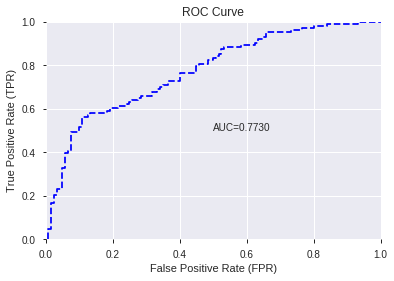

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


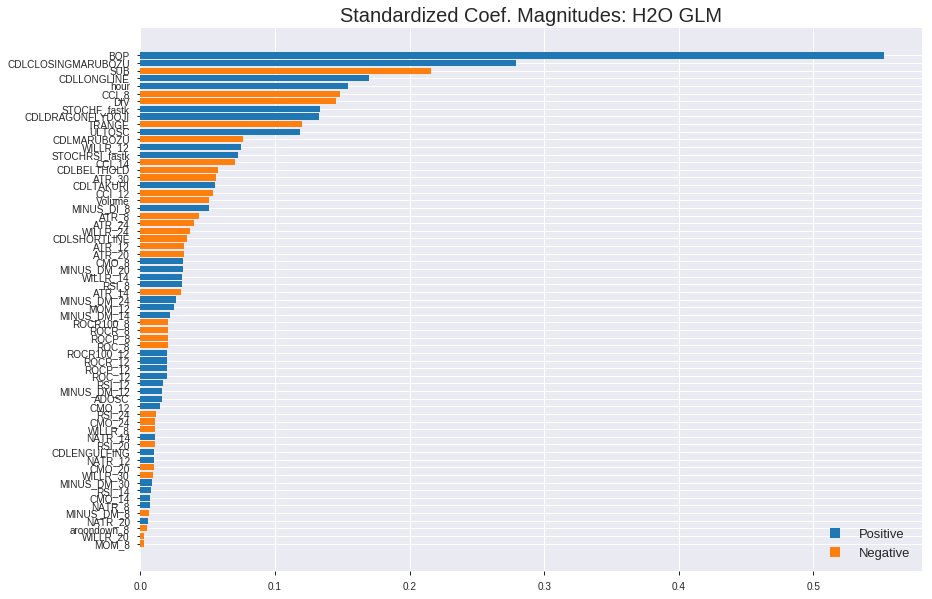

'log_likelihood'
--2019-08-26 21:29:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_212929_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_212929_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLLONGLINE',
 'hour',
 'CCI_8',
 'DIV',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'ULTOSC',
 'CDLMARUBOZU',
 'WILLR_12',
 'STOCHRSI_fastk',
 'CCI_14',
 'CDLBELTHOLD',
 'ATR_30',
 'CDLTAKURI',
 'CCI_12',
 'Volume',
 'MINUS_DI_8',
 'ATR_8',
 'ATR_24',
 'WILLR_24',
 'CDLSHORTLINE',
 'ATR_12',
 'ATR_20',
 'CMO_8',
 'MINUS_DM_20',
 'WILLR_14',
 'RSI_8',
 'ATR_14',
 'MINUS_DM_24',
 'MOM_12',
 'MINUS_DM_14',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'RSI_12',
 'MINUS_DM_12',
 'ADOSC',
 'CMO_12',
 'RSI_24',
 'CMO_24',
 'WILLR_8',
 'NATR_14',
 'RSI_20',
 'CDLENGULFING',
 'NATR_12',
 'CMO_20',
 'WILLR_30',
 'MINUS_DM_30',
 'RSI_14',
 'CMO_14',
 'NATR_8',
 'MINUS_DM_8',
 'NATR_20',
 'aroondown_8',
 'WILLR_20',
 'MOM_8']

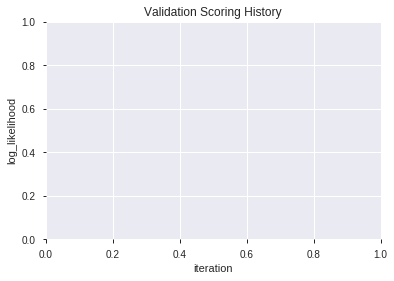

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_212939_model_1  0.764563  0.576632              0.329814  0.445167  0.198173
1  XGBoost_grid_1_AutoML_20190826_212939_model_2  0.762055  0.579746              0.292921  0.445984  0.198902
2  XGBoost_grid_1_AutoML_20190826_212939_model_4  0.760922  0.581067              0.312379  0.445723  0.198669
3  XGBoost_grid_1_AutoML_20190826_212939_model_3  0.756877  0.586524              0.300607  0.449430  0.201988
4  XGBoost_grid_1_AutoML_20190826_212939_model_6  0.751375  0.586853              0.322168  0.450663  0.203097
5               XGBoost_2_AutoML_20190826_212939  0.749191  0.594314              0.354814  0.452683  0.204922
6               XGBoost_1_AutoML_20190826_212939  0.746845  0.596348              0.318608  0.452710  0.204947
7               XGBoost_3_AutoML_20190826_212939  0.746036  0.589642              0.361084  0.451011  0.203411
8  XGBoost_grid_1_AutoML_20190826_212939_model_7  0.744579  0.595697              0.309628  0.454342  0.206427
9  XGBoost_grid_1_AutoML_20190826_212939_model_5  0.741828  0.619230              0.317961  0.461284  0.212783

variable  relative_importance  scaled_importance  percentage
0                  BOP          2385.187500           1.000000    0.268415
1                  DIV           834.854370           0.350016    0.093950
2               TRANGE           547.483215           0.229535    0.061611
3         STOCHF_fastk           545.277710           0.228610    0.061362
4               Volume           504.657745           0.211580    0.056791
5                 hour           378.195282           0.158560    0.042560
6       STOCHRSI_fastk           332.520142           0.139410    0.037420
7                  SUB           304.022430           0.127463    0.034213
8                CCI_8           256.880066           0.107698    0.028908
9   CDLCLOSINGMARUBOZU           213.489105           0.089506    0.024025
10              ULTOSC           139.260757           0.058386    0.015672
11               ATR_8           127.332336           0.053385    0.014329
12            WILLR_14           124.979172           0.052398    0.014064
13              ATR_30           117.904510           0.049432    0.013268
14              CCI_14           112.665237           0.047235    0.012679
15          MINUS_DI_8           109.515915           0.045915    0.012324
16         aroondown_8            94.946373           0.039807    0.010685
17             NATR_20            93.889893           0.039364    0.010566
18              ATR_14            87.429489           0.036655    0.009839
19              CCI_12            85.355530           0.035786    0.009605
20               ADOSC            84.663445           0.035496    0.009528
21            WILLR_12            78.449081           0.032890    0.008828
22         MINUS_DM_20            76.616257           0.032122    0.008622
23               MOM_8            74.101662           0.031067    0.008339
24    CDLDRAGONFLYDOJI            73.445793           0.030792    0.008265
25              ROC_12            72.099121           0.030228    0.008114
26          MINUS_DM_8            71.871521           0.030132    0.008088
27         CDLBELTHOLD            67.093002           0.028129    0.007550
28              NATR_8            64.039619           0.026849    0.007207
29        CDLSHORTLINE            63.101719           0.026456    0.007101
30             WILLR_8            62.065277           0.026021    0.006984
31              CMO_20            61.864147           0.025937    0.006962
32         MINUS_DM_14            59.073559           0.024767    0.006648
33             NATR_12            55.827736           0.023406    0.006283
34              ATR_12            46.583176           0.019530    0.005242
35            WILLR_20            42.881493           0.017978    0.004826
36              CMO_24            38.660877           0.016209    0.004351
37               ROC_8            37.070560           0.015542    0.004172
38              CMO_12            34.013569           0.014260    0.003828
39             NATR_14            33.613811           0.014093    0.003783
40              MOM_12            33.375771           0.013993    0.003756
41         MINUS_DM_12            31.408436           0.013168    0.003535
42              ATR_20            29.132471           0.012214    0.003278
43         MINUS_DM_24            28.384285           0.011900    0.003194
44            WILLR_24            25.567137           0.010719    0.002877
45            WILLR_30            25.097458           0.010522    0.002824
46               CMO_8            24.174442           0.010135    0.002720
47         MINUS_DM_30            24.046879           0.010082    0.002706
48              ATR_24            20.126106           0.008438    0.002265
49             ROCP_12            16.294758           0.006832    0.001834
50              CMO_14            16.104267           0.006752    0.001812
51         CDLLONGLINE             7.591972           0.003183    0.000854
52               RSI_8             3.30

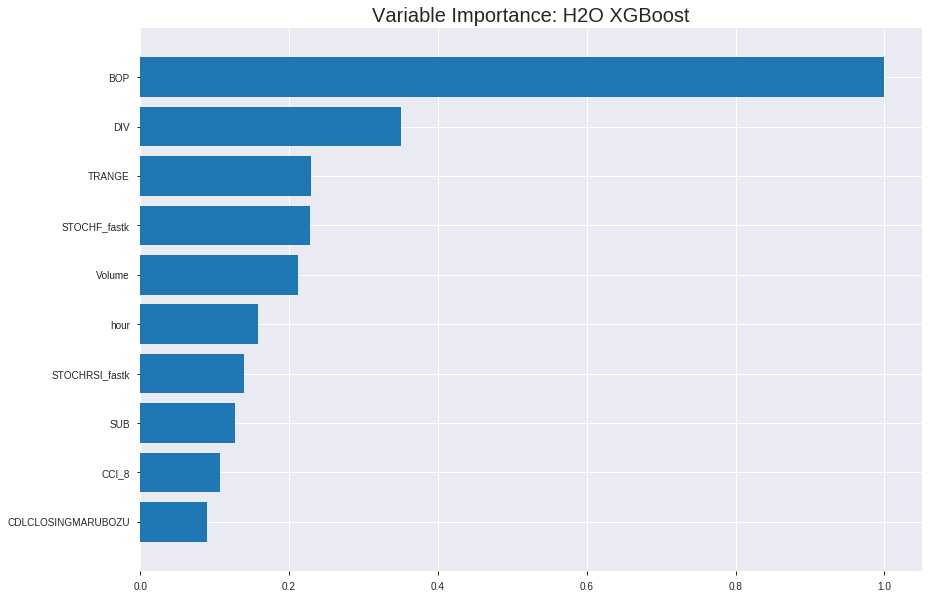

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_212939_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12601986324890074
RMSE: 0.3549927650655725
LogLoss: 0.4105173679774516
Mean Per-Class Error: 0.15528686581318163
AUC: 0.9279903171869931
pr_auc: 0.9167219867360232
Gini: 0.8559806343739862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4259628653526306: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      662  193  0.2257   (193.0/855.0)
1      62   641  0.0882   (62.0/703.0)
Total  724  834  0.1637   (255.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425963     0.834092  221
max f2                       0.29249      0.886846  283
max f0point5                 0.606642     0.859803  139
max accuracy                 0.517612     0.847882  179
max precision                0.947275     1         0
max recall                   0.162114     1         340
max specificity              0.947275     1         0
max absolute_mcc             0.517612     0.692215  179
max min_per_class_accuracy   0.48911      0.840683  192
max mean_per_class_accuracy  0.517612     0.844713  179

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.903877           2.21622   2.21622            1                0.921863   1                           0.921863            0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.882977           2.21622   2.21622            1                0.895106   1                           0.908484            0.0227596       0.0455192                  121.622   121.622
    3        0.0301669                   0.865796           2.21622   2.21622            1                0.870255   1                           0.896284            0.0213371       0.0668563                  121.622   121.622
    4        0.0404365                   0.852297           2.21622   2.21622            1                0.859789   1                           0.887015            0.0227596       0.0896159                  121.622   121.622
    5        0.0500642                   0.84385            2.21622   2.21622            1                0.849716   1                           0.879842            0.0213371       0.110953                   121.622   121.622
    6        0.100128                    0.793226           2.21622   2.21622            1                0.817589   1                           0.848716            0.110953        0.221906                   121.622   121.622
    7        0.150193                    0.745281           2.07415   2.16886            0.935897         0.768353   0.978632                    0.821928            0.103841        0.325747                   107.415   116.886
    8        0.200257                    0.710606           2.10256   2.15229            0.948718         0.729311   0.971154                    0.798774            0.105263        0.43101                    110.256   115.229
    9        0.300385                    0.625575           1.90367   2.06942            0.858974         0.670472   0.933761                    0.756006            0.190612        0.621622                   90.3673   106.942
    10       0.399872                    0.552656           1.42982   1.91029            0.645161         0.588725   0.861958                    0.714387            0.142248        0.763869                   42.9817   91.0286
    11       0.5                         0.460708           1.12231   1.75249            0.50641          0.504026   0.790757                    0.672261            0.112376        0.876245                   12.2315   75.2489
    12       0.600128                    0.361658           0.6535    1.56913            0.294872         0.410644   0.708021                    0.628612            0.0654339       0.941679                   -34.65    56.9128
    13       0.699615                    0.265552           0.357454  1.39683            0.16129          0.314204   0.630275                    0.583902            0.0355619       0.97724                    -64.2546  39.6826
    14       0.799743                    0.176661           0.198891  1.24684            0.0897436        0.224472   0.5626                      0.538901            0.0199147       0.997155                   -80.1109  24.6844
    15       0.899872                    0.110295           0.028413  1.11127            0.0128205        0.138621   0.501427                    0.494362            0.00284495      1                          -97.1587  11.127
    16       1                           0.0435596          0         1                  0                0.0815287  0.45122                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1945205400499915
RMSE: 0.4410448277102811
LogLoss: 0.5740036018208734
Mean Per-Class Error: 0.2624534942182002
AUC: 0.7891905480140775
pr_auc: 0.7520368062743199
Gini: 0.578381096028155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3206714987754822: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  92   0.4089   (92.0/225.0)
1      33   188  0.1493   (33.0/221.0)
Total  166  280  0.2803   (125.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320671     0.750499  251
max f2                       0.103599     0.84818   365
max f0point5                 0.451403     0.744256  176
max accuracy                 0.426428     0.737668  193
max precision                0.871207     1         0
max recall                   0.0707954    1         391
max specificity              0.871207     1         0
max absolute_mcc             0.426428     0.475308  193
max min_per_class_accuracy   0.414732     0.728889  199
max mean_per_class_accuracy  0.426428     0.737547  193

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 41.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.807274           1.61448   1.61448            0.8              0.840064  0.8                         0.840064            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.790831           1.51357   1.56963            0.75             0.798473  0.777778                    0.821579            0.0135747       0.0316742                  51.3575   56.9633
    3        0.0313901                   0.78016            2.0181    1.7298             1                0.785074  0.857143                    0.808542            0.0226244       0.0542986                  101.81    72.98
    4        0.0403587                   0.764454           2.0181    1.79387            1                0.774208  0.888889                    0.800912            0.0180995       0.0723982                  101.81    79.3866
    5        0.0515695                   0.748287           1.61448   1.75487            0.8              0.754288  0.869565                    0.790776            0.0180995       0.0904977                  61.448    75.4869
    6        0.100897                    0.702073           1.46771   1.61448            0.727273         0.726935  0.8                         0.759565            0.0723982       0.162896                   46.7709   61.448
    7        0.150224                    0.66917            1.65117   1.62653            0.818182         0.68451   0.80597                     0.73492             0.081448        0.244344                   65.1172   62.6528
    8        0.201794                    0.64014            1.57938   1.61448            0.782609         0.653496  0.8                         0.714112            0.081448        0.325792                   57.9382   61.448
    9        0.300448                    0.577059           1.46771   1.56629            0.727273         0.607591  0.776119                    0.679135            0.144796        0.470588                   46.7709   56.6286
    10       0.401345                    0.490837           1.43509   1.5333             0.711111         0.538242  0.759777                    0.643715            0.144796        0.615385                   43.5093   53.3305
    11       0.5                         0.414216           1.19251   1.46606            0.590909         0.447577  0.726457                    0.605015            0.117647        0.733032                   19.2513   46.6063
    12       0.600897                    0.337494           0.896933  1.3705             0.444444         0.376111  0.679104                    0.56658             0.0904977       0.823529                   -10.3067  37.05
    13       0.699552                    0.271112           0.77972   1.28719            0.386364         0.306     0.637821                    0.529831            0.0769231       0.900452                   -22.028   28.7185
    14       0.800448                    0.171333           0.358773  1.17016            0.177778         0.220408  0.579832                    0.490828            0.0361991       0.936652                   -64.1227  17.0159
    15       0.899103                    0.105155           0.458659  1.09209            0.227273         0.135982  0.541147                    0.451893            0.0452489       0.9819                     -54.1341  9.20888
    16       1                           0.040208           0.179387  1                  0.0888889        0.081992  0.495516                    0.414571            0.01


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:29:43  0.018 sec   0                  0.5              0.693147            0.5             0                  1                0.54878                          0.5                0.693147              0.5               0                    1                  0.504484
    2019-08-26 21:29:43  0.090 sec   5                  0.466136         0.627167            0.854718        0.817263           2.21622          0.242619                         0.479782           0.653216              0.760814          0.704661             1.1532             0.275785
    2019-08-26 21:29:43  0.138 sec   10                 0.441822         0.580823            0.869952        0.845151           2.21622          0.225289                         0.46705            0.627963              0.770297          0.732444             1.61448            0.298206
    2019-08-26 21:29:43  0.189 sec   15                 0.424952         0.548263            0.876196        0.852              2.21622          0.224005                         0.457493           0.608574              0.782826          0.757108             1.61448            0.280269
    2019-08-26 21:29:43  0.240 sec   20                 0.41231          0.523274            0.8811          0.857722           2.21622          0.209243                         0.452191           0.597357              0.782966          0.752172             1.61448            0.275785
    2019-08-26 21:29:43  0.293 sec   25                 0.401109         0.501027            0.890863        0.870372           2.21622          0.199615                         0.448216           0.588933              0.787652          0.756038             1.61448            0.280269
    2019-08-26 21:29:44  0.342 sec   30                 0.391095         0.481098            0.89934         0.88131            2.21622          0.191913                         0.446156           0.584546              0.786073          0.749756             1.61448            0.282511
    2019-08-26 21:29:44  0.394 sec   35                 0.382788         0.464631            0.906112        0.889334           2.21622          0.182927                         0.444861           0.581738              0.786757          0.748953             1.61448            0.278027
    2019-08-26 21:29:44  0.446 sec   40                 0.375962         0.451303            0.912608        0.898108           2.21622          0.184211                         0.442568           0.577134              0.788798          0.752723             1.61448            0.278027
    2019-08-26 21:29:44  0.499 sec   45                 0.370096         0.439753            0.916742        0.903498           2.21622          0.172657                         0.441776           0.575391              0.788547          0.752681             1.61448            0.278027
    2019-08-26 21:29:44  0.550 sec   50                 0.366021         0.431657            0.91942         0.90629            2.21622          0.168164                         0.441388           0.574525              0.788678          0.754889             1.61448            0.280269
    2019-08-26 21:29:44  0.611 sec   55                 0.362444         0.424539            0.921687        0.909034           2.21622          0.169448                         0.441163           0.574041              0.789512          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2385.1875              1.0                    0.26841512352210994
DIV           834.8543701171875      0.35001624405510573    0.09394965338279619
TRANGE        547.4832153320312      0.229534665652923      0.06161057563383553
STOCHF_fastk  545.2777099609375      0.22860999814938554    0.061362380891656645
Volume        504.6577453613281      0.21157990529521395    0.05679124641461118
---           ---                    ---                    ---
CDLLONGLINE   7.591972351074219      0.0031829666854594108  0.0008543563960443487
RSI_8         3.3010854721069336     0.0013839941187461923  0.0003714849523371329
RSI_20        2.9407176971435547     0.0012329083969891486  0.00033093125966928886
ROCR100_8     2.9050445556640625     0.0012179522807595053  0.00032691681188409816
RSI_14        2.7558987140655518     0.0011554222525757625  0.00031013280664531783


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.711111111111111)

('auc', 0.7645631067961165)

('logloss', 0.5766318013301923)

('mean_per_class_error', 0.29215210355987054)

('rmse', 0.445166663485382)

('mse', 0.1981733582787073)

xgboost prediction progress: |████████████████████████████████████████████| 100%


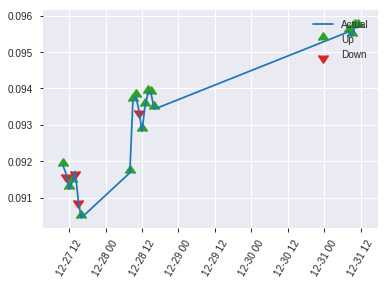


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1981733582787073
RMSE: 0.445166663485382
LogLoss: 0.5766318013301923
Mean Per-Class Error: 0.29215210355987054
AUC: 0.7645631067961165
pr_auc: 0.726342869135084
Gini: 0.529126213592233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2262790948152542: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   71   0.5917   (71.0/120.0)
1      7    96   0.068    (7.0/103.0)
Total  56   167  0.3498   (78.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.226279     0.711111  166
max f2                       0.183798     0.841751  181
max f0point5                 0.564559     0.696056  81
max accuracy                 0.564559     0.70852   81
max precision                0.87282      1         0
max recall                   0.0763449    1         217
max specificity              0.87282      1         0
max absolute_mcc             0.474389     0.414991  105
max min_per_class_accuracy   0.474389     0.699029  105
max mean_per_class_accuracy  0.474389     0.707848  105

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.847233           2.16505    2.16505            1                0.860018   1                           0.860018            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.840905           2.16505    2.16505            1                0.842364   1                           0.852957            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.837448           2.16505    2.16505            1                0.840119   1                           0.849289            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.83288            1.08252    1.92449            0.5              0.835402   0.888889                    0.846203            0.00970874      0.0776699                  8.25243   92.4488
    5        0.0538117                   0.82061            2.16505    1.98463            1                0.825236   0.916667                    0.840961            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.783005           2.16505    2.07092            1                0.79886    0.956522                    0.820826            0.106796        0.213592                   116.505   107.092
    7        0.152466                    0.738646           0.984113   1.7193             0.454545         0.760711   0.794118                    0.801377            0.0485437       0.262136                   -1.5887   71.9303
    8        0.201794                    0.688848           1.57458    1.68393            0.727273         0.716388   0.777778                    0.780602            0.0776699       0.339806                   57.4581   68.3927
    9        0.300448                    0.620465           1.27935    1.55108            0.590909         0.65201    0.716418                    0.738378            0.126214        0.466019                   27.9347   55.108
    10       0.399103                    0.552579           1.47617    1.53256            0.681818         0.582381   0.707865                    0.699817            0.145631        0.61165                    47.6169   53.2562
    11       0.502242                    0.453589           0.941325   1.41115            0.434783         0.505986   0.651786                    0.660012            0.0970874       0.708738                   -5.86745  41.1148
    12       0.600897                    0.366585           0.78729    1.30872            0.363636         0.404812   0.604478                    0.618114            0.0776699       0.786408                   -21.271   30.8723
    13       0.699552                    0.274277           0.984113   1.26294            0.454545         0.317298   0.583333                    0.575691            0.0970874       0.883495                   -1.5887   26.2945
    14       0.798206                    0.195629           0.688879   1.19199            0.318182         0.227088   0.550562                    0.532605            0.0679612       0.951456                   -31.1121  19.1993
    15       0.896861                    0.129663           0.393645   1.10417            0.181818         0.161572   0.51                        0.491792            0.038835        0.990291                   -60.6355  10.4175
    16       1                           0.0527524          0.0941325  1                  0.0434783        0.0932791  0.461883  

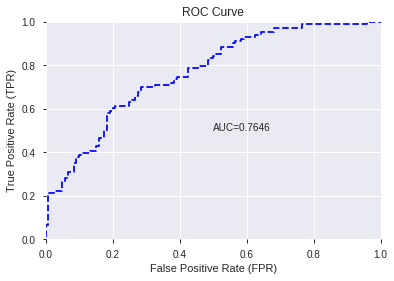

This function is available for GLM models only


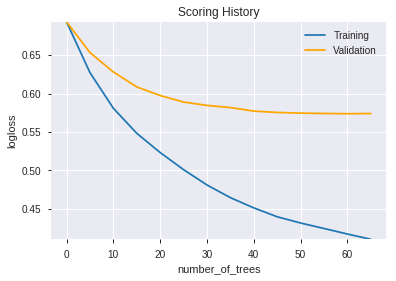

--2019-08-26 21:29:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_212939_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_212939_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'Volume',
 'hour',
 'STOCHRSI_fastk',
 'SUB',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'ATR_8',
 'WILLR_14',
 'ATR_30',
 'CCI_14',
 'MINUS_DI_8',
 'aroondown_8',
 'NATR_20',
 'ATR_14',
 'CCI_12',
 'ADOSC',
 'WILLR_12',
 'MINUS_DM_20',
 'MOM_8',
 'CDLDRAGONFLYDOJI',
 'ROC_12',
 'MINUS_DM_8',
 'CDLBELTHOLD',
 'NATR_8',
 'CDLSHORTLINE',
 'WILLR_8',
 'CMO_20',
 'MINUS_DM_14',
 'NATR_12',
 'ATR_12',
 'WILLR_20',
 'CMO_24',
 'ROC_8',
 'CMO_12',
 'NATR_14',
 'MOM_12',
 'MINUS_DM_12',
 'ATR_20',
 'MINUS_DM_24',
 'WILLR_24',
 'WILLR_30',
 'CMO_8',
 'MINUS_DM_30',
 'ATR_24',
 'ROCP_12',
 'CMO_14',
 'CDLLONGLINE',
 'RSI_8',
 'RSI_20',
 'ROCR100_8',
 'RSI_14']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

72

['BBANDS_lowerband_20_1_5',
 'MAVP_20_3',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_24_0_4',
 'BOP',
 'ADX_8',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'ROCR100_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'CCI_12',
 'MINUS_DM_12',
 'ROCR100_12',
 'TRIX_12',
 'WILLR_12',
 'ADXR_14',
 'aroondown_14',
 'aroonup_14',
 'MFI_14',
 'MINUS_DI_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroonup_20',
 'DX_20',
 'MINUS_DM_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROCP_20',
 'WILLR_20',
 'aroonup_24',
 'AROONOSC_24',
 'CCI_24',
 'MACDFIX_hist_24',
 'MFI_24',
 'MINUS_DM_24',
 'MOM_24',
 'PLUS_DI_24',
 'ROCR100_24',
 'WILLR_24',
 'CMO_30',
 'DX_30',
 'MINUS_DI_30',
 'PLUS_DM_30',
 'ROCP_30',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'NATR_12',
 'ATR_14',
 'ATR_20',
 'TRANGE',
 'AVGPRICE',
 'CDLBELTHOLD',
 'CDLCLOSINGMA

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_213057_model_6  0.759628  0.591580              0.287379  0.446528  0.199387
1  DeepLearning_grid_1_AutoML_20190826_213057_model_9  0.756715  0.599648              0.340210  0.454391  0.206471
2  DeepLearning_grid_1_AutoML_20190826_213057_model_8  0.754288  0.591766              0.341586  0.448166  0.200852
3  DeepLearning_grid_1_AutoML_20190826_213057_model_7  0.744256  0.631454              0.338107  0.456085  0.208013
4  DeepLearning_grid_1_AutoML_20190826_213057_model_5  0.739320  0.605031              0.291505  0.454575  0.206639
5  DeepLearning_grid_1_AutoML_20190826_213057_model_3  0.733657  0.692025              0.306108  0.475906  0.226487
6               DeepLearning_1_AutoML_20190826_213057  0.721440  0.695846              0.390251  0.488001  0.238145
7  DeepLearning_grid_1_AutoML_20190826_213057_model_4  0.719094  0.820566              0.395105  0.511948  0.262091
8  DeepLearning_grid_1_AutoML_20190826_213057_model_2  0.706634  0.692795              0.351254  0.483111  0.233396
9  DeepLearning_grid_1_AutoML_20190826_213057_model_1  0.702427  1.033013              0.390939  0.527331  0.278078

variable  relative_importance  scaled_importance  percentage
0                    TRANGE             1.000000           1.000000    0.025370
1                       BOP             0.956846           0.956846    0.024276
2        CDLCLOSINGMARUBOZU             0.817931           0.817931    0.020751
3               CDLBELTHOLD             0.580177           0.580177    0.014719
4               aroondown_8             0.571526           0.571526    0.014500
..                      ...                  ...                ...         ...
67                 WILLR_12             0.502398           0.502398    0.012746
68  BBANDS_lowerband_24_0_4             0.500567           0.500567    0.012700
69               PLUS_DM_30             0.497014           0.497014    0.012609
70                  WILLR_8             0.492065           0.492065    0.012484
71              MINUS_DI_30             0.488234           0.488234    0.012387

[72 rows x 4 columns]

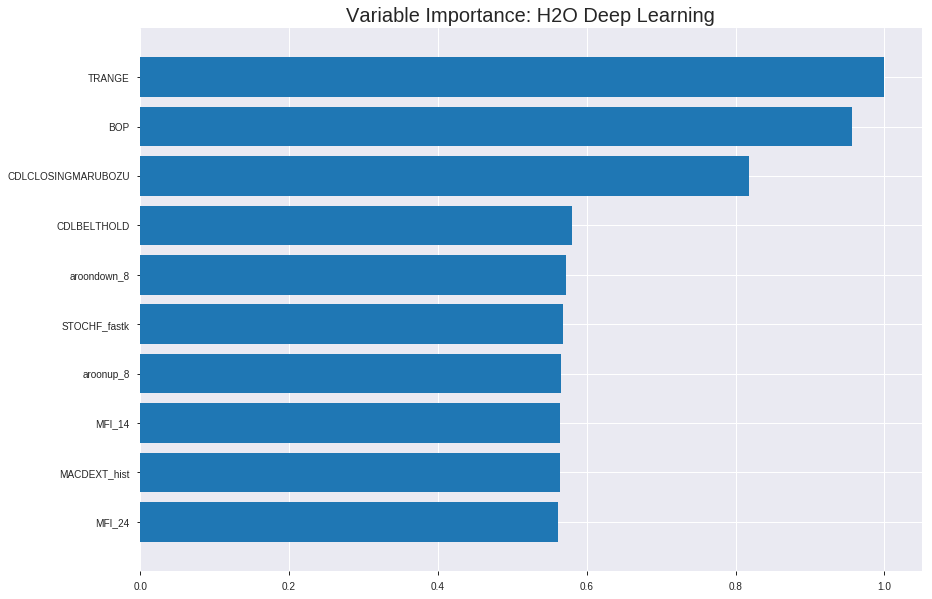

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_213057_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18369153699532978
RMSE: 0.4285925069285857
LogLoss: 0.543090624026569
Mean Per-Class Error: 0.28133396554449186
AUC: 0.7954206283846174
pr_auc: 0.7530327887076703
Gini: 0.5908412567692347
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41861234847237905: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      522  333  0.3895   (333.0/855.0)
1      131  572  0.1863   (131.0/703.0)
Total  653  905  0.2978   (464.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418612     0.711443  229
max f2                       0.19542      0.834144  324
max f0point5                 0.551183     0.709291  162
max accuracy                 0.541623     0.727856  167
max precision                0.983852     1         0
max recall                   0.0290977    1         389
max specificity              0.983852     1         0
max absolute_mcc             0.541623     0.447352  167
max min_per_class_accuracy   0.484976     0.702924  195
max mean_per_class_accuracy  0.541623     0.718666  167

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.95711            2.0777    2.0777             0.9375           0.968176   0.9375                      0.968176            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.927934           1.93919   2.00845            0.875            0.940752   0.90625                     0.954464            0.0199147       0.0412518                  93.9189   100.845
    3        0.0301669                   0.890261           2.06847   2.0276             0.933333         0.907913   0.914894                    0.939607            0.0199147       0.0611664                  106.847   102.76
    4        0.0404365                   0.873573           2.0777    2.04033            0.9375           0.882723   0.920635                    0.92516             0.0213371       0.0825036                  107.77    104.033
    5        0.0500642                   0.849741           1.92072   2.01733            0.866667         0.861696   0.910256                    0.912956            0.0184922       0.100996                   92.0721   101.733
    6        0.100128                    0.766881           1.84685   1.93209            0.833333         0.805139   0.871795                    0.859047            0.0924609       0.193457                   84.6847   93.2086
    7        0.150193                    0.714589           1.73319   1.86579            0.782051         0.739668   0.84188                     0.819254            0.086771        0.280228                   73.3195   86.5789
    8        0.200257                    0.672057           1.84685   1.86105            0.833333         0.69245    0.839744                    0.787553            0.0924609       0.372688                   84.6847   86.1053
    9        0.300385                    0.593722           1.33541   1.68584            0.602564         0.63157    0.760684                    0.735559            0.133713        0.506401                   33.5412   68.584
    10       0.399872                    0.534921           1.31543   1.59368            0.593548         0.563266   0.719101                    0.692693            0.130868        0.637269                   31.5432   59.3684
    11       0.5                         0.469753           0.866597  1.44808            0.391026         0.501919   0.653402                    0.654489            0.086771        0.72404                    -13.3403  44.808
    12       0.600128                    0.406894           1.00866   1.37477            0.455128         0.438461   0.620321                    0.618446            0.100996        0.825036                   0.866251  37.4765
    13       0.699615                    0.34035            0.800697  1.29313            0.36129          0.37336    0.583486                    0.583594            0.0796586       0.904694                   -19.9303  29.3132
    14       0.799743                    0.227446           0.568261  1.20238            0.25641          0.285188   0.542536                    0.546234            0.056899        0.961593                   -43.1739  20.2377
    15       0.899872                    0.113185           0.255717  1.09704            0.115385         0.171251   0.495007                    0.504509            0.0256046       0.987198                   -74.4283  9.70428
    16       1                           0.00018433         0.127859  1                  0.0576923        0.0528659  0.45122                     0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20622811581401576
RMSE: 0.45412345877967564
LogLoss: 0.6087716919914024
Mean Per-Class Error: 0.29308195072900955
AUC: 0.7575565610859729
pr_auc: 0.7226506482331658
Gini: 0.5151131221719458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.283868760700933: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      96   129  0.5733   (129.0/225.0)
1      22   199  0.0995   (22.0/221.0)
Total  118  328  0.3386   (151.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283869     0.724954  292
max f2                       0.103698     0.84507   352
max f0point5                 0.503276     0.706462  153
max accuracy                 0.416719     0.706278  221
max precision                0.963978     1         0
max recall                   0.00455279   1         398
max specificity              0.963978     1         0
max absolute_mcc             0.412089     0.417877  225
max min_per_class_accuracy   0.452707     0.687783  194
max mean_per_class_accuracy  0.412089     0.706918  225

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 43.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.914181           2.0181    2.0181             1                0.938605   1                           0.938605            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.883691           1.00905   1.56963            0.5              0.894071   0.777778                    0.918812            0.00904977      0.0316742                  0.904977  56.9633
    3        0.0313901                   0.859912           1.21086   1.4415             0.6              0.871558   0.714286                    0.901936            0.0135747       0.0452489                  21.086    44.15
    4        0.0403587                   0.813672           2.0181    1.56963            1                0.838774   0.777778                    0.8879              0.0180995       0.0633484                  101.81    56.9633
    5        0.0515695                   0.796379           1.61448   1.57938            0.8              0.804326   0.782609                    0.869732            0.0180995       0.081448                   61.448    57.9382
    6        0.100897                    0.708109           1.65117   1.61448            0.818182         0.750173   0.8                         0.811281            0.081448        0.162896                   65.1172   61.448
    7        0.150224                    0.661775           1.46771   1.56629            0.727273         0.681905   0.776119                    0.768799            0.0723982       0.235294                   46.7709   56.6286
    8        0.201794                    0.623427           1.49164   1.54721            0.73913          0.642931   0.766667                    0.736633            0.0769231       0.312217                   49.1639   54.721
    9        0.300448                    0.556049           1.55944   1.55123            0.772727         0.590911   0.768657                    0.688784            0.153846        0.466063                   55.9441   55.1226
    10       0.401345                    0.495681           1.25571   1.47693            0.622222         0.520561   0.731844                    0.646493            0.126697        0.59276                    25.5706   47.6933
    11       0.5                         0.44853            0.963184  1.37557            0.477273         0.471717   0.681614                    0.612008            0.0950226       0.687783                   -3.68161  37.5566
    12       0.600897                    0.390275           1.07632   1.32532            0.533333         0.420945   0.656716                    0.579927            0.108597        0.79638                    7.63198   32.5319
    13       0.699552                    0.330895           0.733854  1.24191            0.363636         0.362115   0.615385                    0.54921             0.0723982       0.868778                   -26.6146  24.1907
    14       0.800448                    0.209481           0.627853  1.16451            0.311111         0.263997   0.577031                    0.513258            0.0633484       0.932127                   -37.2147  16.4506
    15       0.899103                    0.0803693          0.458659  1.08706            0.227273         0.148177   0.538653                    0.4732              0.0452489       0.977376                   -54.1341  8.70561
    16       1                           0.00356686         0.224233  1                  0.111111         0.0463141  0.495516                    0.43


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:35:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:35:09  2 min 16.122 sec  929 obs/sec       1.74711   1             2722       0.457128         0.63803             0.156103       0.765361        0.709817           1.93919          0.313864                         0.472095           0.692757              0.108433         0.743198          0.726824             2.0181             0.340807
    2019-08-26 21:35:17  2 min 24.262 sec  1591 obs/sec      10.5616   6             16455      0.428593         0.543091            0.258173       0.795421        0.753033           2.0777           0.297818                         0.454123           0.608772              0.175021         0.757557          0.722651             2.0181             0.338565
    2019-08-26 21:35:25  2 min 31.898 sec  1913 obs/sec      21.1579   12            32964      0.425395         0.535054            0.2692         0.805059        0.764528           2.21622          0.297176                         0.458983           0.621551              0.15727          0.757084          0.711578             1.61448            0.331839
    2019-08-26 21:35:33  2 min 40.389 sec  2083 obs/sec      33.4332   19            52089      0.419623         0.521495            0.288897       0.817923        0.784403           2.21622          0.290757                         0.472582           0.657472              0.106595         0.74903           0.699002             1.21086            0.307175
    2019-08-26 21:35:42  2 min 48.642 sec  2190 obs/sec      45.7234   26            71237      0.412084         0.505066            0.31422        0.832238        0.802991           2.21622          0.277279                         0.472136           0.671577              0.108277         0.7473            0.696159             1.61448            0.302691
    2019-08-26 21:35:50  2 min 56.787 sec  2265 obs/sec      58.0526   33            90446      0.402008         0.483823            0.347346       0.842471        0.812073           2.21622          0.27086                          0.468615           0.669747              0.121529         0.751393          0.700634             1.21086            0.307175
    2019-08-26 21:35:51  2 min 57.565 sec  2264 obs/sec      58.0526   33            90446      0.428593         0.543091            0.258173       0.795421        0.753033           2.0777           0.297818                         0.454123           0.608772              0.175021         0.757557          0.722651             2.0181             0.338565

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
TRANGE                   1.0                    1.0                  0.02537044330401609
BOP                      0.9568455219268799     0.9568455219268799   0.02427559506474759
CDLCLOSINGMARUBOZU       0.8179312944412231     0.8179312944412231   0.02075127953220154
CDLBELTHOLD              0.5801774859428406     0.5801774859428406   0.014719360013379429
aroondown_8              0.5715264081954956     0.5715264081954956   0.014499878335871777
---                      ---                    ---                  ---
WILLR_12                 0.5023980736732483     0.5023980736732483   0.012746061844174044
BBANDS_lowerband_24_0_4  0.5005668997764587     0.5005668997764587   0.01269960415064575
PLUS_DM_30               0.49701446294784546    0.49701446294784546  0.012609477253494318
WILLR_8                  0.4920650124549866     0.4920650124549866   0.012483907500379208
MINUS_DI_30              0.48823419213294983    0.48823419213294983  0.012386717890591101


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.7203389830508473)

('auc', 0.7596278317152104)

('logloss', 0.5915803143887073)

('mean_per_class_error', 0.28737864077669906)

('rmse', 0.44652750672439645)

('mse', 0.1993868142615059)

deeplearning prediction progress: |███████████████████████████████████████| 100%


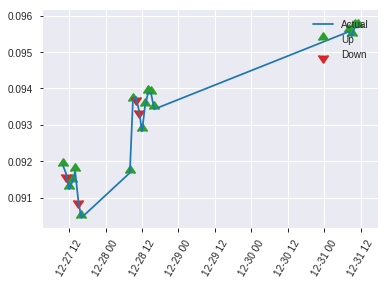


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1993868142615059
RMSE: 0.44652750672439645
LogLoss: 0.5915803143887073
Mean Per-Class Error: 0.28737864077669906
AUC: 0.7596278317152104
pr_auc: 0.7221858195378544
Gini: 0.5192556634304208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41113146946987583: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   48   0.4      (48.0/120.0)
1      18   85   0.1748   (18.0/103.0)
Total  90   133  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411131     0.720339  132
max f2                       0.163033     0.826446  192
max f0point5                 0.452398     0.67718   108
max accuracy                 0.452398     0.704036  108
max precision                0.957925     1         0
max recall                   0.0122477    1         220
max specificity              0.957925     1         0
max absolute_mcc             0.411131     0.432115  132
max min_per_class_accuracy   0.452398     0.7       108
max mean_per_class_accuracy  0.411131     0.712621  132

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 43.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.937863           2.16505   2.16505            1                0.954526   1                           0.954526            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.872878           2.16505   2.16505            1                0.885835   1                           0.92705             0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.857134           2.16505   2.16505            1                0.859457   1                           0.907737            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.817741           2.16505   2.16505            1                0.837991   1                           0.892238            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.793665           2.16505   2.16505            1                0.809097   1                           0.871453            0.0291262       0.116505                   116.505   116.505
    6        0.103139                    0.712896           1.57458   1.88265            0.727273         0.761093   0.869565                    0.818672            0.0776699       0.194175                   57.4581   88.2651
    7        0.152466                    0.642465           1.18094   1.65563            0.545455         0.675561   0.764706                    0.772371            0.0582524       0.252427                   18.0936   65.5625
    8        0.201794                    0.601428           1.57458   1.63581            0.727273         0.617879   0.755556                    0.734607            0.0776699       0.330097                   57.4581   63.5814
    9        0.300448                    0.535367           1.37776   1.55108            0.636364         0.573946   0.716418                    0.681852            0.135922        0.466019                   37.7758   55.108
    10       0.399103                    0.49239            1.18094   1.45958            0.545455         0.509042   0.674157                    0.639135            0.116505        0.582524                   18.0936   45.9583
    11       0.502242                    0.440228           1.31786   1.43048            0.608696         0.47003    0.660714                    0.604408            0.135922        0.718447                   31.7856   43.0479
    12       0.600897                    0.410175           1.08252   1.37335            0.5              0.427231   0.634328                    0.57532             0.106796        0.825243                   8.25243   37.3352
    13       0.699552                    0.3349             0.688879  1.27682            0.318182         0.380217   0.589744                    0.547805            0.0679612       0.893204                   -31.1121  27.6824
    14       0.798206                    0.252014           0.393645  1.16767            0.181818         0.29815    0.539326                    0.516949            0.038835        0.932039                   -60.6355  16.7667
    15       0.896861                    0.096885           0.393645  1.08252            0.181818         0.1839     0.5                         0.480313            0.038835        0.970874                   -60.6355  8.25243
    16       1                           0.00254549         0.282398  1                  0.130435         0.0535503  0.461883                    

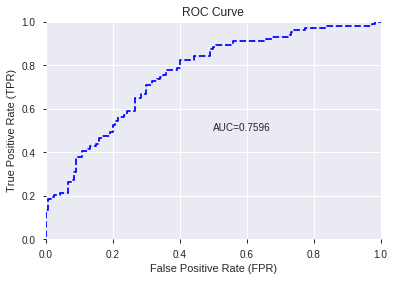

This function is available for GLM models only


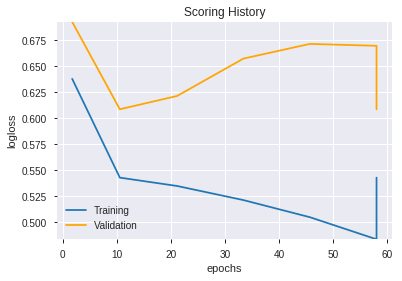

--2019-08-26 21:40:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_213057_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_213057_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'aroondown_8',
 'STOCHF_fastk',
 'aroonup_8',
 'MFI_14',
 'MACDEXT_hist',
 'MFI_24',
 'CCI_8',
 'PLUS_DI_8',
 'MAVP_20_3',
 'ROCR100_12',
 'ROCP_8',
 'STOCHRSI_fastk',
 'CCI_24',
 'AVGPRICE',
 'MINUS_DM_24',
 'STOCH_slowd',
 'ADX_8',
 'ULTOSC',
 'NATR_8',
 'WILLR_24',
 'PLUS_DM_20',
 'ROCR100_24',
 'ROCP_20',
 'AROONOSC_24',
 'PLUS_DM_8',
 'aroonup_20',
 'MINUS_DM_20',
 'aroonup_24',
 'CDLSPINNINGTOP',
 'WILLR_14',
 'ADOSC',
 'ROCR100_14',
 'BBANDS_lowerband_20_5_5',
 'PLUS_DI_20',
 'STOCHF_fastd',
 'ATR_14',
 'CCI_12',
 'BETA_8',
 'ADXR_14',
 'DX_30',
 'aroondown_14',
 'PLUS_DI_24',
 'MINUS_DM_12',
 'ROCR100_8',
 'ATR_8',
 'CMO_30',
 'ROCP_30',
 'DX_20',
 'aroonup_14',
 'TRIX_12',
 'aroonup_12',
 'PPO',
 'WILLR_20',
 'AROONOSC_8',
 'NATR_12',
 'ATR_20',
 'BBANDS_lowerband_20_7_5',
 'aroondown_12',
 'MACDFIX_hist_24',
 'MINUS_DI_14',
 'MOM_24',
 'BBANDS_lowerband_20_1_5',
 'RSI_14',
 'WILLR_12',
 'BBANDS_lowerband_24_0_4',
 'PL

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_214018_model_1  0.771278  0.574488               0.27411  0.443003  0.196251

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.535383           1.000000    0.099057
1               TRANGE             0.506291           0.945662    0.093674
2   CDLCLOSINGMARUBOZU             0.295755           0.552417    0.054721
3               ULTOSC             0.246907           0.461179    0.045683
4         STOCHF_fastk             0.216246           0.403910    0.040010
..                 ...                  ...                ...         ...
67          aroonup_12             0.005874           0.010972    0.001087
68          ROCR100_14             0.005813           0.010857    0.001075
69             NATR_12             0.004910           0.009172    0.000909
70              NATR_8             0.004616           0.008621    0.000854
71               ADX_8             0.001000           0.001868    0.000185

[72 rows x 4 columns]

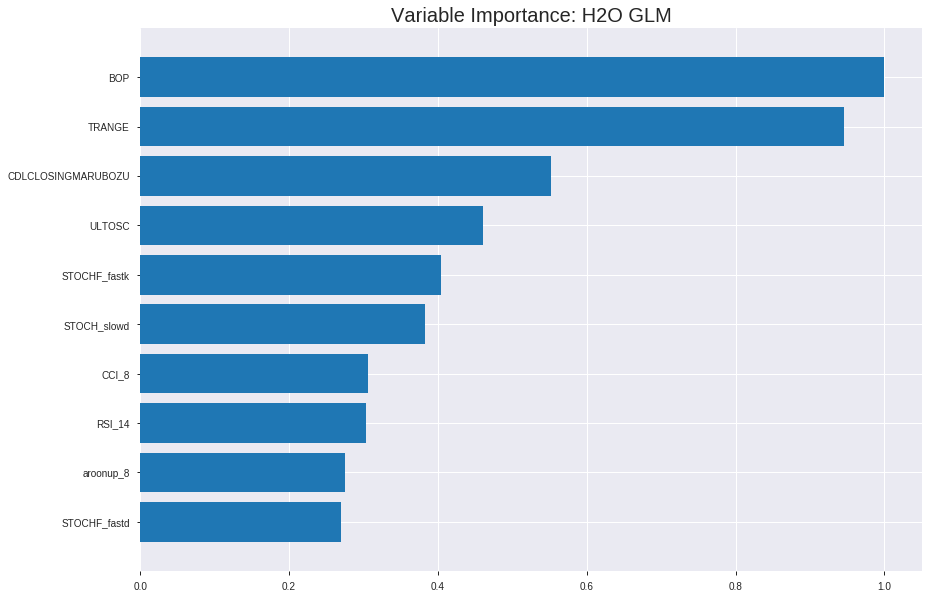

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_214018_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18836772925919834
RMSE: 0.4340135127610641
LogLoss: 0.5554442292744632
Null degrees of freedom: 1557
Residual degrees of freedom: 1485
Null deviance: 2144.993731790383
Residual deviance: 1730.7642184192275
AIC: 1876.7642184192275
AUC: 0.7849691797060218
pr_auc: 0.7357332502483751
Gini: 0.5699383594120435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39566795739943317: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      512  343  0.4012   (343.0/855.0)
1      129  574  0.1835   (129.0/703.0)
Total  641  917  0.303    (472.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395668     0.708642  232
max f2                       0.220953     0.829471  317
max f0point5                 0.505341     0.695163  175
max accuracy                 0.505341     0.720796  175
max precision                0.925697     1         0
max recall                   0.058487     1         384
max specificity              0.925697     1         0
max absolute_mcc             0.505341     0.433334  175
max min_per_class_accuracy   0.458007     0.700585  198
max mean_per_class_accuracy  0.505341     0.714509  175

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.898373           2.0777    2.0777             0.9375           0.913215  0.9375                      0.913215            0.0213371       0.0213371                  107.77    107.77
    2        0.0205392                   0.877855           2.0777    2.0777             0.9375           0.889066  0.9375                      0.901141            0.0213371       0.0426743                  107.77    107.77
    3        0.0301669                   0.864              1.92072   2.0276             0.866667         0.871522  0.914894                    0.891688            0.0184922       0.0611664                  92.0721   102.76
    4        0.0404365                   0.83293            2.0777    2.04033            0.9375           0.84737   0.920635                    0.880433            0.0213371       0.0825036                  107.77    104.033
    5        0.0500642                   0.810018           1.47748   1.93209            0.666667         0.820674  0.871795                    0.868941            0.0142248       0.0967283                  47.7477   93.2086
    6        0.100128                    0.74122            1.90367   1.91788            0.858974         0.776684  0.865385                    0.822812            0.0953058       0.192034                   90.3673   91.7879
    7        0.150193                    0.699344           1.61954   1.81843            0.730769         0.717193  0.820513                    0.787606            0.0810811       0.273115                   61.9543   81.8434
    8        0.200257                    0.66091            1.59113   1.76161            0.717949         0.680164  0.794872                    0.760745            0.0796586       0.352774                   59.113    76.1608
    9        0.300385                    0.588385           1.43486   1.65269            0.647436         0.621654  0.745726                    0.714382            0.14367         0.496444                   43.4858   65.2691
    10       0.399872                    0.511881           1.32973   1.57234            0.6              0.550746  0.70947                     0.67367             0.13229         0.628734                   32.973    57.234
    11       0.5                         0.445132           0.951836  1.44808            0.429487         0.479382  0.653402                    0.634762            0.0953058       0.72404                    -4.81635  44.808
    12       0.600128                    0.386807           0.966043  1.36765            0.435897         0.416316  0.617112                    0.598316            0.0967283       0.820768                   -3.3957   36.7654
    13       0.699615                    0.322547           0.743505  1.2789             0.335484         0.353316  0.577064                    0.563476            0.0739687       0.894737                   -25.6495  27.8899
    14       0.799743                    0.241574           0.625087  1.19704            0.282051         0.281464  0.540128                    0.528168            0.0625889       0.957326                   -37.4913  19.7041
    15       0.899872                    0.146774           0.269924  1.09388            0.121795         0.199659  0.493581                    0.491615            0.027027        0.984353                   -73.0076  9.38813
    16       1                           0.000102152        0.156272  1                  0.0705128        0.088179  0.45122                     0.45122             0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20017546873595002
RMSE: 0.44740973250025534
LogLoss: 0.5905152977174498
Null degrees of freedom: 445
Residual degrees of freedom: 373
Null deviance: 621.7697307743217
Residual deviance: 526.7396455639653
AIC: 672.7396455639653
AUC: 0.7695625942684766
pr_auc: 0.7578421123791687
Gini: 0.5391251885369532
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2748403129245812: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  119  0.5289   (119.0/225.0)
1      21   200  0.095    (21.0/221.0)
Total  127  319  0.3139   (140.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.27484      0.740741  284
max f2                       0.152268     0.84793   334
max f0point5                 0.450528     0.706268  191
max accuracy                 0.386806     0.715247  233
max precision                0.924915     1         0
max recall                   0.0198789    1         396
max specificity              0.924915     1         0
max absolute_mcc             0.383904     0.440507  235
max min_per_class_accuracy   0.439403     0.702222  199
max mean_per_class_accuracy  0.383904     0.716129  235

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 42.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.873881           2.0181    2.0181             1                0.893966   1                           0.893966            0.0226244       0.0226244                  101.81    101.81
    2        0.0201794                   0.822472           2.0181    2.0181             1                0.851335   1                           0.875019            0.0180995       0.040724                   101.81    101.81
    3        0.0313901                   0.795153           2.0181    2.0181             1                0.80695    1                           0.850708            0.0226244       0.0633484                  101.81    101.81
    4        0.0403587                   0.781298           2.0181    2.0181             1                0.790031   1                           0.837224            0.0180995       0.081448                   101.81    101.81
    5        0.0515695                   0.767054           2.0181    2.0181             1                0.774446   1                           0.823577            0.0226244       0.104072                   101.81    101.81
    6        0.100897                    0.707233           1.46771   1.74902            0.727273         0.735362   0.866667                    0.78045             0.0723982       0.176471                   46.7709   74.902
    7        0.150224                    0.671959           1.55944   1.68677            0.772727         0.689582   0.835821                    0.750613            0.0769231       0.253394                   55.9441   68.677
    8        0.201794                    0.641028           1.31615   1.59206            0.652174         0.65754    0.788889                    0.726827            0.0678733       0.321267                   31.6152   59.2056
    9        0.300448                    0.544743           1.28425   1.49098            0.636364         0.595878   0.738806                    0.683829            0.126697        0.447964                   28.4245   49.0984
    10       0.401345                    0.489029           1.43509   1.47693            0.711111         0.516671   0.731844                    0.641806            0.144796        0.59276                    43.5093   47.6933
    11       0.5                         0.439279           1.14665   1.41176            0.568182         0.463728   0.699552                    0.60667             0.113122        0.705882                   14.6647   41.1765
    12       0.600897                    0.381165           1.07632   1.35544            0.533333         0.410444   0.671642                    0.573721            0.108597        0.81448                    7.63198   35.544
    13       0.699552                    0.288043           0.733854  1.26778            0.363636         0.331943   0.628205                    0.539624            0.0723982       0.886878                   -26.6146  26.778
    14       0.800448                    0.191805           0.53816   1.17581            0.266667         0.238453   0.582633                    0.501661            0.0542986       0.941176                   -46.184   17.5812
    15       0.899103                    0.0950999          0.229329  1.07196            0.113636         0.141172   0.531172                    0.462107            0.0226244       0.963801                   -77.0671  7.19581
    16       1                           0.0120028          0.358773  1                  0.177778         0.0573526  0.495516                    0.421268


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:40:18  0.000 sec   2            19        73            1.35735           1.37717
    2019-08-26 21:40:18  0.015 sec   4            12        73            1.34832           1.3693
    2019-08-26 21:40:18  0.031 sec   6            7.3       73            1.33619           1.35871
    2019-08-26 21:40:18  0.046 sec   8            4.5       73            1.3205            1.34511
    2019-08-26 21:40:18  0.061 sec   10           2.8       73            1.30108           1.32851
    2019-08-26 21:40:18  0.083 sec   12           1.7       73            1.27835           1.30947
    2019-08-26 21:40:18  0.103 sec   14           1.1       73            1.2534            1.28896
    2019-08-26 21:40:18  0.119 sec   16           0.67      73            1.22774           1.26809
    2019-08-26 21:40:18  0.134 sec   18           0.42      73            1.2029            1.2478
    2019-08-26 21:40:18  0.150 sec   20           0.26      73            1.18011           1.22901
    2019-08-26 21:40:18  0.167 sec   22           0.16      73            1.16015           1.21254
    2019-08-26 21:40:18  0.183 sec   24           0.1       73            1.14336           1.19916
    2019-08-26 21:40:18  0.199 sec   26           0.062     73            1.12978           1.18937
    2019-08-26 21:40:18  0.220 sec   28           0.039     73            1.11911           1.18339
    2019-08-26 21:40:19  0.236 sec   30           0.024     73            1.11089           1.18103
    2019-08-26 21:40:19  0.251 sec   32           0.015     73            1.1046            1.18188
    2019-08-26 21:40:19  0.267 sec   34           0.0093    73            1.09976           1.18551
    2019-08-26 21:40:19  0.283 sec   36           0.0058    73            1.09603           1.19142
    2019-08-26 21:40:19  0.299 sec   38           0.0036    73            1.09313           1.19863
    2019-08-26 21:40:19  0.314 sec   40           0.0022    73            1.09087           1.20599

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.7081339712918661)

('auc', 0.7712783171521036)

('logloss', 0.5744875112640424)

('mean_per_class_error', 0.27411003236245957)

('rmse', 0.44300271186377627)

('mse', 0.19625140271865996)

glm prediction progress: |████████████████████████████████████████████████| 100%


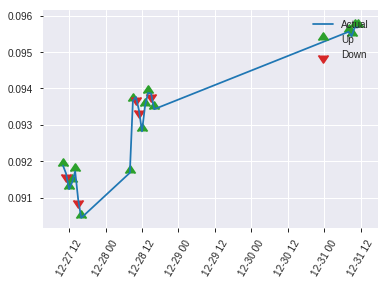


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19625140271865996
RMSE: 0.44300271186377627
LogLoss: 0.5744875112640424
Null degrees of freedom: 222
Residual degrees of freedom: 150
Null deviance: 307.9486967302692
Residual deviance: 256.221430023763
AIC: 402.221430023763
AUC: 0.7712783171521036
pr_auc: 0.7421679976325826
Gini: 0.5425566343042072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41312289814881026: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   32   0.2667   (32.0/120.0)
1      29   74   0.2816   (29.0/103.0)
Total  117  106  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413123     0.708134  105
max f2                       0.123719     0.826514  198
max f0point5                 0.552424     0.706667  67
max accuracy                 0.413123     0.726457  105
max precision                0.902178     1         0
max recall                   0.0837268    1         213
max specificity              0.902178     1         0
max absolute_mcc             0.413123     0.451014  105
max min_per_class_accuracy   0.413123     0.718447  105
max mean_per_class_accuracy  0.413123     0.72589   105

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.867889           2.16505   2.16505            1                0.890254  1                           0.890254            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.858917           2.16505   2.16505            1                0.864376  1                           0.879903            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.847639           2.16505   2.16505            1                0.851027  1                           0.871652            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.827596           2.16505   2.16505            1                0.84156   1                           0.864965            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.815314           2.16505   2.16505            1                0.820348  1                           0.853811            0.0291262       0.116505                   116.505   116.505
    6        0.103139                    0.682883           1.57458   1.88265            0.727273         0.732106  0.869565                    0.795604            0.0776699       0.194175                   57.4581   88.2651
    7        0.152466                    0.651315           1.57458   1.78298            0.727273         0.668935  0.823529                    0.754623            0.0776699       0.271845                   57.4581   78.2981
    8        0.201794                    0.618754           1.57458   1.73204            0.727273         0.634175  0.8                         0.72518             0.0776699       0.349515                   57.4581   73.2039
    9        0.300448                    0.5528             1.57458   1.68034            0.727273         0.581912  0.776119                    0.678137            0.15534         0.504854                   57.4581   68.0336
    10       0.399103                    0.446784           0.885702  1.48391            0.409091         0.500931  0.685393                    0.634333            0.0873786       0.592233                   -11.4298  48.391
    11       0.502242                    0.407979           1.22372   1.43048            0.565217         0.421962  0.660714                    0.590721            0.126214        0.718447                   22.3723   43.0479
    12       0.600897                    0.356425           0.78729   1.32488            0.363636         0.383487  0.61194                     0.556698            0.0776699       0.796117                   -21.271   32.488
    13       0.699552                    0.284268           0.78729   1.24907            0.363636         0.319851  0.576923                    0.523296            0.0776699       0.873786                   -21.271   24.9066
    14       0.798206                    0.237823           0.590468  1.16767            0.272727         0.262425  0.539326                    0.491054            0.0582524       0.932039                   -40.9532  16.7667
    15       0.896861                    0.111785           0.492056  1.09335            0.227273         0.186766  0.505                       0.457582            0.0485437       0.980583                   -50.7944  9.33495
    16       1                           0.00289546         0.188265  1                  0.0869565        0.082719  0.461883                    0.418919           

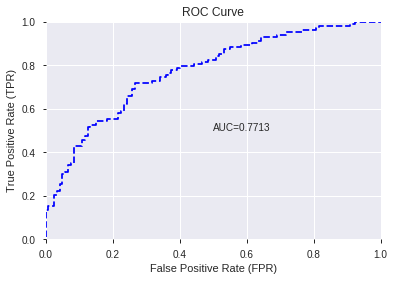

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


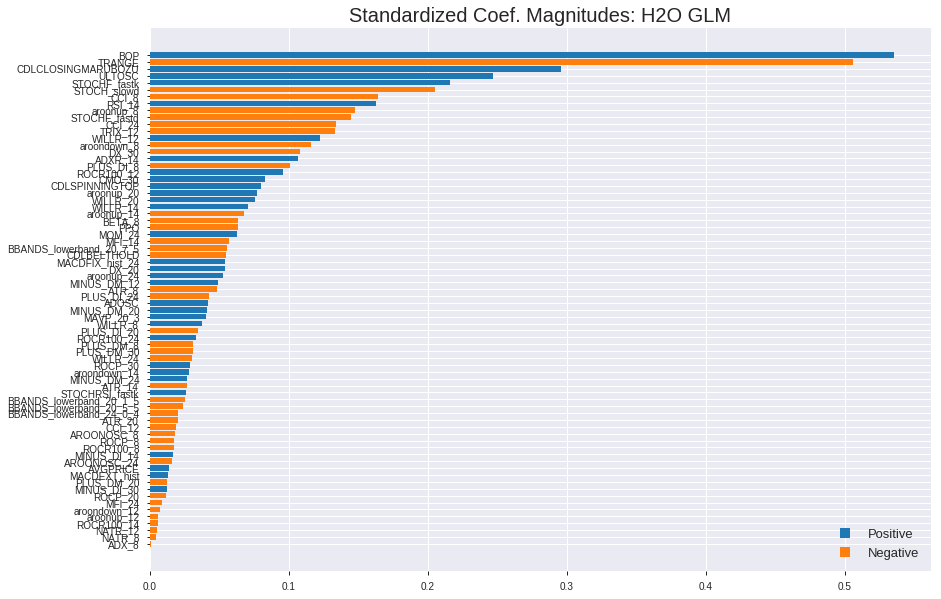

'log_likelihood'
--2019-08-26 21:40:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.32.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.32.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_214018_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_214018_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCH_slowd',
 'CCI_8',
 'RSI_14',
 'aroonup_8',
 'STOCHF_fastd',
 'CCI_24',
 'TRIX_12',
 'WILLR_12',
 'aroondown_8',
 'DX_30',
 'ADXR_14',
 'PLUS_DI_8',
 'ROCR100_12',
 'CMO_30',
 'CDLSPINNINGTOP',
 'aroonup_20',
 'WILLR_20',
 'WILLR_14',
 'aroonup_14',
 'BETA_8',
 'PPO',
 'MOM_24',
 'MFI_14',
 'BBANDS_lowerband_20_7_5',
 'CDLBELTHOLD',
 'MACDFIX_hist_24',
 'DX_20',
 'aroonup_24',
 'MINUS_DM_12',
 'ATR_8',
 'PLUS_DI_24',
 'ADOSC',
 'MINUS_DM_20',
 'MAVP_20_3',
 'WILLR_8',
 'PLUS_DI_20',
 'ROCR100_24',
 'PLUS_DM_8',
 'PLUS_DM_30',
 'WILLR_24',
 'ROCP_30',
 'aroondown_14',
 'MINUS_DM_24',
 'ATR_14',
 'STOCHRSI_fastk',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_24_0_4',
 'ATR_20',
 'CCI_12',
 'AROONOSC_8',
 'ROCP_8',
 'ROCR100_8',
 'MINUS_DI_14',
 'AROONOSC_24',
 'AVGPRICE',
 'MACDEXT_hist',
 'PLUS_DM_20',
 'MINUS_DI_30',
 'ROCP_20',
 'MFI_24',
 'aroondown_12',
 'aroonup_12',
 'ROCR100

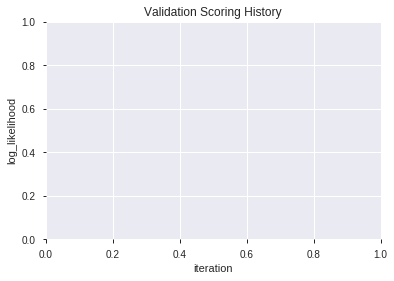

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_214028  0.760356  0.590076              0.285963  0.448032  0.200733
1               XGBoost_2_AutoML_20190826_214028  0.758576  0.588964              0.306877  0.447837  0.200558
2  XGBoost_grid_1_AutoML_20190826_214028_model_2  0.757039  0.592708              0.283172  0.449509  0.202058
3  XGBoost_grid_1_AutoML_20190826_214028_model_4  0.756715  0.589776              0.279693  0.448475  0.201130
4  XGBoost_grid_1_AutoML_20190826_214028_model_6  0.755421  0.591316              0.277629  0.449662  0.202196
5  XGBoost_grid_1_AutoML_20190826_214028_model_1  0.755340  0.594997              0.306877  0.451055  0.203451
6  XGBoost_grid_1_AutoML_20190826_214028_model_5  0.754935  0.610196              0.263066  0.454797  0.206841
7  XGBoost_grid_1_AutoML_20190826_214028_model_3  0.754126  0.593706              0.289442  0.450083  0.202575
8  XGBoost_grid_1_AutoML_20190826_214028_model_7  0.750971  0.596661              0.284587  0.452196  0.204482
9               XGBoost_1_AutoML_20190826_214028  0.739078  0.607543              0.312379  0.456077  0.208007

variable  relative_importance  scaled_importance  percentage
0                  BOP          1854.008789           1.000000    0.214978
1               TRANGE          1126.339966           0.607516    0.130603
2         STOCHF_fastk           550.474792           0.296911    0.063829
3       STOCHRSI_fastk           259.093109           0.139748    0.030043
4   CDLCLOSINGMARUBOZU           235.365768           0.126950    0.027291
..                 ...                  ...                ...         ...
67            WILLR_24            18.487080           0.009971    0.002144
68          aroonup_14            16.964596           0.009150    0.001967
69      CDLSPINNINGTOP            15.853358           0.008551    0.001838
70              CMO_30            11.640103           0.006278    0.001350
71          aroonup_20             7.654689           0.004129    0.000888

[72 rows x 4 columns]

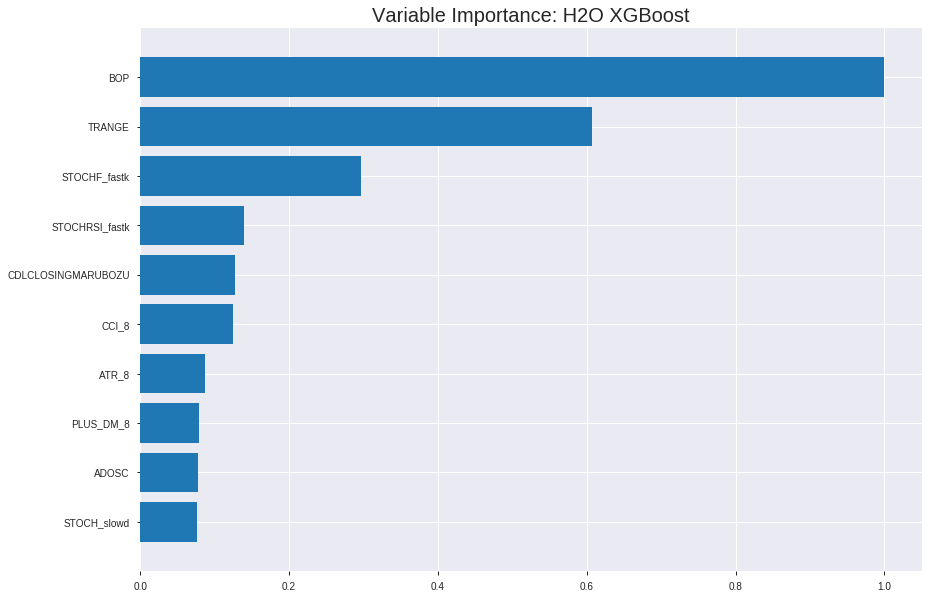

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_214028


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11979553449417693
RMSE: 0.3461149151570572
LogLoss: 0.39985338001422455
Mean Per-Class Error: 0.12939781887150303
AUC: 0.9433422342009599
pr_auc: 0.9353917752742582
Gini: 0.8866844684019197
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49423593282699585: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      759  96   0.1123   (96.0/855.0)
1      103  600  0.1465   (103.0/703.0)
Total  862  696  0.1277   (199.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494236     0.857756  183
max f2                       0.343396     0.897129  249
max f0point5                 0.560153     0.87943   154
max accuracy                 0.494236     0.872272  183
max precision                0.918658     1         0
max recall                   0.158877     1         344
max specificity              0.918658     1         0
max absolute_mcc             0.494236     0.741892  183
max min_per_class_accuracy   0.480329     0.863158  190
max mean_per_class_accuracy  0.494236     0.870602  183

Gains/Lift Table: Avg response rate: 45.12 %, avg score: 45.25 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.883677           2.21622    2.21622            1                0.897491   1                           0.897491            0.0227596       0.0227596                  121.622   121.622
    2        0.0205392                   0.864972           2.21622    2.21622            1                0.872949   1                           0.88522             0.0227596       0.0455192                  121.622   121.622
    3        0.0301669                   0.85238            2.21622    2.21622            1                0.856453   1                           0.876039            0.0213371       0.0668563                  121.622   121.622
    4        0.0404365                   0.844661           2.21622    2.21622            1                0.848565   1                           0.869061            0.0227596       0.0896159                  121.622   121.622
    5        0.0500642                   0.83509            2.21622    2.21622            1                0.839679   1                           0.863411            0.0213371       0.110953                   121.622   121.622
    6        0.100128                    0.793173           2.21622    2.21622            1                0.813496   1                           0.838453            0.110953        0.221906                   121.622   121.622
    7        0.150193                    0.750777           2.13098    2.1878             0.961538         0.772546   0.987179                    0.816484            0.106686        0.328592                   113.098   118.78
    8        0.200257                    0.712829           2.15939    2.1807             0.974359         0.732277   0.983974                    0.795433            0.108108        0.4367                     115.939   118.07
    9        0.300385                    0.624514           1.97471    2.11204            0.891026         0.670763   0.952991                    0.753876            0.197724        0.634424                   97.4705   111.204
    10       0.399872                    0.53777            1.60139    1.98499            0.722581         0.580769   0.895666                    0.710808            0.159317        0.793741                   60.1395   98.499
    11       0.5                         0.445798           1.03708    1.79516            0.467949         0.491816   0.810013                    0.666953            0.103841        0.897582                   3.70755   79.5164
    12       0.600128                    0.350111           0.539848   1.58572            0.24359          0.397405   0.715508                    0.62198             0.0540541       0.951636                   -46.0152  58.572
    13       0.699615                    0.269438           0.31456    1.40496            0.141935         0.311205   0.633945                    0.577788            0.0312945       0.98293                    -68.544   40.4959
    14       0.799743                    0.188478           0.127859   1.24507            0.0576923        0.227178   0.561798                    0.533891            0.0128023       0.995733                   -87.2141  24.5065
    15       0.899872                    0.128519           0.0426195  1.11127            0.0192308        0.155943   0.501427                    0.491837            0.00426743      1                          -95.738   11.127
    16       1                           0.0558578          0          1                  0                0.0985433  0.45122       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19122270917649356
RMSE: 0.4372901887494088
LogLoss: 0.5655554091543323
Mean Per-Class Error: 0.2578079436902967
AUC: 0.7985922574157869
pr_auc: 0.7556145554464401
Gini: 0.5971845148315738
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3309168815612793: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  83   0.3689   (83.0/225.0)
1      38   183  0.1719   (38.0/221.0)
Total  180  266  0.2713   (121.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330917     0.75154   240
max f2                       0.170322     0.852682  333
max f0point5                 0.45823      0.747296  180
max accuracy                 0.415759     0.742152  201
max precision                0.869978     1         0
max recall                   0.0831316    1         390
max specificity              0.869978     1         0
max absolute_mcc             0.415759     0.48437   201
max min_per_class_accuracy   0.41668      0.737778  200
max mean_per_class_accuracy  0.415759     0.742192  201

Gains/Lift Table: Avg response rate: 49.55 %, avg score: 41.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.844161           1.61448   1.61448            0.8              0.852582  0.8                         0.852582            0.0180995       0.0180995                  61.448    61.448
    2        0.0201794                   0.828725           1.51357   1.56963            0.75             0.834717  0.777778                    0.844642            0.0135747       0.0316742                  51.3575   56.9633
    3        0.0313901                   0.801372           2.0181    1.7298             1                0.817029  0.857143                    0.83478             0.0226244       0.0542986                  101.81    72.98
    4        0.0403587                   0.791085           1.00905   1.56963            0.5              0.796885  0.777778                    0.826359            0.00904977      0.0633484                  0.904977  56.9633
    5        0.0515695                   0.77917            1.61448   1.57938            0.8              0.783995  0.782609                    0.81715             0.0180995       0.081448                   61.448    57.9382
    6        0.100897                    0.71907            1.55944   1.56963            0.772727         0.754018  0.777778                    0.786285            0.0769231       0.158371                   55.9441   56.9633
    7        0.150224                    0.687135           1.92637   1.68677            0.954545         0.703624  0.835821                    0.759143            0.0950226       0.253394                   92.6368   68.677
    8        0.201794                    0.645451           1.57938   1.65933            0.782609         0.668063  0.822222                    0.735867            0.081448        0.334842                   57.9382   65.9326
    9        0.300448                    0.566063           1.46771   1.59641            0.727273         0.610216  0.791045                    0.694608            0.144796        0.479638                   46.7709   59.6407
    10       0.401345                    0.495299           1.39025   1.54458            0.688889         0.532843  0.765363                    0.653941            0.140271        0.61991                    39.0246   54.4579
    11       0.5                         0.41622            1.23838   1.48416            0.613636         0.452028  0.735426                    0.614102            0.122172        0.742081                   23.8379   48.4163
    12       0.600897                    0.327306           0.852086  1.37803            0.422222         0.375315  0.682836                    0.574007            0.0859729       0.828054                   -14.7914  37.8031
    13       0.699552                    0.248679           0.642123  1.27425            0.318182         0.287453  0.63141                     0.533596            0.0633484       0.891403                   -35.7877  27.4249
    14       0.800448                    0.178863           0.493313  1.17581            0.244444         0.207019  0.582633                    0.49243             0.0497738       0.941176                   -50.6687  17.5812
    15       0.899103                    0.131663           0.412793  1.09209            0.204545         0.152265  0.541147                    0.455105            0.040724        0.9819                     -58.7207  9.20888
    16       1                           0.0577789          0.179387  1                  0.0888889        0.101136  0.495516                    0.419391            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:40:31  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.54878                          0.5                0.693147              0.5               0                    1                  0.504484
    2019-08-26 21:40:32  0.087 sec   5                  0.469435         0.633482            0.861506        0.834064           2.21622          0.226573                         0.479812           0.653332              0.771423          0.737771             2.0181             0.2713
    2019-08-26 21:40:32  0.142 sec   10                 0.446285         0.589451            0.878492        0.855096           2.21622          0.20475                          0.465906           0.626051              0.786526          0.752101             2.0181             0.253363
    2019-08-26 21:40:32  0.193 sec   15                 0.429279         0.557193            0.884201        0.862904           2.21622          0.188062                         0.455688           0.605662              0.789422          0.759775             2.0181             0.253363
    2019-08-26 21:40:32  0.250 sec   20                 0.413713         0.527456            0.891858        0.872647           2.21622          0.182927                         0.448671           0.591362              0.790307          0.760918             2.0181             0.246637
    2019-08-26 21:40:32  0.309 sec   25                 0.404104         0.508864            0.897278        0.881088           2.21622          0.182285                         0.445565           0.584572              0.794329          0.760336             2.0181             0.248879
    2019-08-26 21:40:32  0.364 sec   30                 0.394808         0.490793            0.903331        0.887769           2.21622          0.177792                         0.442922           0.578752              0.794671          0.757835             1.61448            0.248879
    2019-08-26 21:40:32  0.422 sec   35                 0.384939         0.471942            0.911797        0.896674           2.21622          0.171374                         0.440097           0.572627              0.795706          0.75454              1.61448            0.264574
    2019-08-26 21:40:32  0.479 sec   40                 0.376107         0.454981            0.918181        0.906014           2.21622          0.162388                         0.438047           0.568299              0.797436          0.754252             1.61448            0.248879
    2019-08-26 21:40:32  0.543 sec   45                 0.368292         0.44047             0.925202        0.913983           2.21622          0.153402                         0.438202           0.567968              0.796078          0.755113             1.61448            0.266816
    2019-08-26 21:40:32  0.599 sec   50                 0.361541         0.42787             0.930826        0.920735           2.21622          0.150193                         0.438024           0.567059              0.795988          0.75493              1.61448            0.302691
    2019-08-26 21:40:32  0.653 sec   55                 0.355667         0.416904            0.935075        0.926025           2.21622          0.140565                         0.438171           0.567171              0.797396          0.7

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 1854.0087890625        1.0                   0.21497822721143503
TRANGE              1126.3399658203125     0.6075159796787473    0.13060270831395526
STOCHF_fastk        550.4747924804688      0.296910562521563     0.06382930637123556
STOCHRSI_fastk      259.0931091308594      0.13974750856595058   0.030042671648722888
CDLCLOSINGMARUBOZU  235.3657684326172      0.12694965084369017   0.02729141088348717
---                 ---                    ---                   ---
WILLR_24            18.487079620361328     0.00997140883550478   0.0021436357942572573
aroonup_14          16.964595794677734     0.009150224041416799  0.001967098943011236
CDLSPINNINGTOP      15.853358268737793     0.008550853891450114  0.0018382474107279463
CMO_30              11.640103340148926     0.006278343128046805  0.001349707075492598
aroonup_20          7.654688835144043      0.004128723056925054  0.0008875855634247249


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7136563876651982)

('auc', 0.7603559870550162)

('logloss', 0.5900757484568036)

('mean_per_class_error', 0.285962783171521)

('rmse', 0.4480324630789708)

('mse', 0.20073308797260936)

xgboost prediction progress: |████████████████████████████████████████████| 100%


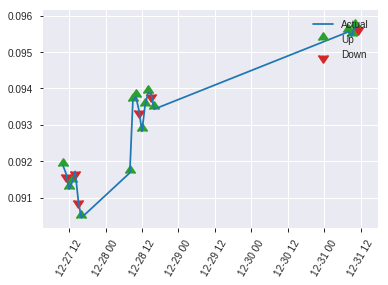


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20073308797260936
RMSE: 0.4480324630789708
LogLoss: 0.5900757484568036
Mean Per-Class Error: 0.285962783171521
AUC: 0.7603559870550162
pr_auc: 0.7161964895173367
Gini: 0.5207119741100323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3737422823905945: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   43   0.3583   (43.0/120.0)
1      22   81   0.2136   (22.0/103.0)
Total  99   124  0.2915   (65.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373742     0.713656  123
max f2                       0.119156     0.818476  204
max f0point5                 0.48648      0.699374  93
max accuracy                 0.48648      0.717489  93
max precision                0.857281     1         0
max recall                   0.0620743    1         221
max specificity              0.857281     1         0
max absolute_mcc             0.48648      0.429571  93
max min_per_class_accuracy   0.443004     0.68932   104
max mean_per_class_accuracy  0.373742     0.714037  123

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.836819           2.16505   2.16505            1                0.847667   1                           0.847667            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.819212           2.16505   2.16505            1                0.825103   1                           0.838642            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.798204           2.16505   2.16505            1                0.81304    1                           0.831327            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.781651           1.08252   1.92449            0.5              0.787504   0.888889                    0.821588            0.00970874      0.0776699                  8.25243   92.4488
    5        0.0538117                   0.769575           2.16505   1.98463            1                0.777311   0.916667                    0.810519            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.733537           1.37776   1.69439            0.636364         0.74554    0.782609                    0.779442            0.0679612       0.174757                   37.7758   69.4386
    7        0.152466                    0.663762           1.57458   1.65563            0.727273         0.700027   0.764706                    0.753749            0.0776699       0.252427                   57.4581   65.5625
    8        0.201794                    0.618856           1.7714    1.68393            0.818182         0.63677    0.777778                    0.725154            0.0873786       0.339806                   77.1403   68.3927
    9        0.300448                    0.547055           1.47617   1.61571            0.681818         0.577351   0.746269                    0.676621            0.145631        0.485437                   47.6169   61.5708
    10       0.399103                    0.492076           1.27935   1.53256            0.590909         0.515451   0.707865                    0.636782            0.126214        0.61165                    27.9347   53.2562
    11       0.502242                    0.421952           0.847193  1.39182            0.391304         0.459622   0.642857                    0.600401            0.0873786       0.699029                   -15.2807  39.1817
    12       0.600897                    0.324559           1.08252   1.34104            0.5              0.373179   0.619403                    0.563096            0.106796        0.805825                   8.25243   34.1038
    13       0.699552                    0.235454           0.590468  1.23519            0.272727         0.281144   0.570513                    0.523333            0.0582524       0.864078                   -40.9532  23.5188
    14       0.798206                    0.189523           0.590468  1.1555             0.272727         0.210898   0.533708                    0.484718            0.0582524       0.92233                    -40.9532  15.5503
    15       0.896861                    0.127732           0.295234  1.06087            0.136364         0.156108   0.49                        0.44857             0.0291262       0.951456                   -70.4766  6.08738
    16       1                           0.0592685          0.470663  1                  0.217391         0.0948281  0.461883                   

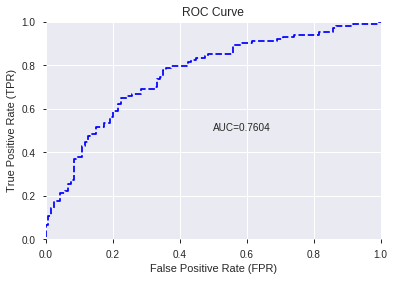

This function is available for GLM models only


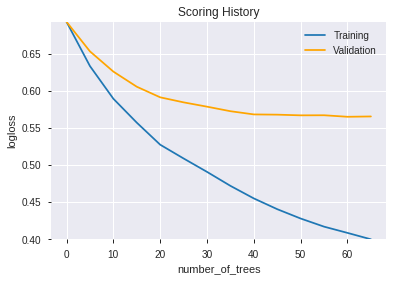

--2019-08-26 21:40:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_214028',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_214028',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a650',
   'ty

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'ATR_8',
 'PLUS_DM_8',
 'ADOSC',
 'STOCH_slowd',
 'MINUS_DI_30',
 'WILLR_14',
 'ULTOSC',
 'NATR_8',
 'DX_30',
 'MFI_14',
 'CCI_12',
 'DX_20',
 'MAVP_20_3',
 'aroonup_8',
 'PLUS_DI_8',
 'ROCP_8',
 'BBANDS_lowerband_20_5_5',
 'WILLR_8',
 'ADX_8',
 'MACDFIX_hist_24',
 'ROCR100_14',
 'WILLR_12',
 'PLUS_DM_20',
 'STOCHF_fastd',
 'BETA_8',
 'AVGPRICE',
 'PLUS_DM_30',
 'ROCP_20',
 'MINUS_DM_20',
 'NATR_12',
 'BBANDS_lowerband_20_1_5',
 'aroondown_8',
 'PLUS_DI_24',
 'aroonup_12',
 'AROONOSC_24',
 'MFI_24',
 'MACDEXT_hist',
 'ATR_14',
 'ADXR_14',
 'ROCP_30',
 'MINUS_DM_12',
 'PLUS_DI_20',
 'ROCR100_12',
 'WILLR_20',
 'aroondown_14',
 'PPO',
 'AROONOSC_8',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_24_0_4',
 'ATR_20',
 'MOM_24',
 'ROCR100_24',
 'CCI_24',
 'CDLBELTHOLD',
 'ROCR100_8',
 'aroonup_24',
 'MINUS_DI_14',
 'RSI_14',
 'TRIX_12',
 'MINUS_DM_24',
 'aroondown_12',
 'WILLR_24',
 'aroonup_14',
 'CDLS

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.713
GLM             0.740
XGBoost         0.726
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.717    0.726
DLF          0.700  0.717    0.704
Fwe          0.713  0.740    0.709
RFE          0.704  0.726    0.717
XGBF         0.686  0.717    0.704





F1


DeepLearning    0.720
GLM             0.711
XGBoost         0.721
dtype: float64

DeepLearning    GLM  XGBoost
All          0.713  0.711    0.716
DLF          0.693  0.705    0.721
Fwe          0.714  0.705    0.711
RFE          0.720  0.708    0.714
XGBF         0.720  0.705    0.721





auc


DeepLearning    0.767
GLM             0.773
XGBoost         0.767
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.758    0.763
DLF          0.744  0.763    0.767
Fwe          0.767  0.773    0.765
RFE          0.760  0.771    0.760
XGBF         0.744  0.763    0.767





logloss


DeepLearning    0.639
GLM             0.588
XGBoost         0.590
dtype: float64

DeepLearning    GLM  XGBoost
All          0.590  0.588    0.581
DLF          0.639  0.585    0.575
Fwe          0.581  0.570    0.577
RFE          0.592  0.574    0.590
XGBF         0.591  0.585    0.575





mean_per_class_error


DeepLearning    0.312
GLM             0.290
XGBoost         0.294
dtype: float64

DeepLearning    GLM  XGBoost
All          0.303  0.281    0.282
DLF          0.311  0.290    0.294
Fwe          0.283  0.273    0.292
RFE          0.287  0.274    0.286
XGBF         0.312  0.290    0.294





rmse


DeepLearning    0.465
GLM             0.449
XGBoost         0.448
dtype: float64

DeepLearning    GLM  XGBoost
All          0.451  0.449    0.445
DLF          0.465  0.449    0.443
Fwe          0.448  0.440    0.445
RFE          0.447  0.443    0.448
XGBF         0.451  0.449    0.443





mse


DeepLearning    0.216
GLM             0.202
XGBoost         0.201
dtype: float64

DeepLearning    GLM  XGBoost
All          0.203  0.202    0.198
DLF          0.216  0.201    0.196
Fwe          0.201  0.194    0.198
RFE          0.199  0.196    0.201
XGBF         0.203  0.201    0.196

{'F1':       DeepLearning    GLM  XGBoost
 All          0.713    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.705      NaN
 DLF            NaN    NaN    0.721
 All            NaN  0.711      NaN
 All            NaN    NaN    0.716
 XGBF         0.720    NaN      NaN
 XGBF           NaN  0.705      NaN
 XGBF           NaN    NaN    0.721
 Fwe          0.714    NaN      NaN
 Fwe            NaN  0.705      NaN
 Fwe            NaN    NaN    0.711
 RFE          0.720    NaN      NaN
 RFE            NaN  0.708      NaN
 RFE            NaN    NaN    0.714,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.700    NaN      NaN
 DLF            NaN  0.717      NaN
 DLF            NaN    NaN    0.704
 All            NaN  0.717      NaN
 All            NaN    NaN    0.726
 XGBF         0.686    NaN      NaN
 XGBF           NaN  0.717      NaN
 XGBF           NaN    NaN    0.704
 Fwe          0.713    NaN      NaN
 Fwe     